<a href="https://colab.research.google.com/github/harrybirdnz/ZZSC9020-Group_F/blob/main/individual/cameron/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
from google.colab import drive

drive.mount('/content/drive')
env_path = '/content/drive/MyDrive/secrets/.env'
if os.path.exists(env_path):
    token = os.getenv('GITHUB_TOKEN')
    load_dotenv(env_path)
    print("Secrets loaded from .env")
else:
    print(".env file not found at:", env_path)

REPO_NAME = 'ZZSC9020-Group_F'
repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
REPO_PATH = f"/content/{REPO_NAME}"
NOTEBOOK_SUBDIR = 'individual/cameron'

if not os.path.exists(REPO_PATH):
    print(f"Cloning repo: {REPO_NAME}")
    !git clone {REPO_URL}
else:
    print(f"Repo already exists at: {REPO_PATH}")
    os.chdir(REPO_PATH)
    print("Pulling changes from repo...")
    !git pull


target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
if os.path.exists(target_path):
    os.chdir(target_path)
    print(f"Working directory set to: {os.getcwd()}")
else:
    print(f"Target notebook path not found: {target_path}")



Mounted at /content/drive
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
fatal: could not read Password for 'https://None@github.com': No such device or address
Target notebook path not found: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 29.6 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [5]:
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df.head()

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0  2016-01-01          1          0          0          0          0   
1  2016-01-02          1          0          0          0          0   
2  2016-01-03          1          0          0          0          1   
3  2016-01-04          1          0          0          0          0   
4  2016-01-05          1          0          0          0          0   

   is_monday  is_tuesday  is_wednesday  is_thursday  ...  max_30_min_demand  \
0          0           0             0            0  ...            7913.75   
1          0           0             0            0  ...            7390.04   
2          0           0             0            0  ...            7328.39   
3          1           0             0            0  ...            8313.11   
4          0           1             0            0  ...            8338.82   

   sum_30_min_demand  count_30_min_points   avg_temp  min_temp  max_temp  \
0          329352.88                   48  20.704082      15.2      26.0   
1          323133.95                   48  20.572917      14.9      24.2   
2          317665.92                   48  21.130769      19.0      22.9   
3          353210.40                   48  20.144444      18.4      23.1   
4          358082.97                   48  18.904808      17.4      20.3   

   hd_next_24h  cd_next_24h  precipitation  sunlight  
0          0.0     1.204082       2.140095      32.3  
1          0.0     1.072917       6.496326      23.2  
2          0.0     1.630769       8.562486      12.7  
3          0.0     0.644444       4.082204       7.6  
4          0.0     0.000000       9.977372       3.9  

[5 rows x 38 columns]

In [6]:
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [7]:
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

In [8]:
print(test_df.columns)

Index(['is_summer', 'is_autumn', 'is_winter', 'is_spring', 'is_sunday',
       'is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday',
       'is_saturday', 'is_weekend', 'is_weekday', 'is_jan', 'is_feb', 'is_mar',
       'is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct',
       'is_nov', 'is_dec', 'avg_30_min_demand', 'min_30_min_demand',
       'max_30_min_demand', 'sum_30_min_demand', 'count_30_min_points',
       'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h',
       'precipitation', 'sunlight'],
      dtype='object')


## Helper Functions ##

In [9]:
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def to_X_and_y(self, df_scaled, target_col='avg_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:  # No 'val_raw' in this subclass
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled
    def get_model_inputs(self, target_col='avg_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:  # No val_scaled here
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs


### Setup function for printing, metrics ###

In [10]:
## Optuna Function
def objective(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [215]:
## Tweaked Optuna function for early stopping, etc.

def objective2(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

In [218]:
## Optuna Function for CNN=LSTM Hybrid ##

def objective3(trial):
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Dense head
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        # Inverse transform
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae


In [234]:
## Final Optuna Function - include Recurrent Dropout

def objective4(trial):
    # Detect device
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test29, verbose=0)

        # Inverse transform target column 'avg_30_min_demand'
        target_index = preprocessor.splits['train_raw'].columns.get_loc('avg_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## 1. Base Model - Avg Demand Only ##

In [11]:
demandDF = test_df[['avg_30_min_demand']]

In [12]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

i = X_train.shape[1]
j = X_train.shape[2]

In [13]:
def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='avg_30_min_demand'):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')
    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [14]:
model1 = Sequential()
model1.add(InputLayer((i, j)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1023 - mean_absolute_percentage_error: 280096.1562 - root_mean_squared_error: 0.3129 - val_loss: 0.0215 - val_mean_absolute_percentage_error: 51.8121 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0214 - mean_absolute_percentage_error: 1243151.5000 - root_mean_squared_error: 0.1463 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 35.1617 - val_root_mean_squared_error: 0.1137
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - mean_absolute_percentage_error: 1113142.6250 - root_mean_squared_error: 0.1318 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 35.7316 - val_root_mean_squared_error: 0.1126
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0168 - mean_absolute_percentage_error: 1099893.0000 - root_mean_squared_error: 0.1296 - val_loss: 0.0127 - val_mean_absolute_percentage_error: 36.2724 - val_root_mean_squared_error: 0.112

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


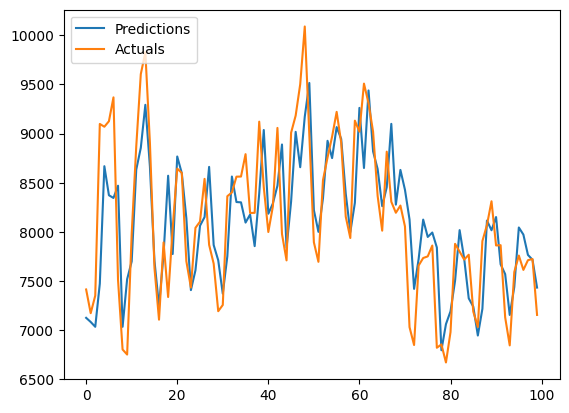

MAPE: 3.93%
RMSE: 426.75
MAE : 317.82


Predictions      Actuals
0    7123.991699  7412.811667
1    7081.909180  7171.183125
2    7032.775879  7350.264167
3    7471.240723  9098.258333
4    8668.080078  9070.002917
..           ...          ...
719  7912.763672  7374.332292
720  7875.290039  8039.583333
721  8216.116211  8575.767292
722  8444.512695  7909.507917
723  7630.717285  7144.386250

[724 rows x 2 columns]

In [16]:
model1 = load_model('model1.keras')

predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


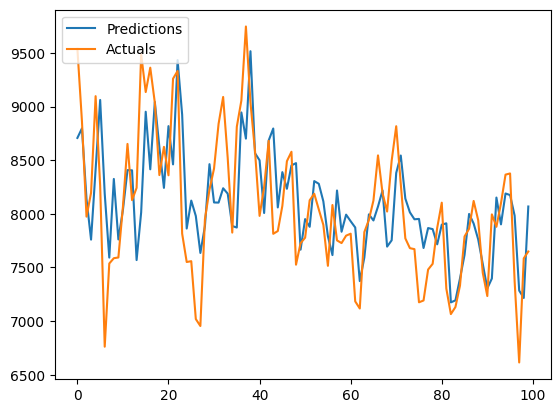

MAPE: 3.77%
RMSE: 390.26
MAE : 299.87


Predictions      Actuals
0    8707.101562  9537.097917
1    8796.283203  8863.333125
2    8138.981445  7973.787500
3    7759.552246  8194.981667
4    8414.518555  9096.434375
..           ...          ...
353  8012.108887  8447.030417
354  8192.131836  8771.408958
355  7981.049316  8487.014792
356  7551.151855  8380.489792
357  7652.304688  8437.980833

[358 rows x 2 columns]

In [17]:
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


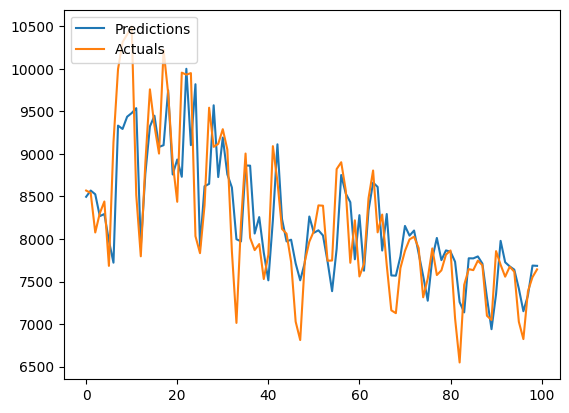

MAPE: 3.87%
RMSE: 411.22
MAE : 307.32


Predictions      Actuals
0    8496.068359  8569.568125
1    8569.388672  8540.904167
2    8525.583984  8076.513125
3    8268.622070  8302.971875
4    8293.476562  8440.820000
..           ...          ...
353  7671.764160  7508.199792
354  7795.338379  7694.271458
355  7483.563477  7746.240833
356  7600.515137  8321.401042
357  7877.860352  8503.726875

[358 rows x 2 columns]

In [18]:
predictions_plot(model1, X_test, y_test, 0, 100)

### Model 2 - Overlapping Windows ###

In [19]:
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

i = X_train2.shape[1]
j = X_train2.shape[2]

In [20]:
model2 = Sequential()
model2.add(InputLayer((i, j)))
model2.add(LSTM(64))
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1478 - root_mean_squared_error: 0.3830 - val_loss: 0.0363 - val_root_mean_squared_error: 0.1906
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0278 - root_mean_squared_error: 0.1659 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0181 - root_mean_squared_error: 0.1344 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0182 - root_mean_squared_error: 0.1349 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0181 - root_mean_squared_error: 0.1346 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


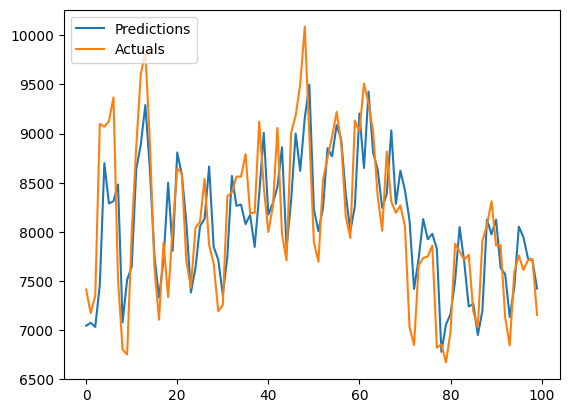

MAPE: 3.93%
RMSE: 429.10
MAE : 318.67


Predictions      Actuals
0    7044.175781  7412.811667
1    7073.492676  7171.183125
2    7031.485352  7350.264167
3    7459.706055  9098.258333
4    8698.825195  9070.002917
..           ...          ...
719  7921.055664  7374.332292
720  7885.886719  8039.583333
721  8209.762695  8575.767292
722  8428.964844  7909.507917
723  7585.459961  7144.386250

[724 rows x 2 columns]

In [22]:
model2 = load_model('model2.keras')

predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


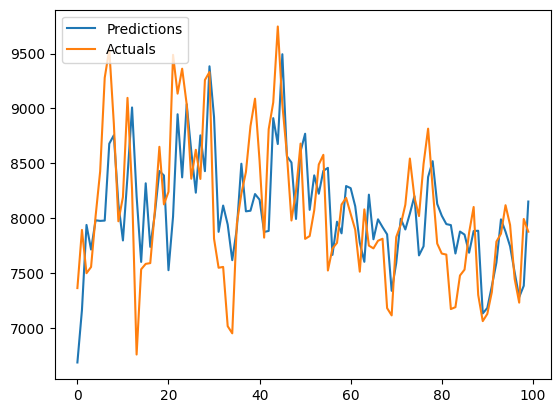

MAPE: 3.84%
RMSE: 399.81
MAE : 305.95


Predictions      Actuals
0    6689.274414  7365.989375
1    7165.954590  7895.121667
2    7940.450684  7501.373542
3    7716.783203  7557.751458
4    7982.725098  8021.308125
..           ...          ...
360  8048.647949  8447.030417
361  8137.806641  8771.408958
362  7639.551270  8487.014792
363  7552.980469  8380.489792
364  7665.658691  8437.980833

[365 rows x 2 columns]

In [23]:
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


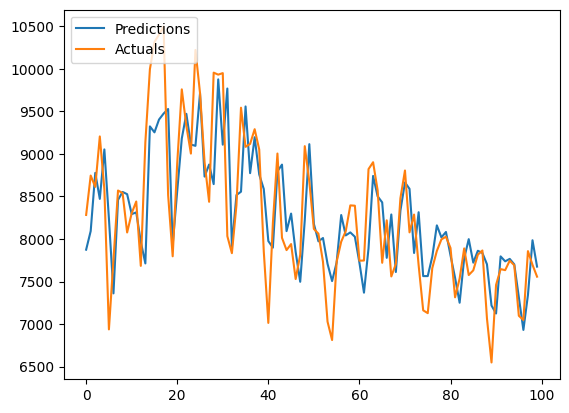

MAPE: 3.94%
RMSE: 419.28
MAE : 313.87


Predictions      Actuals
0    7874.537598  8282.850208
1    8093.583984  8745.688125
2    8776.916992  8612.550625
3    8471.635742  9205.374583
4    9052.815430  8584.935417
..           ...          ...
360  7695.788086  7508.199792
361  7806.583496  7694.271458
362  7438.844238  7746.240833
363  7583.682617  8321.401042
364  7883.508789  8503.726875

[365 rows x 2 columns]

In [24]:
predictions_plot(model2, X_test2, y_test2, 0, 100)

## 2. Introducing Temperature... ##

In [25]:
tempDemandDF = test_df[['avg_30_min_demand', 'avg_temp']]

In [26]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [27]:
model3 = Sequential()
model3.add(InputLayer((i, j)))
model3.add(LSTM(64))
model3.add(Dense(8, 'tanh'))
model3.add(Dense(1, 'linear'))

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,681 (69.07 KB)

 Trainable params: 17,681 (69.07 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0708 - root_mean_squared_error: 0.2602 - val_loss: 0.0181 - val_root_mean_squared_error: 0.1345
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - root_mean_squared_error: 0.1310 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1324 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1212
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1204
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


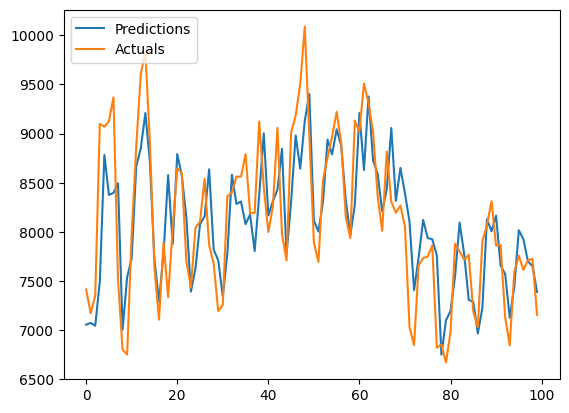

MAPE: 3.85%
RMSE: 421.95
MAE : 310.91


Predictions      Actuals
0    7054.228027  7412.811667
1    7072.127930  7171.183125
2    7044.119629  7350.264167
3    7491.905273  9098.258333
4    8782.722656  9070.002917
..           ...          ...
719  7971.597168  7374.332292
720  7926.674805  8039.583333
721  8312.892578  8575.767292
722  8516.370117  7909.507917
723  7698.814453  7144.386250

[724 rows x 2 columns]

In [29]:
model3 = load_model('model3.keras')

predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


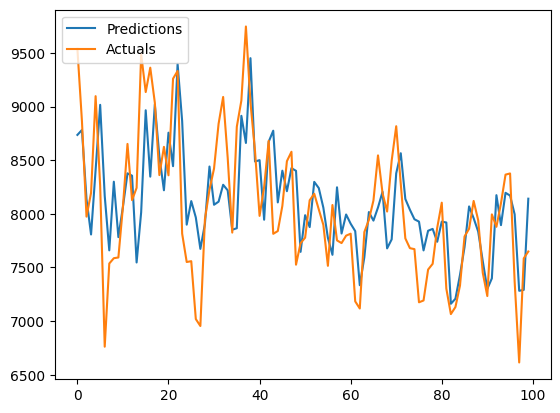

MAPE: 3.74%
RMSE: 386.30
MAE : 297.20


Predictions      Actuals
0    8735.293945  9537.097917
1    8781.384766  8863.333125
2    8137.437988  7973.787500
3    7807.470703  8194.981667
4    8408.714844  9096.434375
..           ...          ...
353  8042.509766  8447.030417
354  8276.074219  8771.408958
355  8055.935547  8487.014792
356  7721.913574  8380.489792
357  7781.483887  8437.980833

[358 rows x 2 columns]

In [30]:
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


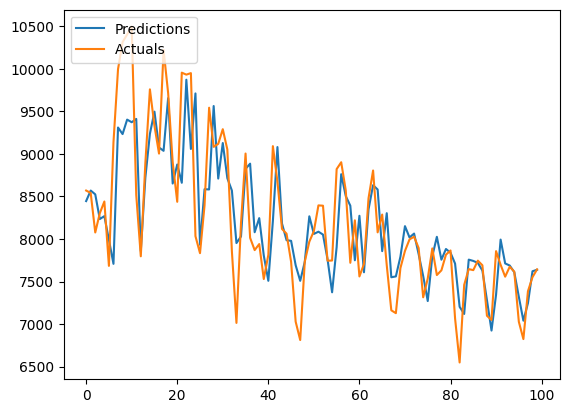

MAPE: 3.85%
RMSE: 413.27
MAE : 306.45


Predictions      Actuals
0    8445.625000  8569.568125
1    8569.533203  8540.904167
2    8524.527344  8076.513125
3    8234.503906  8302.971875
4    8268.679688  8440.820000
..           ...          ...
353  7732.568848  7508.199792
354  7906.060059  7694.271458
355  7725.493652  7746.240833
356  7815.207520  8321.401042
357  8080.183594  8503.726875

[358 rows x 2 columns]

In [31]:
predictions_plot(model3, X_test3, y_test3, 0, 100)

## Feature Analysis ##

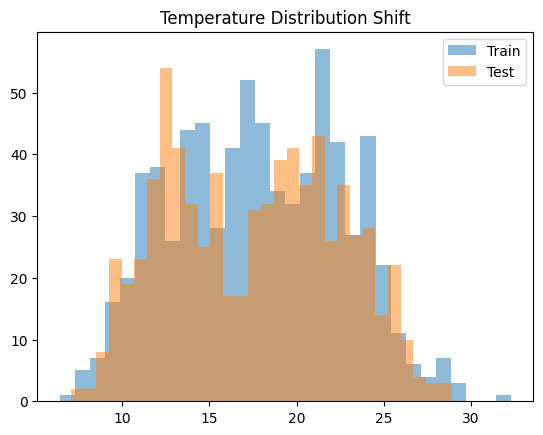

In [32]:
plt.hist(test_df['avg_temp'][0:731], bins=30, alpha=0.5, label='Train')
plt.hist(test_df['avg_temp'][732:], bins=30, alpha=0.5, label='Test')
plt.legend()
plt.title("Temperature Distribution Shift")
plt.show()

## Testing Temp Measures ##

In [33]:
tempDemandDF2 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

## Model 4 ##

In [34]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

i = X_train4.shape[1]
j = X_train4.shape[2]

In [35]:
model4 = Sequential()
model4.add(InputLayer((i, j)))
model4.add(LSTM(64))
model4.add(Dense(8, 'tanh'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1594 - root_mean_squared_error: 0.3879 - val_loss: 0.0242 - val_root_mean_squared_error: 0.1554
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0242 - root_mean_squared_error: 0.1555 - val_loss: 0.0163 - val_root_mean_squared_error: 0.1275
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0192 - root_mean_squared_error: 0.1386 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0178 - root_mean_squared_error: 0.1335 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1198
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1209
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1329 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1215
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


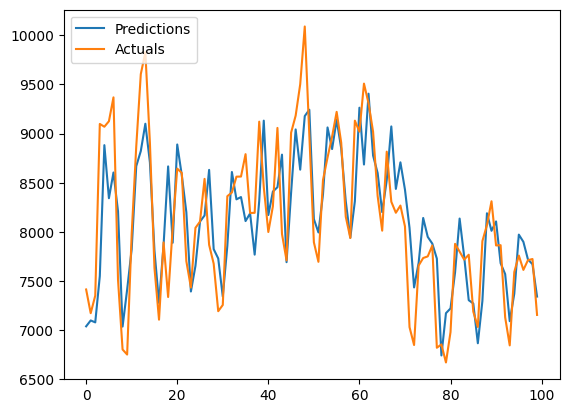

MAPE: 3.80%
RMSE: 413.48
MAE : 305.96


Predictions      Actuals
0    7037.444824  7412.811667
1    7097.343262  7171.183125
2    7077.840820  7350.264167
3    7549.105957  9098.258333
4    8882.404297  9070.002917
..           ...          ...
719  7904.451660  7374.332292
720  8026.363770  8039.583333
721  8308.071289  8575.767292
722  8459.106445  7909.507917
723  7514.976562  7144.386250

[724 rows x 2 columns]

In [37]:
model4 = load_model('model4.keras')

predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


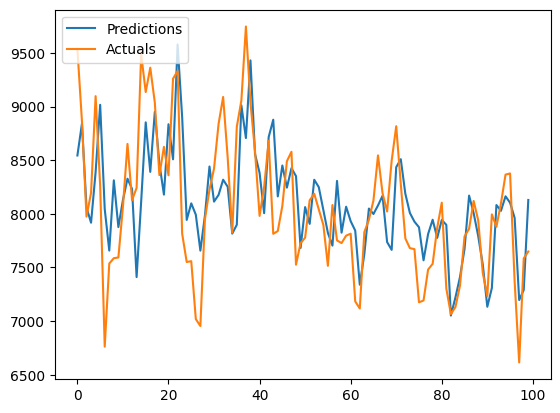

MAPE: 3.73%
RMSE: 386.18
MAE : 295.90


Predictions      Actuals
0    8543.592773  9537.097917
1    8840.349609  8863.333125
2    8059.380859  7973.787500
3    7917.020020  8194.981667
4    8388.673828  9096.434375
..           ...          ...
353  8012.473145  8447.030417
354  8371.392578  8771.408958
355  8272.211914  8487.014792
356  7785.166016  8380.489792
357  7734.685059  8437.980833

[358 rows x 2 columns]

In [38]:
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


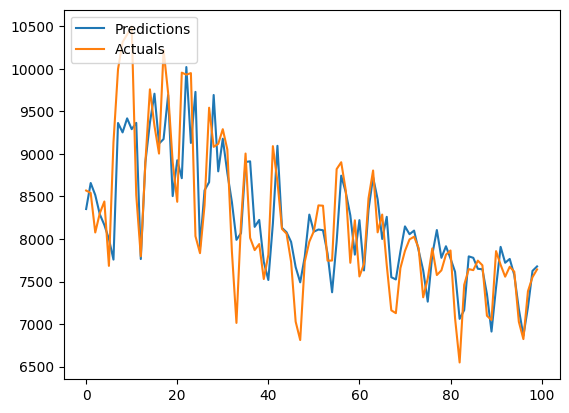

MAPE: 3.82%
RMSE: 406.75
MAE : 302.84


Predictions      Actuals
0    8352.379883  8569.568125
1    8657.973633  8540.904167
2    8517.013672  8076.513125
3    8290.388672  8302.971875
4    8164.752441  8440.820000
..           ...          ...
353  7778.452637  7508.199792
354  7893.933105  7694.271458
355  7811.509766  7746.240833
356  7824.935059  8321.401042
357  8093.240234  8503.726875

[358 rows x 2 columns]

In [39]:
predictions_plot(model4, X_test4, y_test4, 0, 100)

## Model 5 ##

In [40]:
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

tempDemandDF3 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [41]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

i = X_train5.shape[1]
j = X_train5.shape[2]

In [42]:
model5 = Sequential()
model5.add(InputLayer((i, j)))
model5.add(LSTM(64))
model5.add(Dense(8, 'tanh'))
model5.add(Dense(1, 'linear'))

model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,937 (70.07 KB)

 Trainable params: 17,937 (70.07 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0595 - root_mean_squared_error: 0.2385 - val_loss: 0.0149 - val_root_mean_squared_error: 0.1219
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - root_mean_squared_error: 0.1321 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0177 - root_mean_squared_error: 0.1331 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1207
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


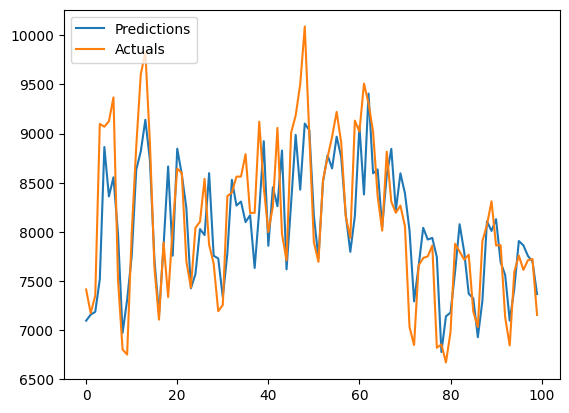

MAPE: 3.67%
RMSE: 404.21
MAE : 297.40


Predictions      Actuals
0    7095.214844  7412.811667
1    7156.658203  7171.183125
2    7184.836426  7350.264167
3    7516.610840  9098.258333
4    8863.441406  9070.002917
..           ...          ...
719  7898.468750  7374.332292
720  7921.843262  8039.583333
721  8340.828125  8575.767292
722  8572.041992  7909.507917
723  7727.137207  7144.386250

[724 rows x 2 columns]

In [44]:
model5 = load_model('model5.keras')

predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


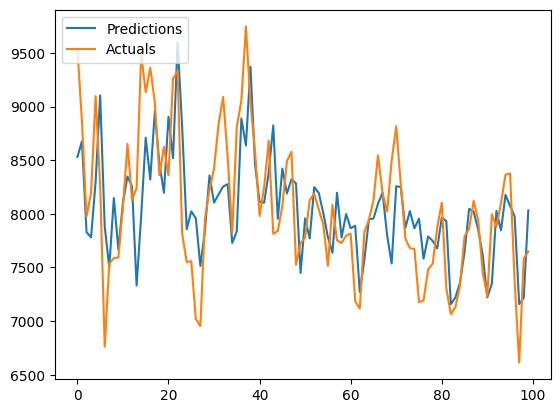

MAPE: 3.67%
RMSE: 383.22
MAE : 292.62


Predictions      Actuals
0    8529.048828  9537.097917
1    8676.231445  8863.333125
2    7829.848145  7973.787500
3    7780.471191  8194.981667
4    8298.591797  9096.434375
..           ...          ...
353  8036.979492  8447.030417
354  8364.683594  8771.408958
355  8211.520508  8487.014792
356  7726.251465  8380.489792
357  7610.526855  8437.980833

[358 rows x 2 columns]

In [45]:
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


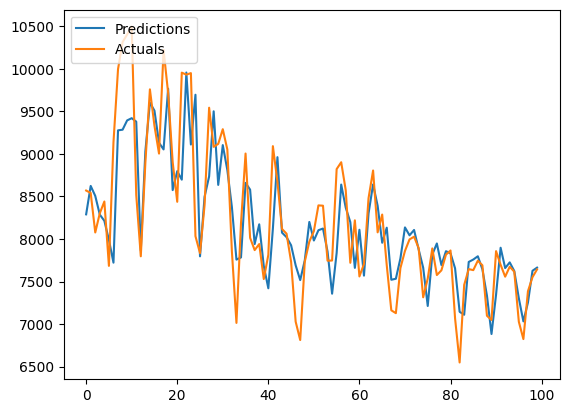

MAPE: 3.73%
RMSE: 397.54
MAE : 296.32


Predictions      Actuals
0    8289.767578  8569.568125
1    8623.686523  8540.904167
2    8506.344727  8076.513125
3    8286.250000  8302.971875
4    8213.717773  8440.820000
..           ...          ...
353  7755.591797  7508.199792
354  7908.679688  7694.271458
355  7814.621094  7746.240833
356  7899.757812  8321.401042
357  8154.878418  8503.726875

[358 rows x 2 columns]

In [46]:
predictions_plot(model5, X_test5, y_test5, 0, 100)

## Model 6 ##

In [47]:
tempDemandDF4 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [48]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

i = X_train6.shape[1]
j = X_train6.shape[2]

In [49]:
model6 = Sequential()
model6.add(InputLayer((i, j)))
model6.add(LSTM(64))
model6.add(Dense(8, 'tanh'))
model6.add(Dense(1, 'linear'))

model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [50]:
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0513 - root_mean_squared_error: 0.2223 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0199 - root_mean_squared_error: 0.1409 - val_loss: 0.0158 - val_root_mean_squared_error: 0.1256
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0159 - root_mean_squared_error: 0.1258 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1251 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1107
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


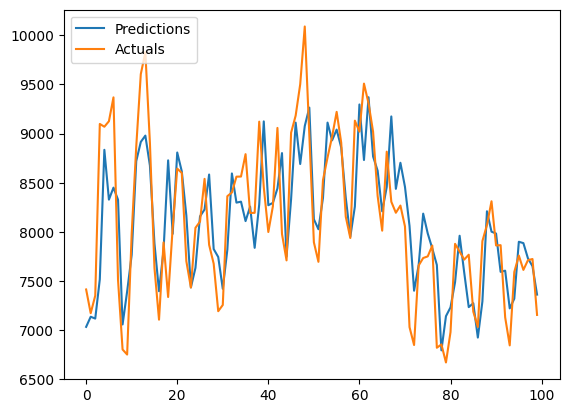

MAPE: 3.94%
RMSE: 424.50
MAE : 317.29


Predictions      Actuals
0    7032.019043  7412.811667
1    7135.142578  7171.183125
2    7116.399902  7350.264167
3    7516.519531  9098.258333
4    8834.948242  9070.002917
..           ...          ...
719  7846.480957  7374.332292
720  8064.348145  8039.583333
721  8192.026367  8575.767292
722  8204.376953  7909.507917
723  7352.575684  7144.386250

[724 rows x 2 columns]

In [51]:
model6 = load_model('model6.keras')
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


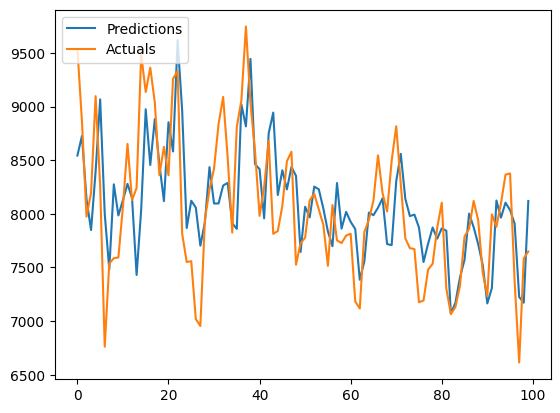

MAPE: 3.90%
RMSE: 399.84
MAE : 309.84


Predictions      Actuals
0    8543.107422  9537.097917
1    8725.476562  8863.333125
2    8137.074219  7973.787500
3    7848.715332  8194.981667
4    8394.308594  9096.434375
..           ...          ...
353  7894.561035  8447.030417
354  8205.805664  8771.408958
355  8043.560547  8487.014792
356  7661.464844  8380.489792
357  7676.728027  8437.980833

[358 rows x 2 columns]

In [52]:
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


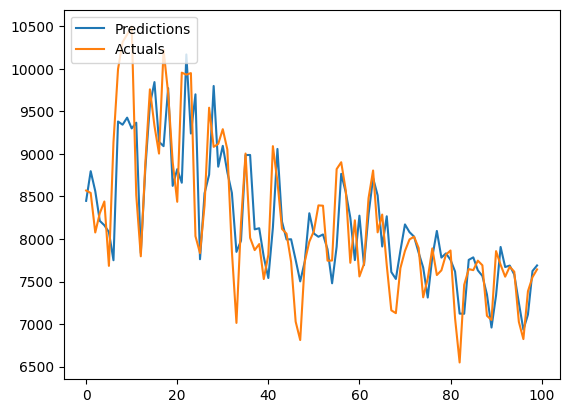

MAPE: 4.01%
RMSE: 422.86
MAE : 318.13


Predictions      Actuals
0    8448.398438  8569.568125
1    8797.190430  8540.904167
2    8562.833008  8076.513125
3    8212.916992  8302.971875
4    8161.420410  8440.820000
..           ...          ...
353  7618.266113  7508.199792
354  7754.114746  7694.271458
355  7616.500488  7746.240833
356  7618.997559  8321.401042
357  7928.214355  8503.726875

[358 rows x 2 columns]

In [53]:
predictions_plot(model6, X_test6, y_test6, 0, 100)

## Increase Window Size to 10 ##

## Model 7 ##

In [54]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

i = X_train7.shape[1]
j = X_train7.shape[2]

In [55]:
model7 = Sequential()
model7.add(InputLayer((i, j)))
model7.add(LSTM(64))
model7.add(Dense(8, 'tanh'))
model7.add(Dense(1, 'linear'))

model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0468 - root_mean_squared_error: 0.2136 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0190 - root_mean_squared_error: 0.1376 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1308 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1125
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0166 - root_mean_squared_error: 0.1288 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1130
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1282 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1275 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


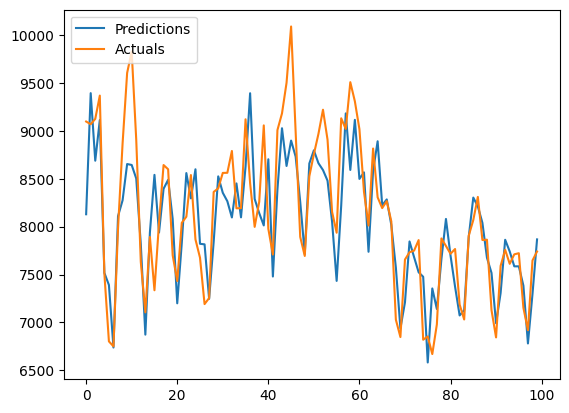

MAPE: 3.49%
RMSE: 380.25
MAE : 284.15


Predictions      Actuals
0    8129.727539  9098.258333
1    9394.579102  9070.002917
2    8689.064453  9125.678750
3    9113.915039  9368.951875
4    7517.963379  7510.325833
..           ...          ...
716  7471.497070  7374.332292
717  7768.298340  8039.583333
718  8053.612305  8575.767292
719  8290.615234  7909.507917
720  7381.695312  7144.386250

[721 rows x 2 columns]

In [57]:
model7 = load_model('model7.keras')

predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


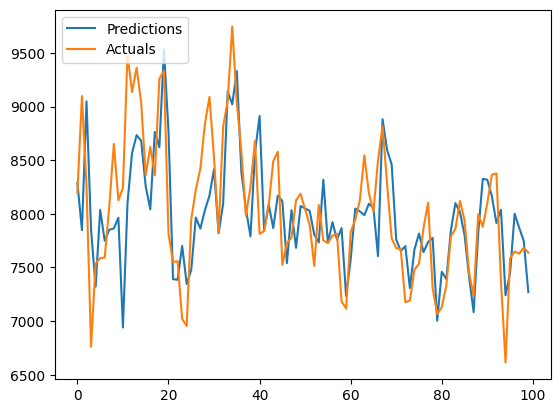

MAPE: 3.61%
RMSE: 378.81
MAE : 288.56


Predictions      Actuals
0    8288.225586  8194.981667
1    7847.453125  9096.434375
2    9047.810547  8261.405417
3    7851.591797  6761.608125
4    7321.286133  7536.762292
..           ...          ...
350  7688.020508  8447.030417
351  8198.244141  8771.408958
352  8370.575195  8487.014792
353  7872.983887  8380.489792
354  7757.041016  8437.980833

[355 rows x 2 columns]

In [58]:
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


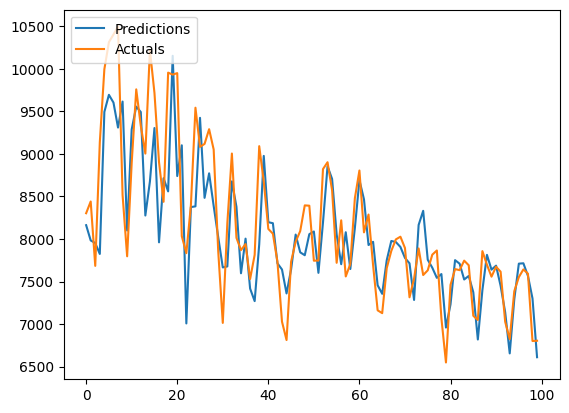

MAPE: 3.87%
RMSE: 412.65
MAE : 309.45


Predictions      Actuals
0    8162.437012  8302.971875
1    7983.179199  8440.820000
2    7952.213379  7684.176042
3    7824.295898  9135.772083
4    9493.716797  9995.508542
..           ...          ...
350  7656.725586  7508.199792
351  7821.526367  7694.271458
352  7889.848633  7746.240833
353  7819.335938  8321.401042
354  8228.440430  8503.726875

[355 rows x 2 columns]

In [59]:
predictions_plot(model7, X_test7, y_test7, 0, 100)

## Model 8 - Decrease Window Size to 5 ##

In [60]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

i = X_train8.shape[1]
j = X_train8.shape[2]

In [61]:
model8 = Sequential()
model8.add(InputLayer((i, j)))
model8.add(LSTM(64))
model8.add(Dense(8, 'tanh'))
model8.add(Dense(1, 'linear'))

model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0747 - root_mean_squared_error: 0.2704 - val_loss: 0.0286 - val_root_mean_squared_error: 0.1692
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0285 - root_mean_squared_error: 0.1688 - val_loss: 0.0155 - val_root_mean_squared_error: 0.1244
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0201 - root_mean_squared_error: 0.1417 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0184 - root_mean_squared_error: 0.1354 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1156
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


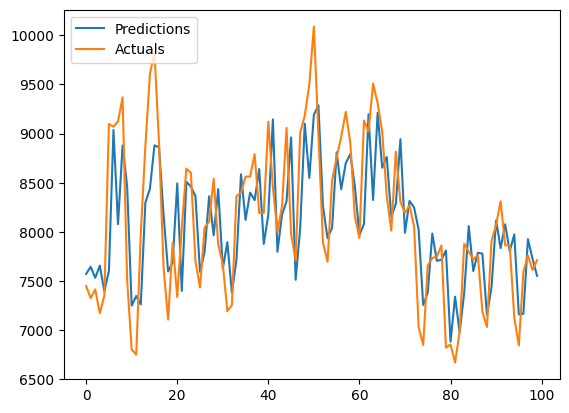

MAPE: 4.35%
RMSE: 463.33
MAE : 349.75


Predictions      Actuals
0    7571.145508  7446.897083
1    7643.941895  7324.388958
2    7531.498047  7412.811667
3    7655.595215  7171.183125
4    7392.532227  7350.264167
..           ...          ...
721  7335.322266  7374.332292
722  7746.531250  8039.583333
723  8045.089844  8575.767292
724  8325.435547  7909.507917
725  7416.770020  7144.386250

[726 rows x 2 columns]

In [63]:
model8 = load_model('model8.keras')

predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


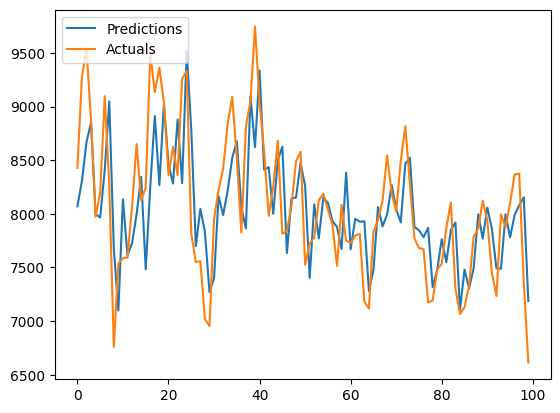

MAPE: 4.03%
RMSE: 407.18
MAE : 320.71


Predictions      Actuals
0    8069.665527  8428.290208
1    8306.534180  9279.195417
2    8668.981445  9537.097917
3    8850.164062  8863.333125
4    7995.892090  7973.787500
..           ...          ...
355  7667.465332  8447.030417
356  8219.950195  8771.408958
357  8196.856445  8487.014792
358  7971.705566  8380.489792
359  8097.744141  8437.980833

[360 rows x 2 columns]

In [64]:
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


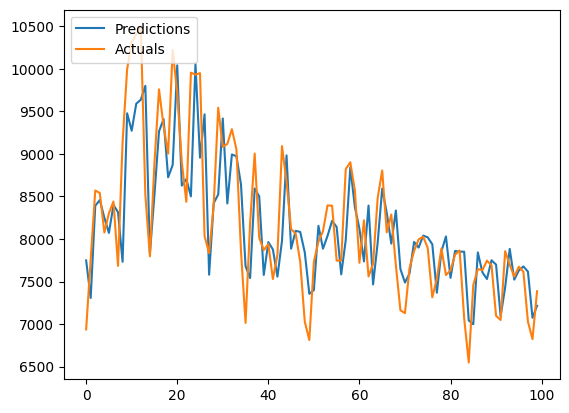

MAPE: 4.25%
RMSE: 438.57
MAE : 335.87


Predictions      Actuals
0    7748.151367  6937.700208
1    7306.727539  7759.521667
2    8390.202148  8569.568125
3    8458.214844  8540.904167
4    8249.997070  8076.513125
..           ...          ...
355  7579.297363  7508.199792
356  7737.976074  7694.271458
357  7740.140625  7746.240833
358  7748.209473  8321.401042
359  8252.944336  8503.726875

[360 rows x 2 columns]

In [65]:
predictions_plot(model8, X_test8, y_test8, 0, 100)

## Model 9 - Increase Window Size to 14 ##

In [66]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

i = X_train9.shape[1]
j = X_train9.shape[2]

In [67]:
model9 = Sequential()
model9.add(InputLayer((i, j)))
model9.add(LSTM(64))
model9.add(Dense(8, 'tanh'))
model9.add(Dense(1, 'linear'))

model9.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,449 (72.07 KB)

 Trainable params: 18,449 (72.07 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0751 - root_mean_squared_error: 0.2691 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1385
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0226 - root_mean_squared_error: 0.1502 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1160
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1381 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0178 - root_mean_squared_error: 0.1333 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1116
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0177 - root_mean_squared_error: 0.1330 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1108
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0175 - root_mean_squared_error: 0.1323 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


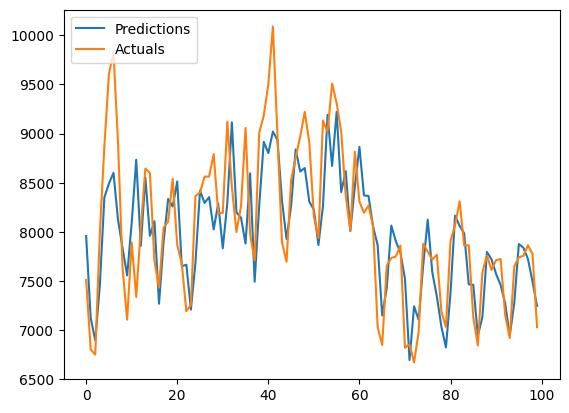

MAPE: 3.68%
RMSE: 404.36
MAE : 299.14


Predictions      Actuals
0    7957.159180  7510.325833
1    7123.519043  6801.918750
2    6894.611328  6750.140625
3    7447.952148  7981.096667
4    8351.228516  8868.038333
..           ...          ...
712  7492.098633  7374.332292
713  7757.291016  8039.583333
714  8039.567871  8575.767292
715  8146.372559  7909.507917
716  7388.126953  7144.386250

[717 rows x 2 columns]

In [69]:
model9 = load_model('model9.keras')

predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


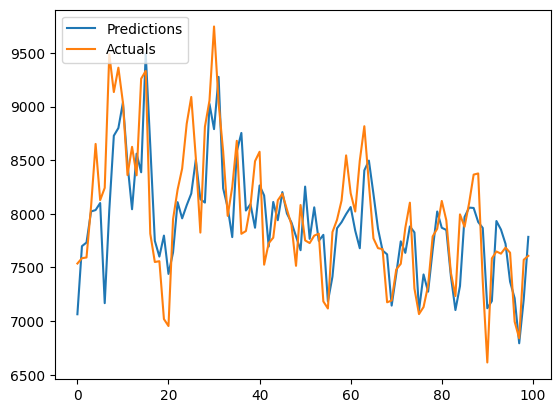

MAPE: 3.41%
RMSE: 359.45
MAE : 273.18


Predictions      Actuals
0    7064.038574  7536.762292
1    7698.464355  7586.311250
2    7732.474609  7593.115208
3    8021.678711  8067.645208
4    8035.075684  8651.321042
..           ...          ...
346  7706.898926  8447.030417
347  8000.222656  8771.408958
348  8093.197754  8487.014792
349  7764.938477  8380.489792
350  7901.275391  8437.980833

[351 rows x 2 columns]

In [70]:
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


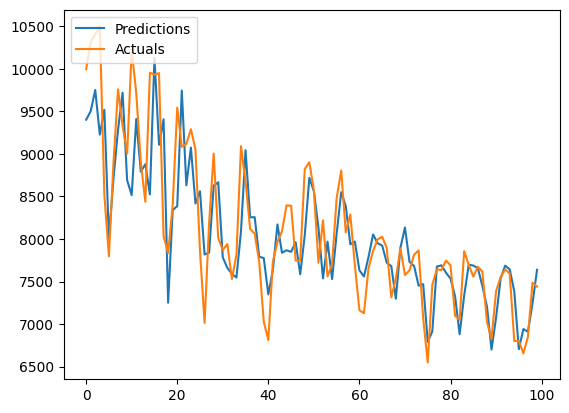

MAPE: 3.82%
RMSE: 404.41
MAE : 305.89


Predictions       Actuals
0    9401.672852   9995.508542
1    9502.323242  10313.686458
2    9750.942383  10402.964375
3    9226.755859  10497.618958
4    9518.294922   8517.349375
..           ...           ...
346  7397.585449   7508.199792
347  7483.770508   7694.271458
348  7661.884277   7746.240833
349  7626.479492   8321.401042
350  8119.122559   8503.726875

[351 rows x 2 columns]

In [71]:
predictions_plot(model9, X_test9, y_test9, 0, 100)

## Model 10 - Add CDD/HDD ##

In [72]:
tempDemandDF5 = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [73]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

i = X_train10.shape[1]
j = X_train10.shape[2]

In [74]:
model10 = Sequential()
model10.add(InputLayer((i, j)))
model10.add(LSTM(64))
model10.add(Dense(8, 'tanh'))
model10.add(Dense(1, 'linear'))

model10.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,961 (74.07 KB)

 Trainable params: 18,961 (74.07 KB)

 Non-trainable params: 0 (0.00 B)

In [75]:
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0263 - root_mean_squared_error: 0.1611 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1223
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1099
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0148 - root_mean_squared_error: 0.1217 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1088
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1081
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0139 - root_mean_squared_error: 0.1180 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


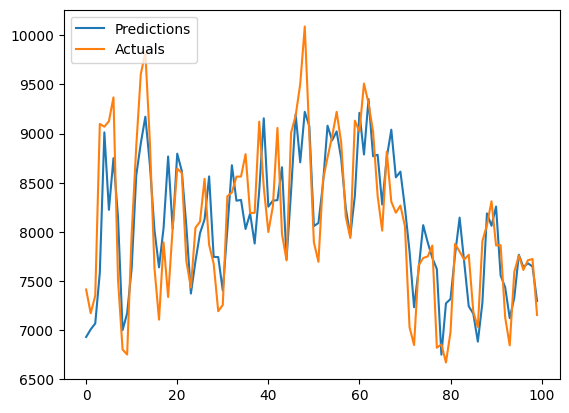

MAPE: 3.60%
RMSE: 396.26
MAE : 289.36


Predictions      Actuals
0    6929.099121  7412.811667
1    7006.397949  7171.183125
2    7066.980469  7350.264167
3    7583.141113  9098.258333
4    9012.492188  9070.002917
..           ...          ...
719  7887.992188  7374.332292
720  8103.556641  8039.583333
721  8182.901367  8575.767292
722  8166.680176  7909.507917
723  7231.626465  7144.386250

[724 rows x 2 columns]

In [76]:
model10 = load_model('model10.keras')
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


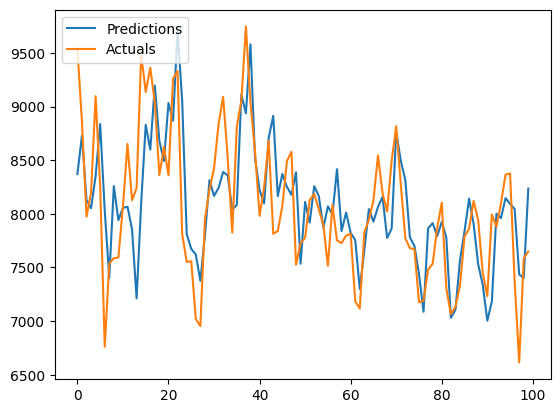

MAPE: 3.62%
RMSE: 376.87
MAE : 287.64


Predictions      Actuals
0    8370.352539  9537.097917
1    8728.227539  8863.333125
2    8130.067871  7973.787500
3    8051.832520  8194.981667
4    8352.004883  9096.434375
..           ...          ...
353  7953.334473  8447.030417
354  8233.094727  8771.408958
355  8259.265625  8487.014792
356  7792.020020  8380.489792
357  7797.135742  8437.980833

[358 rows x 2 columns]

In [77]:
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


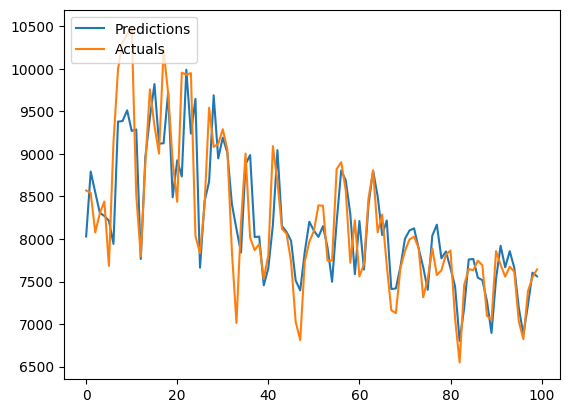

MAPE: 3.91%
RMSE: 411.16
MAE : 310.11


Predictions      Actuals
0    8029.681152  8569.568125
1    8791.740234  8540.904167
2    8548.310547  8076.513125
3    8307.713867  8302.971875
4    8270.880859  8440.820000
..           ...          ...
353  7857.350098  7508.199792
354  7822.423828  7694.271458
355  7894.404785  7746.240833
356  7750.937988  8321.401042
357  7833.191895  8503.726875

[358 rows x 2 columns]

In [78]:
predictions_plot(model10, X_test10, y_test10, 0, 100)

## Model 11 - Remove Avg Temp from Model 10 ##

In [79]:
tempDemandDF6 = test_df[['avg_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [80]:
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

i = X_train11.shape[1]
j = X_train11.shape[2]

In [81]:
model11 = Sequential()
model11.add(InputLayer((i, j)))
model11.add(LSTM(64))
model11.add(Dense(8, 'tanh'))
model11.add(Dense(1, 'linear'))

model11.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,705 (73.07 KB)

 Trainable params: 18,705 (73.07 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1278 - root_mean_squared_error: 0.3448 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1193
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0188 - root_mean_squared_error: 0.1370 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1173
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1292 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1165
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


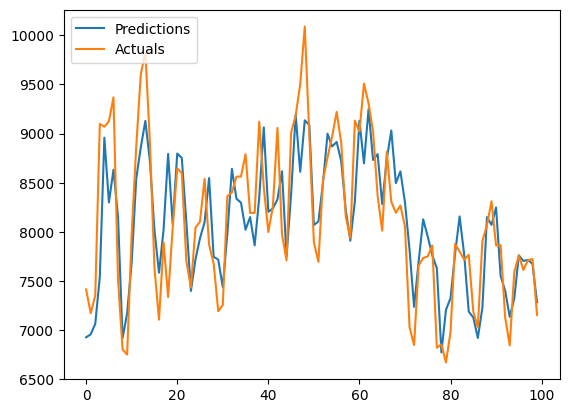

MAPE: 3.59%
RMSE: 395.81
MAE : 288.77


Predictions      Actuals
0    6925.896484  7412.811667
1    6956.104980  7171.183125
2    7063.314941  7350.264167
3    7539.921875  9098.258333
4    8958.141602  9070.002917
..           ...          ...
719  8001.605957  7374.332292
720  8187.899902  8039.583333
721  8223.906250  8575.767292
722  8204.328125  7909.507917
723  7434.624023  7144.386250

[724 rows x 2 columns]

In [83]:
model11 = load_model('model11.keras')

predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


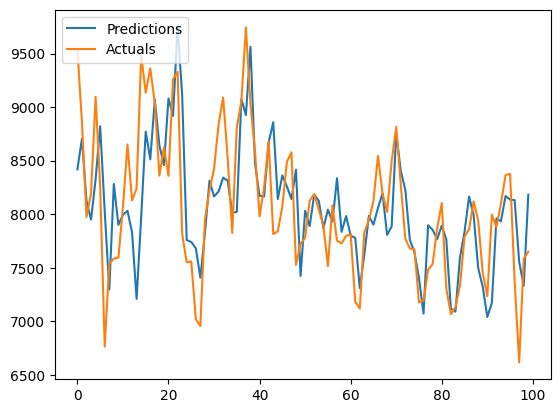

MAPE: 3.65%
RMSE: 381.69
MAE : 290.08


Predictions      Actuals
0    8418.053711  9537.097917
1    8704.744141  8863.333125
2    8123.149902  7973.787500
3    7949.151367  8194.981667
4    8326.880859  9096.434375
..           ...          ...
353  7970.879883  8447.030417
354  8225.155273  8771.408958
355  8247.920898  8487.014792
356  7797.265625  8380.489792
357  7713.509766  8437.980833

[358 rows x 2 columns]

In [84]:
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


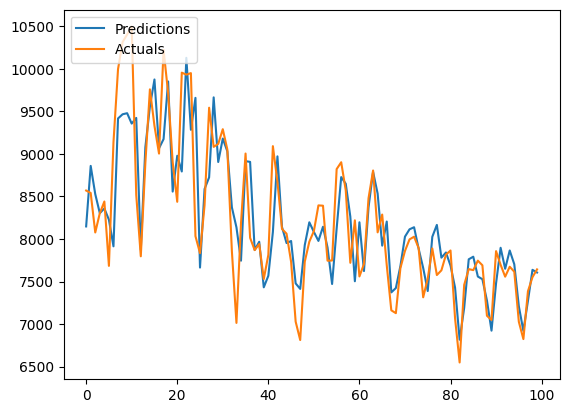

MAPE: 3.97%
RMSE: 416.18
MAE : 314.54


Predictions      Actuals
0    8147.725586  8569.568125
1    8859.112305  8540.904167
2    8527.676758  8076.513125
3    8304.068359  8302.971875
4    8358.707031  8440.820000
..           ...          ...
353  7905.253418  7508.199792
354  7938.287598  7694.271458
355  7864.209961  7746.240833
356  7741.767090  8321.401042
357  7702.824219  8503.726875

[358 rows x 2 columns]

In [85]:
predictions_plot(model11, X_test11, y_test11, 0, 100)

## Introduce Other Weather Features ##

## Model 12 - Precipitation ##

In [86]:
tempPrecipDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [87]:
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

i = X_train12.shape[1]
j = X_train12.shape[2]

In [88]:
model12 = Sequential()
model12.add(InputLayer((i, j)))
model12.add(LSTM(64))
model12.add(Dense(8, 'tanh'))
model12.add(Dense(1, 'linear'))

model12.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0951 - root_mean_squared_error: 0.3001 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1237
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1356 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0163 - root_mean_squared_error: 0.1277 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1192
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0167 - root_mean_squared_error: 0.1294 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1203
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0160 - root_mean_squared_error: 0.1263 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


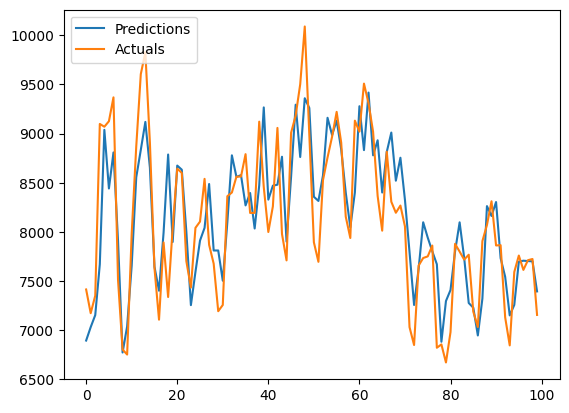

MAPE: 3.45%
RMSE: 375.14
MAE : 276.79


Predictions      Actuals
0    6892.700195  7412.811667
1    7029.410645  7171.183125
2    7151.923828  7350.264167
3    7669.634766  9098.258333
4    9038.355469  9070.002917
..           ...          ...
719  7980.483398  7374.332292
720  8230.267578  8039.583333
721  8306.107422  8575.767292
722  8045.977051  7909.507917
723  7364.320312  7144.386250

[724 rows x 2 columns]

In [90]:
model12 = load_model('model12.keras')

predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


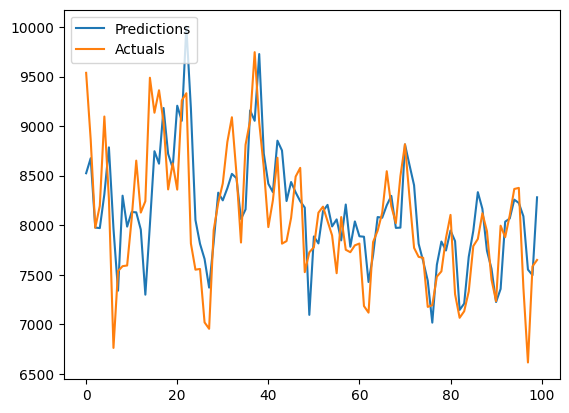

MAPE: 3.54%
RMSE: 371.12
MAE : 280.37


Predictions      Actuals
0    8524.112305  9537.097917
1    8675.795898  8863.333125
2    7975.896973  7973.787500
3    7970.574707  8194.981667
4    8312.913086  9096.434375
..           ...          ...
353  8104.812500  8447.030417
354  8402.088867  8771.408958
355  8430.984375  8487.014792
356  7991.477051  8380.489792
357  7894.939453  8437.980833

[358 rows x 2 columns]

In [91]:
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


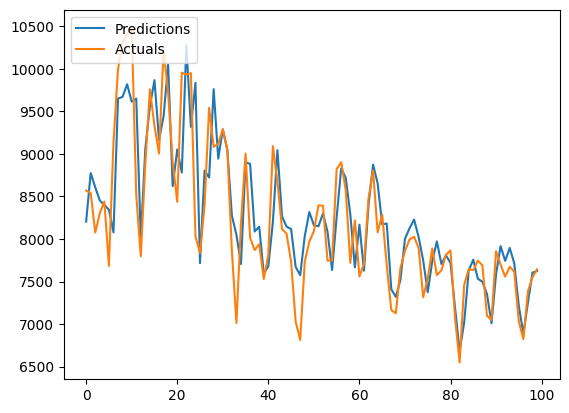

MAPE: 3.97%
RMSE: 409.06
MAE : 313.34


Predictions      Actuals
0    8205.157227  8569.568125
1    8775.178711  8540.904167
2    8607.236328  8076.513125
3    8452.484375  8302.971875
4    8400.263672  8440.820000
..           ...          ...
353  8077.893555  7508.199792
354  8129.283203  7694.271458
355  8096.638672  7746.240833
356  7978.221680  8321.401042
357  8023.437988  8503.726875

[358 rows x 2 columns]

In [92]:
predictions_plot(model12, X_test12, y_test12, 0, 100)

## Model 13 - Sunlight ##

In [93]:
tempSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [94]:
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

i = X_train13.shape[1]
j = X_train13.shape[2]

In [95]:
model13 = Sequential()
model13.add(InputLayer((i, j)))
model13.add(LSTM(64))
model13.add(Dense(8, 'tanh'))
model13.add(Dense(1, 'linear'))

model13.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,217 (75.07 KB)

 Trainable params: 19,217 (75.07 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1013 - root_mean_squared_error: 0.3080 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1175
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1155
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1214
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0153 - root_mean_squared_error: 0.1235 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0146 - root_mean_squared_error: 0.1209 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


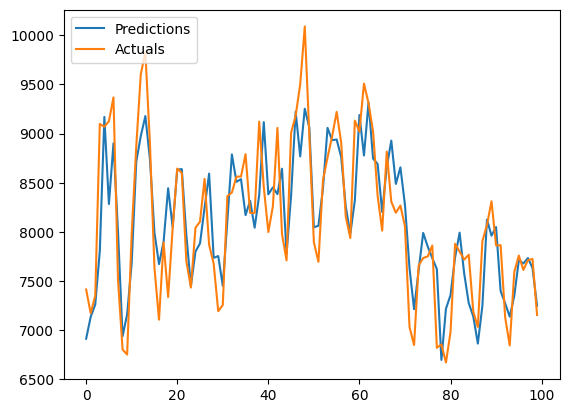

MAPE: 3.58%
RMSE: 387.29
MAE : 286.97


Predictions      Actuals
0    6911.426270  7412.811667
1    7134.239746  7171.183125
2    7259.440918  7350.264167
3    7804.224609  9098.258333
4    9169.221680  9070.002917
..           ...          ...
719  7717.282227  7374.332292
720  8150.638184  8039.583333
721  8108.854492  8575.767292
722  8025.791504  7909.507917
723  7266.775391  7144.386250

[724 rows x 2 columns]

In [97]:
model13 = load_model('model13.keras')
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


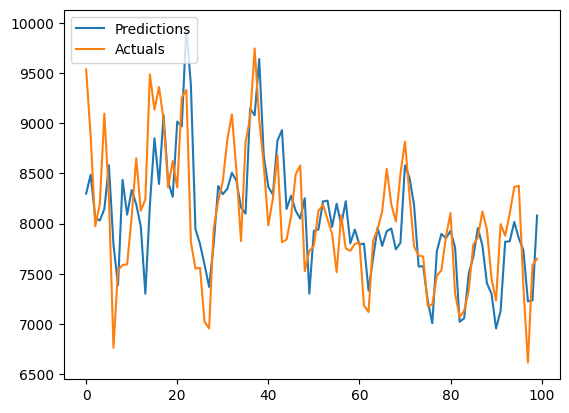

MAPE: 3.77%
RMSE: 391.25
MAE : 299.19


Predictions      Actuals
0    8297.708984  9537.097917
1    8487.703125  8863.333125
2    8055.560547  7973.787500
3    8029.815918  8194.981667
4    8145.074219  9096.434375
..           ...          ...
353  8202.730469  8447.030417
354  8525.842773  8771.408958
355  8522.148438  8487.014792
356  8095.476074  8380.489792
357  8020.609863  8437.980833

[358 rows x 2 columns]

In [98]:
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


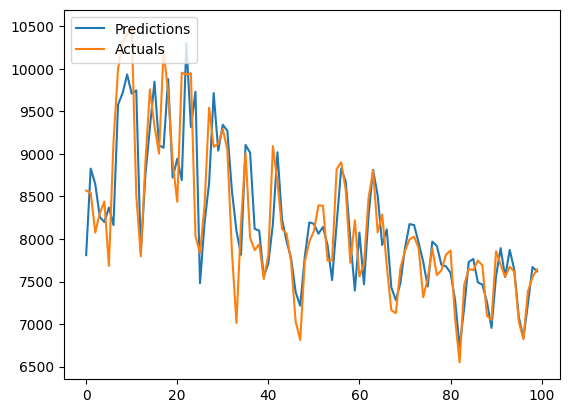

MAPE: 3.95%
RMSE: 412.23
MAE : 312.02


Predictions      Actuals
0    7810.062012  8569.568125
1    8827.223633  8540.904167
2    8647.025391  8076.513125
3    8258.773438  8302.971875
4    8199.965820  8440.820000
..           ...          ...
353  7900.215820  7508.199792
354  7999.603516  7694.271458
355  8117.525391  7746.240833
356  7906.274902  8321.401042
357  7966.416504  8503.726875

[358 rows x 2 columns]

In [99]:
predictions_plot(model13, X_test13, y_test13, 0, 100)

## Model 14 - Precipitation and Sunlight ##

In [100]:
tempPreSunDemandDF = test_df[['avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [101]:
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'avg_30_min_demand')

X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

i = X_train14.shape[1]
j = X_train14.shape[2]

In [102]:
model14 = Sequential()
model14.add(InputLayer((i, j)))
model14.add(LSTM(64))
model14.add(Dense(8, 'tanh'))
model14.add(Dense(1, 'linear'))

model14.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [103]:
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0487 - root_mean_squared_error: 0.2177 - val_loss: 0.0147 - val_root_mean_squared_error: 0.1213
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - root_mean_squared_error: 0.1427 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1238
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - root_mean_squared_error: 0.1325 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0165 - root_mean_squared_error: 0.1283 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


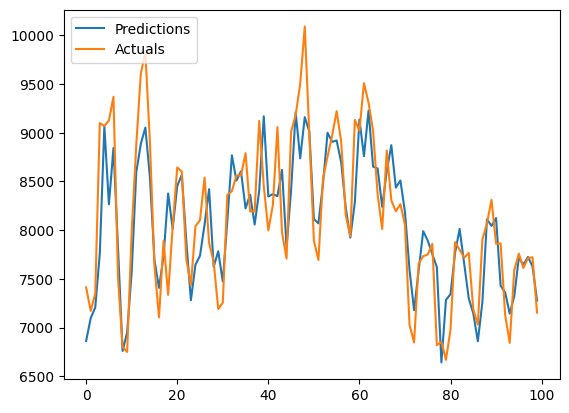

MAPE: 3.50%
RMSE: 383.08
MAE : 281.36


Predictions      Actuals
0    6863.477539  7412.811667
1    7097.074707  7171.183125
2    7207.229980  7350.264167
3    7761.098633  9098.258333
4    9066.513672  9070.002917
..           ...          ...
719  7763.375000  7374.332292
720  8246.539062  8039.583333
721  8191.080078  8575.767292
722  7955.443848  7909.507917
723  7326.154297  7144.386250

[724 rows x 2 columns]

In [104]:
model14 = load_model('model14.keras')

predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


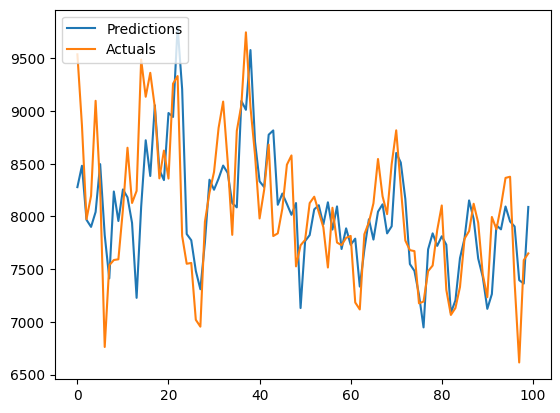

MAPE: 3.58%
RMSE: 373.79
MAE : 284.33


Predictions      Actuals
0    8277.557617  9537.097917
1    8480.264648  8863.333125
2    7967.690918  7973.787500
3    7900.580078  8194.981667
4    8042.273926  9096.434375
..           ...          ...
353  8227.854492  8447.030417
354  8505.579102  8771.408958
355  8396.469727  8487.014792
356  7909.343750  8380.489792
357  7856.172363  8437.980833

[358 rows x 2 columns]

In [105]:
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


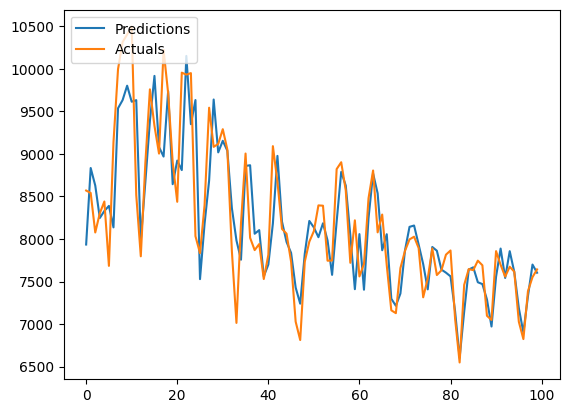

MAPE: 3.91%
RMSE: 405.48
MAE : 308.36


Predictions      Actuals
0    7935.049805  8569.568125
1    8834.167969  8540.904167
2    8628.388672  8076.513125
3    8246.847656  8302.971875
4    8329.402344  8440.820000
..           ...          ...
353  8086.378418  7508.199792
354  8126.464355  7694.271458
355  8175.063965  7746.240833
356  7966.311035  8321.401042
357  7902.265137  8503.726875

[358 rows x 2 columns]

In [106]:
predictions_plot(model14, X_test14, y_test14, 0, 100)

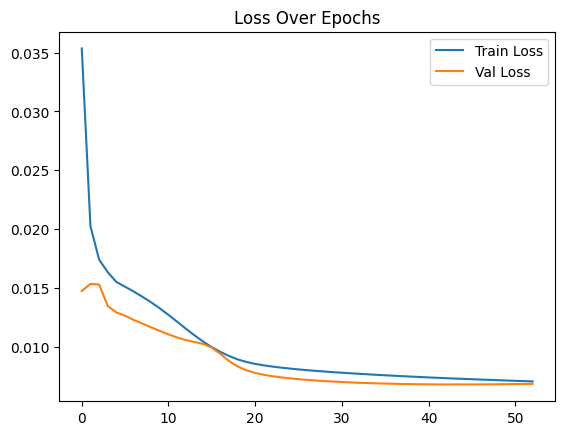

In [107]:
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## Seasonality ##

## Seasons ##

In [108]:
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [109]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

i = X_train15.shape[1]
j = X_train15.shape[2]

In [110]:
model15 = Sequential()
model15.add(InputLayer((i, j)))
model15.add(LSTM(64))
model15.add(Dense(8, 'tanh'))
model15.add(Dense(1, 'linear'))

model15.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [111]:
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.2117 - root_mean_squared_error: 0.4423 - val_loss: 0.0219 - val_root_mean_squared_error: 0.1478
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0206 - root_mean_squared_error: 0.1434 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1194
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0173 - root_mean_squared_error: 0.1314 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1196
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0169 - root_mean_squared_error: 0.1301 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1144
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


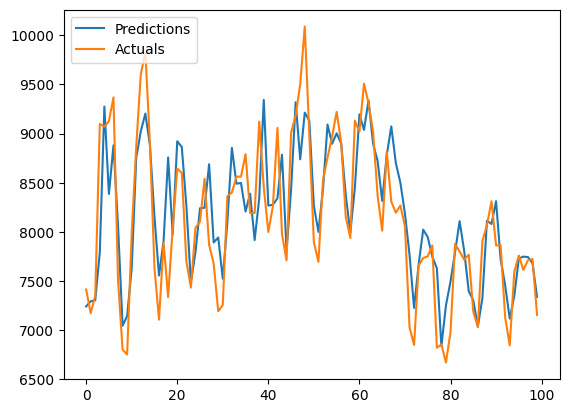

MAPE: 3.48%
RMSE: 383.01
MAE : 279.20


Predictions      Actuals
0    7239.714355  7412.811667
1    7292.320312  7171.183125
2    7303.228516  7350.264167
3    7791.876953  9098.258333
4    9275.777344  9070.002917
..           ...          ...
719  7961.975098  7374.332292
720  8321.798828  8039.583333
721  8311.293945  8575.767292
722  8197.125000  7909.507917
723  7300.143555  7144.386250

[724 rows x 2 columns]

In [112]:
model15 = load_model('model15.keras')

predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


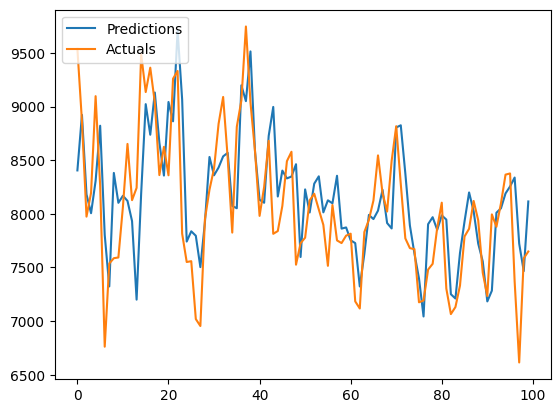

MAPE: 3.55%
RMSE: 376.00
MAE : 281.17


Predictions      Actuals
0    8404.458008  9537.097917
1    8921.769531  8863.333125
2    8181.398926  7973.787500
3    8005.494629  8194.981667
4    8307.101562  9096.434375
..           ...          ...
353  8182.039551  8447.030417
354  8474.655273  8771.408958
355  8321.688477  8487.014792
356  7783.746094  8380.489792
357  7684.724609  8437.980833

[358 rows x 2 columns]

In [113]:
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


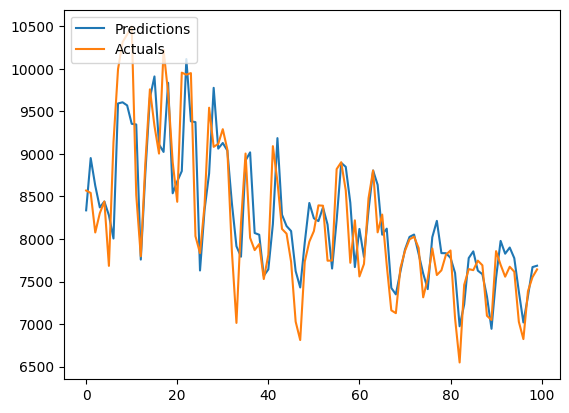

MAPE: 3.76%
RMSE: 395.42
MAE : 297.18


Predictions      Actuals
0    8336.769531  8569.568125
1    8951.176758  8540.904167
2    8626.966797  8076.513125
3    8371.434570  8302.971875
4    8440.533203  8440.820000
..           ...          ...
353  8032.546875  7508.199792
354  8075.545410  7694.271458
355  8046.035156  7746.240833
356  7909.362793  8321.401042
357  7943.028809  8503.726875

[358 rows x 2 columns]

In [114]:
predictions_plot(model15, X_test15, y_test15, 0, 100)

## Weekday/Weekend ##

In [115]:
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [116]:
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

i = X_train16.shape[1]
j = X_train16.shape[2]

In [117]:
model16 = Sequential()
model16.add(InputLayer((7, 9)))
model16.add(LSTM(64))
model16.add(Dense(8, 'tanh'))
model16.add(Dense(1, 'linear'))

model16.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [118]:
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1146 - root_mean_squared_error: 0.3284 - val_loss: 0.0223 - val_root_mean_squared_error: 0.1493
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0237 - root_mean_squared_error: 0.1539 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0155 - root_mean_squared_error: 0.1244 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0141 - root_mean_squared_error: 0.1185 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117 - val_loss: 0.0106 - val_root_mean_squared_error: 0.1027
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


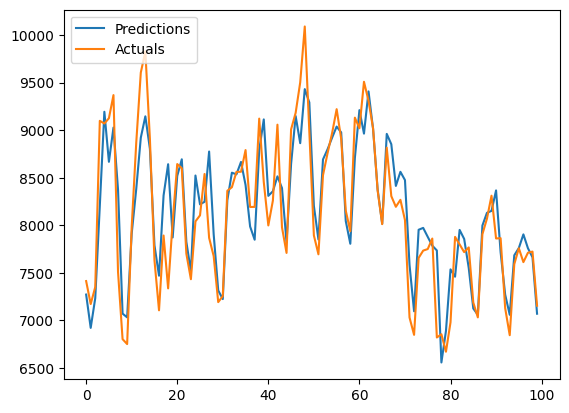

MAPE: 2.89%
RMSE: 330.79
MAE : 231.67


Predictions      Actuals
0    7270.894043  7412.811667
1    6920.504883  7171.183125
2    7232.882324  7350.264167
3    8204.048828  9098.258333
4    9193.588867  9070.002917
..           ...          ...
719  7415.769043  7374.332292
720  7873.762695  8039.583333
721  8109.227539  8575.767292
722  7809.052734  7909.507917
723  7366.506836  7144.386250

[724 rows x 2 columns]

In [119]:
model16 = load_model('model16.keras')

predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


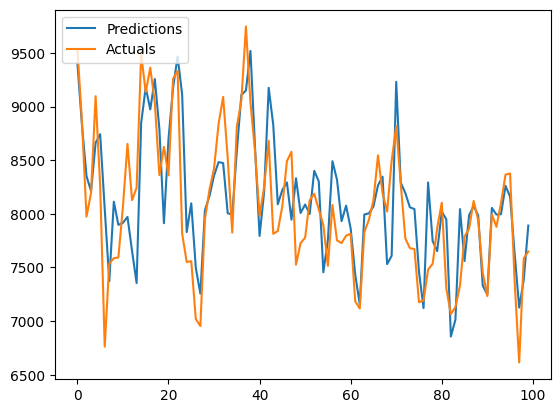

MAPE: 3.07%
RMSE: 333.42
MAE : 242.42


Predictions      Actuals
0    9406.627930  9537.097917
1    8828.182617  8863.333125
2    8350.302734  7973.787500
3    8212.813477  8194.981667
4    8662.150391  9096.434375
..           ...          ...
353  7666.833984  8447.030417
354  8075.187012  8771.408958
355  7698.900391  8487.014792
356  7645.950684  8380.489792
357  8578.211914  8437.980833

[358 rows x 2 columns]

In [120]:
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


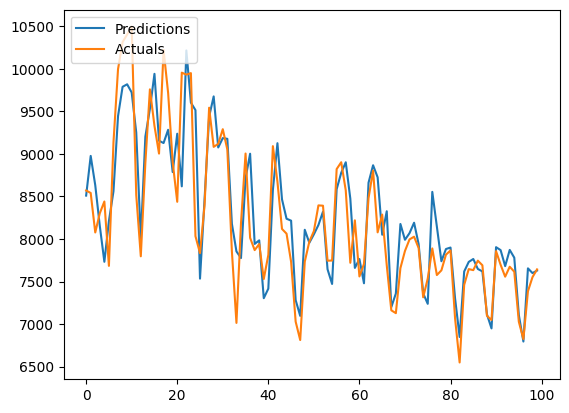

MAPE: 3.28%
RMSE: 356.60
MAE : 259.93


Predictions      Actuals
0    8510.056641  8569.568125
1    8976.459961  8540.904167
2    8632.141602  8076.513125
3    8152.750977  8302.971875
4    7732.141602  8440.820000
..           ...          ...
353  7392.235840  7508.199792
354  7089.452148  7694.271458
355  7578.414062  7746.240833
356  8451.459961  8321.401042
357  8384.525391  8503.726875

[358 rows x 2 columns]

In [121]:
predictions_plot(model16, X_test16, y_test16, 0, 100)

## Day Of Week ##

In [122]:
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [123]:
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

i = X_train17.shape[1]
j = X_train17.shape[2]

In [124]:
model17 = Sequential()
model17.add(InputLayer((i, j)))
model17.add(LSTM(64))
model17.add(Dense(8, 'tanh'))
model17.add(Dense(1, 'linear'))

model17.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 64)             │        20,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,753 (81.07 KB)

 Trainable params: 20,753 (81.07 KB)

 Non-trainable params: 0 (0.00 B)

In [125]:
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0635 - root_mean_squared_error: 0.2462 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0103 - val_root_mean_squared_error: 0.1016
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0107 - root_mean_squared_error: 0.1033 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0089 - root_mean_squared_error: 0.0944 - val_loss: 0.0084 - val_root_mean_squared_error: 0.0919
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0899
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


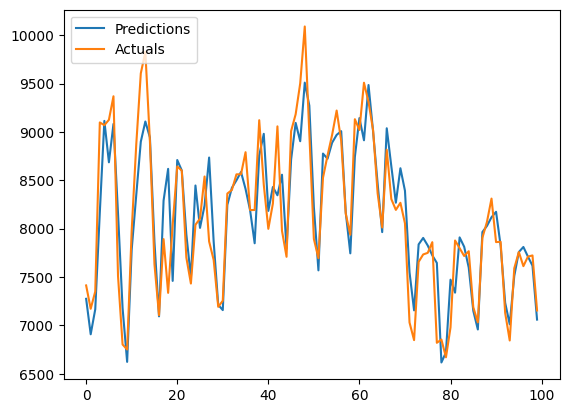

MAPE: 2.55%
RMSE: 295.71
MAE : 205.03


Predictions      Actuals
0    7274.272461  7412.811667
1    6907.706543  7171.183125
2    7166.194336  7350.264167
3    8166.794922  9098.258333
4    9114.317383  9070.002917
..           ...          ...
719  7031.647461  7374.332292
720  7930.357910  8039.583333
721  7873.387207  8575.767292
722  7816.362793  7909.507917
723  7253.661621  7144.386250

[724 rows x 2 columns]

In [126]:
model17 = load_model('model17.keras')

predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


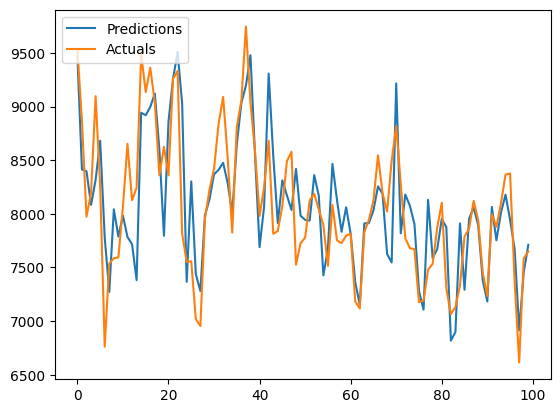

MAPE: 2.89%
RMSE: 318.49
MAE : 229.39


Predictions      Actuals
0    9469.126953  9537.097917
1    8413.356445  8863.333125
2    8396.745117  7973.787500
3    8084.013672  8194.981667
4    8315.384766  9096.434375
..           ...          ...
353  7571.688477  8447.030417
354  8004.878418  8771.408958
355  7854.563965  8487.014792
356  7577.743652  8380.489792
357  8616.453125  8437.980833

[358 rows x 2 columns]

In [127]:
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


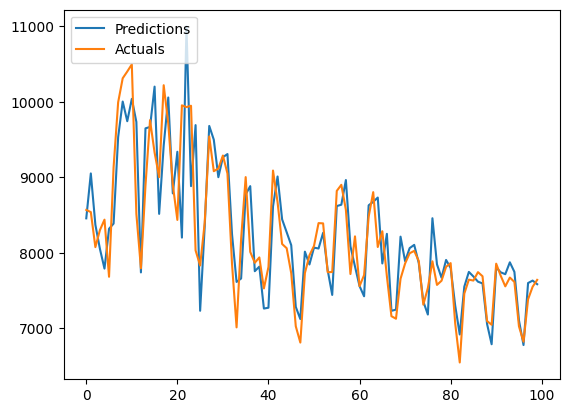

MAPE: 3.22%
RMSE: 356.88
MAE : 257.23


Predictions      Actuals
0    8458.236328  8569.568125
1    9053.054688  8540.904167
2    8372.720703  8076.513125
3    8053.187988  8302.971875
4    7792.148438  8440.820000
..           ...          ...
353  7185.975586  7508.199792
354  7033.676270  7694.271458
355  7479.188965  7746.240833
356  8510.926758  8321.401042
357  8057.172852  8503.726875

[358 rows x 2 columns]

In [128]:
predictions_plot(model17, X_test17, y_test17, 0, 100)

## Month ##

In [129]:
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [130]:
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

i = X_train18.shape[1]
j = X_train18.shape[2]

In [131]:
model18 = Sequential()
model18.add(InputLayer((i, j)))
model18.add(LSTM(64))
model18.add(Dense(8, 'tanh'))
model18.add(Dense(1, 'linear'))

model18.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,033 (86.07 KB)

 Trainable params: 22,033 (86.07 KB)

 Non-trainable params: 0 (0.00 B)

In [132]:
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.1175 - root_mean_squared_error: 0.3319 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1141
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1287 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1118
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1250 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1113
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0158 - root_mean_squared_error: 0.1255 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0154 - root_mean_squared_error: 0.1238 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1122
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


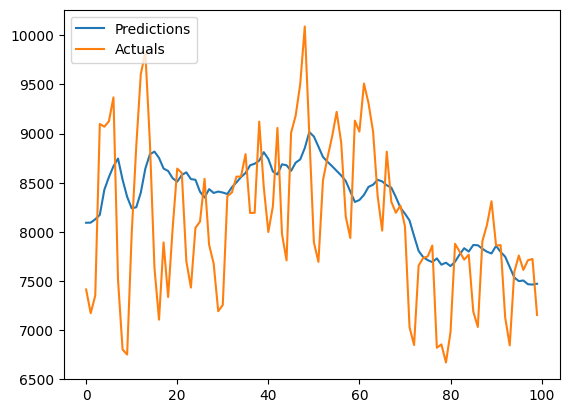

MAPE: 5.49%
RMSE: 567.23
MAE : 431.46


Predictions      Actuals
0    8092.173828  7412.811667
1    8093.504883  7171.183125
2    8127.463867  7350.264167
3    8172.703125  9098.258333
4    8428.973633  9070.002917
..           ...          ...
719  7967.113281  7374.332292
720  7948.796387  8039.583333
721  8009.464355  8575.767292
722  8129.513672  7909.507917
723  8175.442871  7144.386250

[724 rows x 2 columns]

In [133]:
model18 = load_model('model18.keras')

predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


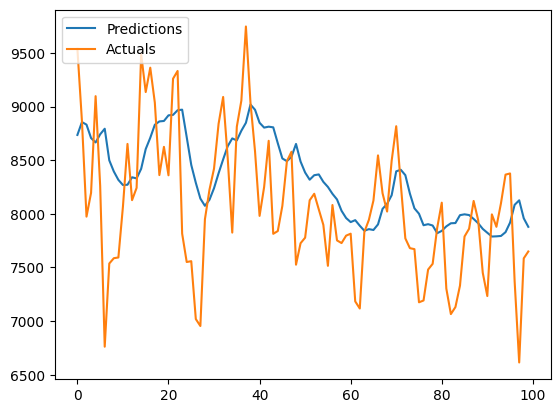

MAPE: 5.06%
RMSE: 502.17
MAE : 392.15


Predictions      Actuals
0    8734.970703  9537.097917
1    8855.014648  8863.333125
2    8831.125977  7973.787500
3    8706.025391  8194.981667
4    8664.820312  9096.434375
..           ...          ...
353  7836.710449  8447.030417
354  7924.620117  8771.408958
355  8100.211426  8487.014792
356  8217.578125  8380.489792
357  8295.109375  8437.980833

[358 rows x 2 columns]

In [134]:
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


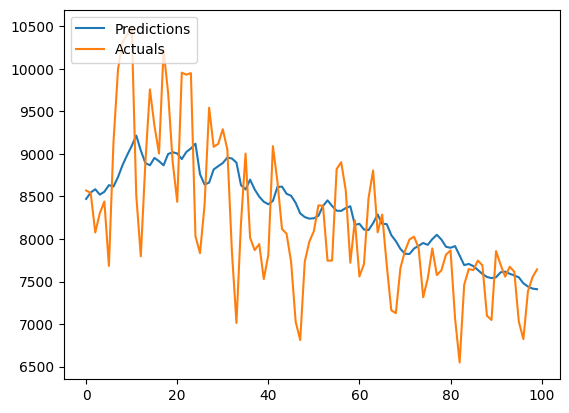

MAPE: 5.58%
RMSE: 563.99
MAE : 432.30


Predictions      Actuals
0    8470.929688  8569.568125
1    8546.413086  8540.904167
2    8584.892578  8076.513125
3    8521.385742  8302.971875
4    8555.086914  8440.820000
..           ...          ...
353  7964.843750  7508.199792
354  8012.371582  7694.271458
355  8065.254395  7746.240833
356  8106.316895  8321.401042
357  8170.211914  8503.726875

[358 rows x 2 columns]

In [135]:
predictions_plot(model18, X_test18, y_test18, 0, 100)

## Seasons & Weekday/Weekend ##

In [136]:
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','avg_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [137]:
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

i = X_train19.shape[1]
j = X_train19.shape[2]

In [138]:
model19 = Sequential()
model19.add(InputLayer((i, j)))
model19.add(LSTM(64))
model19.add(Dense(8, 'tanh'))
model19.add(Dense(1, 'linear'))

model19.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [139]:
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0583 - root_mean_squared_error: 0.2344 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1069
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1071
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213 - val_loss: 0.0114 - val_root_mean_squared_error: 0.1066
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0979
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0114 - root_mean_squared_error: 0.1068 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0910
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0080 - val_root_mean_squared_error: 0.0894
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


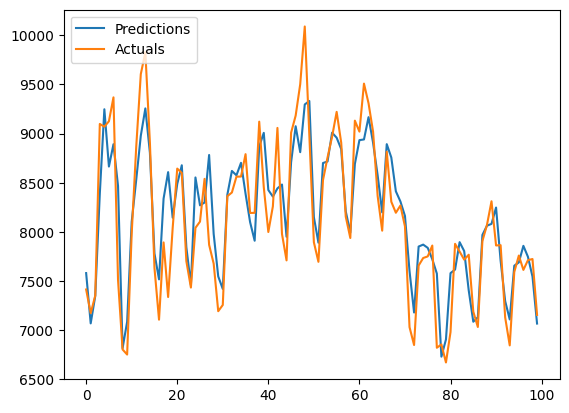

MAPE: 3.03%
RMSE: 348.22
MAE : 243.08


Predictions      Actuals
0    7579.675781  7412.811667
1    7067.594727  7171.183125
2    7346.501465  7350.264167
3    8387.701172  9098.258333
4    9247.878906  9070.002917
..           ...          ...
719  7668.270508  7374.332292
720  8097.412598  8039.583333
721  8109.053711  8575.767292
722  7935.824219  7909.507917
723  7483.750488  7144.386250

[724 rows x 2 columns]

In [140]:
model19 = load_model('model19.keras')

predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


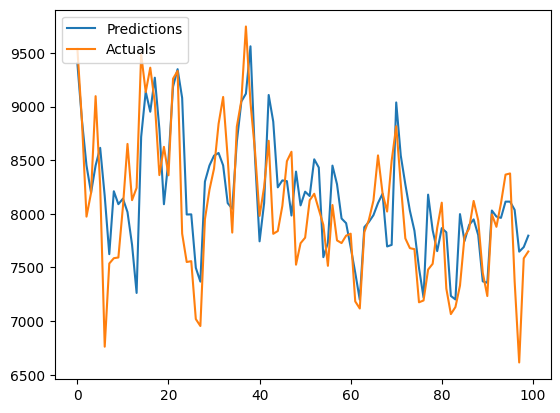

MAPE: 3.22%
RMSE: 346.88
MAE : 253.50


Predictions      Actuals
0    9400.283203  9537.097917
1    8871.676758  8863.333125
2    8450.034180  7973.787500
3    8196.843750  8194.981667
4    8450.598633  9096.434375
..           ...          ...
353  7934.729492  8447.030417
354  7999.536133  8771.408958
355  7864.353516  8487.014792
356  7624.432617  8380.489792
357  8593.272461  8437.980833

[358 rows x 2 columns]

In [141]:
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


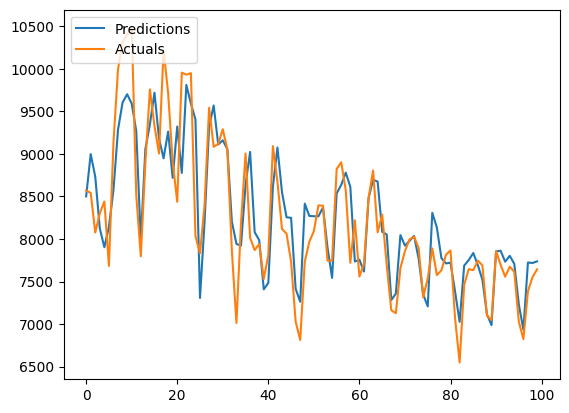

MAPE: 3.46%
RMSE: 374.85
MAE : 273.11


Predictions      Actuals
0    8500.383789  8569.568125
1    8997.928711  8540.904167
2    8732.715820  8076.513125
3    8124.110840  8302.971875
4    7903.128418  8440.820000
..           ...          ...
353  7629.454590  7508.199792
354  7219.189941  7694.271458
355  7445.475098  7746.240833
356  8344.442383  8321.401042
357  8410.456055  8503.726875

[358 rows x 2 columns]

In [142]:
predictions_plot(model19, X_test19, y_test19, 0, 100)

## Switch to train/test only - compare Seasons & Seasons/Weekend ##

## Seasons & Weekday/Weekend - Train/Test ##

In [143]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

i = X_train20.shape[1]
j = X_train20.shape[2]

In [144]:
model20 = Sequential()
model20.add(InputLayer((i, j)))
model20.add(LSTM(64))
model20.add(Dense(8, 'tanh'))
model20.add(Dense(1, 'linear'))

model20.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 64)             │        19,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,497 (80.07 KB)

 Trainable params: 20,497 (80.07 KB)

 Non-trainable params: 0 (0.00 B)

In [145]:
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0415 - root_mean_squared_error: 0.1989
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1131
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0979
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0086 - root_mean_squared_error: 0.0930
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0084 - root_mean_squared_error: 0.0915
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0081 - root_mean_squared_error: 0.0901

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


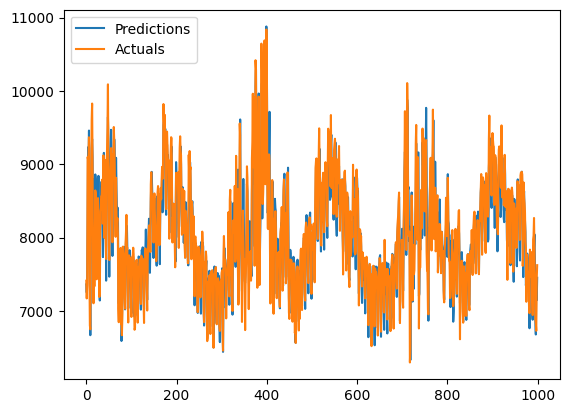

MAPE: 2.41%
RMSE: 273.94
MAE : 193.74


Predictions      Actuals
0     7362.998535  7412.811667
1     7251.895996  7171.183125
2     7370.237305  7350.264167
3     8166.618652  9098.258333
4     9231.840820  9070.002917
...           ...          ...
1084  8151.949707  8447.030417
1085  8927.948242  8771.408958
1086  8235.333008  8487.014792
1087  8044.871582  8380.489792
1088  8278.207031  8437.980833

[1089 rows x 2 columns]

In [146]:
model20 = load_model('model20.keras')

predictions_plot(model20, X_train20, y_train20, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


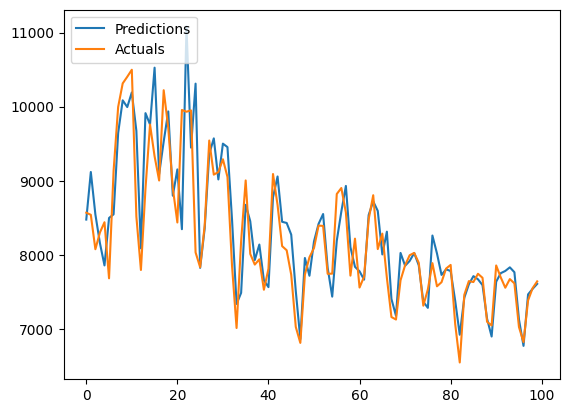

MAPE: 2.98%
RMSE: 350.86
MAE : 239.07


Predictions      Actuals
0    8476.699219  8569.568125
1    9118.480469  8540.904167
2    8546.083008  8076.513125
3    8158.314941  8302.971875
4    7858.093750  8440.820000
..           ...          ...
353  7563.966309  7508.199792
354  7718.552246  7694.271458
355  8141.063477  7746.240833
356  8462.814453  8321.401042
357  7943.868164  8503.726875

[358 rows x 2 columns]

In [147]:
predictions_plot(model20, X_test20, y_test20, 0, 100)

## Seasons Only - Train/Test ##

In [148]:
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

i = X_train21.shape[1]
j = X_train21.shape[2]

In [149]:
model21 = Sequential()
model21.add(InputLayer((i, j)))
model21.add(LSTM(64))
model21.add(Dense(8, 'tanh'))
model21.add(Dense(1, 'linear'))

model21.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                  │ (None, 64)             │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,985 (78.07 KB)

 Trainable params: 19,985 (78.07 KB)

 Non-trainable params: 0 (0.00 B)

In [150]:
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0564 - root_mean_squared_error: 0.2304
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - root_mean_squared_error: 0.1169
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0133 - root_mean_squared_error: 0.1155
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0130 - root_mean_squared_error: 0.1142
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - root_mean_squared_error: 0.1129
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0125 - root_mean_squared_error: 0.1117
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0122 - root_mean_squared_error: 0.1105
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


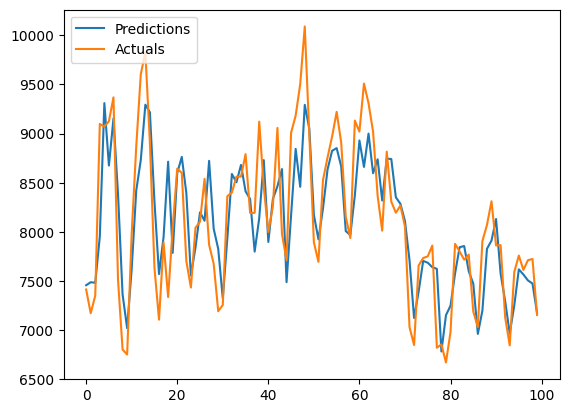

MAPE: 3.16%
RMSE: 346.46
MAE : 254.86


Predictions      Actuals
0     7455.869629  7412.811667
1     7486.606445  7171.183125
2     7480.996582  7350.264167
3     7951.705078  9098.258333
4     9310.348633  9070.002917
...           ...          ...
1084  8077.810059  8447.030417
1085  8610.664062  8771.408958
1086  8658.567383  8487.014792
1087  8096.859375  8380.489792
1088  8000.162109  8437.980833

[1089 rows x 2 columns]

In [151]:
model21 = load_model('model21.keras')
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


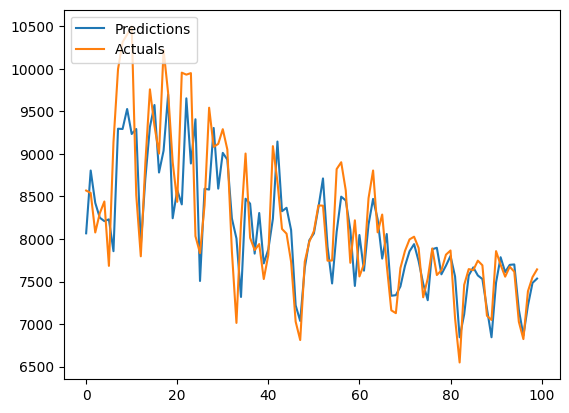

MAPE: 3.59%
RMSE: 393.38
MAE : 286.03


Predictions      Actuals
0    8066.963379  8569.568125
1    8804.800781  8540.904167
2    8424.416992  8076.513125
3    8250.312500  8302.971875
4    8210.250977  8440.820000
..           ...          ...
353  7887.324707  7508.199792
354  7991.499512  7694.271458
355  8003.070312  7746.240833
356  7828.642090  8321.401042
357  8114.896484  8503.726875

[358 rows x 2 columns]

In [152]:
predictions_plot(model21, X_test21, y_test21, 0, 100)

## Weekend/Weekday Only - Train/Test ##

In [153]:
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

i = X_train22.shape[1]
j = X_train22.shape[2]

In [154]:
model22 = Sequential()
model22.add(InputLayer((i, j)))
model22.add(LSTM(64))
model22.add(Dense(8, 'tanh'))
model22.add(Dense(1, 'linear'))

model22.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 64)             │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,473 (76.07 KB)

 Trainable params: 19,473 (76.07 KB)

 Non-trainable params: 0 (0.00 B)

In [155]:
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0305 - root_mean_squared_error: 0.1726
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - root_mean_squared_error: 0.1036
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0104 - root_mean_squared_error: 0.1018
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - root_mean_squared_error: 0.1003
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - root_mean_squared_error: 0.0987
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0958
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0089 - root_mean_squared_error: 0.0942

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


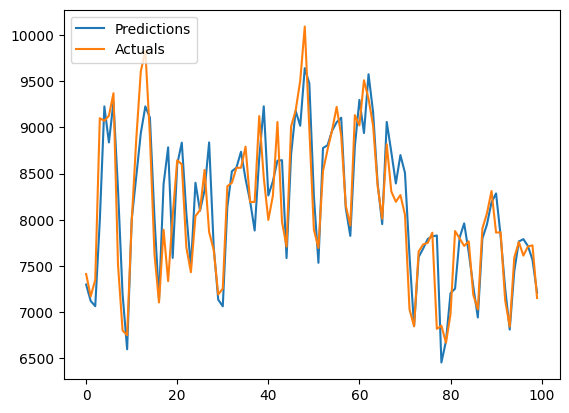

MAPE: 2.62%
RMSE: 293.17
MAE : 209.91


Predictions      Actuals
0     7298.708008  7412.811667
1     7121.543945  7171.183125
2     7064.842285  7350.264167
3     7992.520996  9098.258333
4     9226.223633  9070.002917
...           ...          ...
1084  7669.705566  8447.030417
1085  8392.017578  8771.408958
1086  7934.156738  8487.014792
1087  7855.779785  8380.489792
1088  8334.103516  8437.980833

[1089 rows x 2 columns]

In [156]:
model22 = load_model('model22.keras')

predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


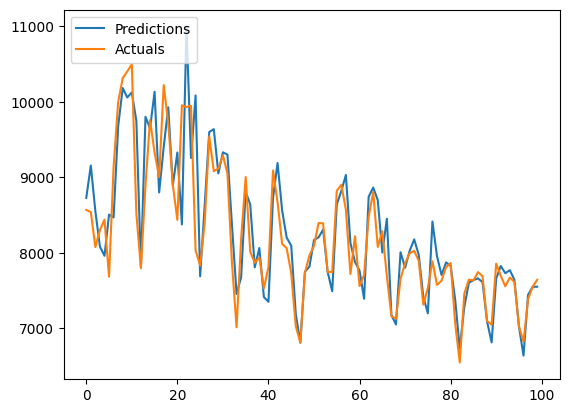

MAPE: 2.94%
RMSE: 339.13
MAE : 234.80


Predictions      Actuals
0    8729.188477  8569.568125
1    9156.583008  8540.904167
2    8550.935547  8076.513125
3    8083.314941  8302.971875
4    7961.772461  8440.820000
..           ...          ...
353  7379.405273  7508.199792
354  7414.115234  7694.271458
355  7768.844238  7746.240833
356  8443.686523  8321.401042
357  8143.458496  8503.726875

[358 rows x 2 columns]

In [157]:
predictions_plot(model22, X_test22, y_test22, 0, 100)

## Optuna Trials ##

In [159]:
'''study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study.optimize(objective, n_trials=100)

[I 2025-09-20 06:43:09,062] A new study created in memory with name: no-name-9961cc98-782b-4ab5-aefc-5431eb140be2
[I 2025-09-20 06:43:29,229] Trial 0 finished with value: 244.97360799285102 and parameters: {'n_units': 8, 'dropout': 0.017425083650459836, 'learning_rate': 0.005399484409787433, 'batch_size': 32}. Best is trial 0 with value: 244.97360799285102.


Trial 0: units=8, dropout=0.02, lr=0.00540, batch=32, MAE=244.97, device=/GPU:0


[I 2025-09-20 06:49:41,399] Trial 1 finished with value: 344.73165082798687 and parameters: {'n_units': 1, 'dropout': 0.12958350559263473, 'learning_rate': 0.0003823475224675188, 'batch_size': 1}. Best is trial 0 with value: 244.97360799285102.


Trial 1: units=1, dropout=0.13, lr=0.00038, batch=1, MAE=344.73, device=/GPU:0


[I 2025-09-20 06:50:14,200] Trial 2 finished with value: 365.1330282331097 and parameters: {'n_units': 8, 'dropout': 0.1822634555704315, 'learning_rate': 0.00021930485556643703, 'batch_size': 16}. Best is trial 0 with value: 244.97360799285102.


Trial 2: units=8, dropout=0.18, lr=0.00022, batch=16, MAE=365.13, device=/GPU:0


[I 2025-09-20 06:51:13,550] Trial 3 finished with value: 285.8237205098883 and parameters: {'n_units': 16, 'dropout': 0.010316556334565519, 'learning_rate': 0.006586289317583112, 'batch_size': 8}. Best is trial 0 with value: 244.97360799285102.


Trial 3: units=16, dropout=0.01, lr=0.00659, batch=8, MAE=285.82, device=/GPU:0


[I 2025-09-20 06:51:32,664] Trial 4 finished with value: 282.55275415846125 and parameters: {'n_units': 16, 'dropout': 0.17936999364332554, 'learning_rate': 0.0069782812651260325, 'batch_size': 32}. Best is trial 0 with value: 244.97360799285102.


Trial 4: units=16, dropout=0.18, lr=0.00698, batch=32, MAE=282.55, device=/GPU:0


[I 2025-09-20 06:52:33,352] Trial 5 finished with value: 255.71724324447925 and parameters: {'n_units': 16, 'dropout': 0.04227726749242879, 'learning_rate': 0.0040215545266902904, 'batch_size': 8}. Best is trial 0 with value: 244.97360799285102.


Trial 5: units=16, dropout=0.04, lr=0.00402, batch=8, MAE=255.72, device=/GPU:0


[I 2025-09-20 06:58:58,740] Trial 6 finished with value: 293.572776908379 and parameters: {'n_units': 8, 'dropout': 0.10753971856328177, 'learning_rate': 0.0001705053926026929, 'batch_size': 1}. Best is trial 0 with value: 244.97360799285102.


Trial 6: units=8, dropout=0.11, lr=0.00017, batch=1, MAE=293.57, device=/GPU:0


[I 2025-09-20 06:59:31,598] Trial 7 finished with value: 272.82289808359474 and parameters: {'n_units': 64, 'dropout': 0.035878273781490506, 'learning_rate': 0.0026698666742744613, 'batch_size': 16}. Best is trial 0 with value: 244.97360799285102.


Trial 7: units=64, dropout=0.04, lr=0.00267, batch=16, MAE=272.82, device=/GPU:0


[I 2025-09-20 07:05:48,790] Trial 8 finished with value: 300.6646911628237 and parameters: {'n_units': 128, 'dropout': 0.094306794322898, 'learning_rate': 0.0010402587615883842, 'batch_size': 1}. Best is trial 0 with value: 244.97360799285102.


Trial 8: units=128, dropout=0.09, lr=0.00104, batch=1, MAE=300.66, device=/GPU:0


[I 2025-09-20 07:06:21,251] Trial 9 finished with value: 340.7302490267478 and parameters: {'n_units': 64, 'dropout': 0.19002112695312703, 'learning_rate': 0.005532496914298506, 'batch_size': 16}. Best is trial 0 with value: 244.97360799285102.


Trial 9: units=64, dropout=0.19, lr=0.00553, batch=16, MAE=340.73, device=/GPU:0


[I 2025-09-20 07:06:40,486] Trial 10 finished with value: 326.3381236193084 and parameters: {'n_units': 32, 'dropout': 0.2290179149331798, 'learning_rate': 0.001492907534774569, 'batch_size': 32}. Best is trial 0 with value: 244.97360799285102.


Trial 10: units=32, dropout=0.23, lr=0.00149, batch=32, MAE=326.34, device=/GPU:0


[I 2025-09-20 07:07:40,882] Trial 11 finished with value: 266.64639052410223 and parameters: {'n_units': 8, 'dropout': 0.05909129349536822, 'learning_rate': 0.0029721949373644227, 'batch_size': 8}. Best is trial 0 with value: 244.97360799285102.


Trial 11: units=8, dropout=0.06, lr=0.00297, batch=8, MAE=266.65, device=/GPU:0


[I 2025-09-20 07:08:00,054] Trial 12 finished with value: 363.5244735452361 and parameters: {'n_units': 16, 'dropout': 0.2902495045654139, 'learning_rate': 0.002733762389478879, 'batch_size': 32}. Best is trial 0 with value: 244.97360799285102.


Trial 12: units=16, dropout=0.29, lr=0.00273, batch=32, MAE=363.52, device=/GPU:0


[I 2025-09-20 07:08:57,919] Trial 13 finished with value: 342.5338024198347 and parameters: {'n_units': 1, 'dropout': 0.06437930990626889, 'learning_rate': 0.009768747066437562, 'batch_size': 8}. Best is trial 0 with value: 244.97360799285102.


Trial 13: units=1, dropout=0.06, lr=0.00977, batch=8, MAE=342.53, device=/GPU:0


[I 2025-09-20 07:09:57,448] Trial 14 finished with value: 227.48499709574122 and parameters: {'n_units': 32, 'dropout': 0.002449629697168873, 'learning_rate': 0.0005558852604488685, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 14: units=32, dropout=0.00, lr=0.00056, batch=8, MAE=227.48, device=/GPU:0


[I 2025-09-20 07:10:16,602] Trial 15 finished with value: 243.49614086612772 and parameters: {'n_units': 32, 'dropout': 0.002051675210782303, 'learning_rate': 0.000487672463795626, 'batch_size': 32}. Best is trial 14 with value: 227.48499709574122.


Trial 15: units=32, dropout=0.00, lr=0.00049, batch=32, MAE=243.50, device=/GPU:0


[I 2025-09-20 07:11:16,464] Trial 16 finished with value: 244.95139412223926 and parameters: {'n_units': 32, 'dropout': 0.09128527663339259, 'learning_rate': 0.00041719766273268596, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 16: units=32, dropout=0.09, lr=0.00042, batch=8, MAE=244.95, device=/GPU:0


[I 2025-09-20 07:11:35,577] Trial 17 finished with value: 266.5688709884951 and parameters: {'n_units': 32, 'dropout': 0.0008857641265528802, 'learning_rate': 0.00046030292704642405, 'batch_size': 32}. Best is trial 14 with value: 227.48499709574122.


Trial 17: units=32, dropout=0.00, lr=0.00046, batch=32, MAE=266.57, device=/GPU:0


[I 2025-09-20 07:11:54,809] Trial 18 finished with value: 246.71812006011137 and parameters: {'n_units': 32, 'dropout': 0.0711643640005604, 'learning_rate': 0.0007182615392813411, 'batch_size': 32}. Best is trial 14 with value: 227.48499709574122.


Trial 18: units=32, dropout=0.07, lr=0.00072, batch=32, MAE=246.72, device=/GPU:0


[I 2025-09-20 07:12:54,235] Trial 19 finished with value: 353.86263010467025 and parameters: {'n_units': 32, 'dropout': 0.28960138381963657, 'learning_rate': 0.00012877154153346335, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 19: units=32, dropout=0.29, lr=0.00013, batch=8, MAE=353.86, device=/GPU:0


[I 2025-09-20 07:13:55,618] Trial 20 finished with value: 279.09732239580933 and parameters: {'n_units': 128, 'dropout': 0.1270184481648476, 'learning_rate': 0.0013109833200274285, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 20: units=128, dropout=0.13, lr=0.00131, batch=8, MAE=279.10, device=/GPU:0


[I 2025-09-20 07:14:56,188] Trial 21 finished with value: 245.57143294578913 and parameters: {'n_units': 32, 'dropout': 0.08938337165662508, 'learning_rate': 0.00046864645231496285, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 21: units=32, dropout=0.09, lr=0.00047, batch=8, MAE=245.57, device=/GPU:0


[I 2025-09-20 07:15:56,065] Trial 22 finished with value: 267.14669763150204 and parameters: {'n_units': 32, 'dropout': 0.03481699550994418, 'learning_rate': 0.00029647491410151765, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 22: units=32, dropout=0.03, lr=0.00030, batch=8, MAE=267.15, device=/GPU:0


[I 2025-09-20 07:16:55,519] Trial 23 finished with value: 232.4150092181177 and parameters: {'n_units': 32, 'dropout': 0.02541303890305295, 'learning_rate': 0.0007803442745204939, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 23: units=32, dropout=0.03, lr=0.00078, batch=8, MAE=232.42, device=/GPU:0


[I 2025-09-20 07:17:55,811] Trial 24 finished with value: 236.15577645467363 and parameters: {'n_units': 32, 'dropout': 0.0014162180089764172, 'learning_rate': 0.000670902209071907, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 24: units=32, dropout=0.00, lr=0.00067, batch=8, MAE=236.16, device=/GPU:0


[I 2025-09-20 07:18:55,171] Trial 25 finished with value: 230.0817165495401 and parameters: {'n_units': 32, 'dropout': 0.030222904944073356, 'learning_rate': 0.0007594329100026415, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 25: units=32, dropout=0.03, lr=0.00076, batch=8, MAE=230.08, device=/GPU:0


[I 2025-09-20 07:19:54,756] Trial 26 finished with value: 242.9322745592578 and parameters: {'n_units': 32, 'dropout': 0.0416472863813488, 'learning_rate': 0.0016362983934923685, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 26: units=32, dropout=0.04, lr=0.00164, batch=8, MAE=242.93, device=/GPU:0


[I 2025-09-20 07:20:54,040] Trial 27 finished with value: 244.72579397747216 and parameters: {'n_units': 32, 'dropout': 0.030738137459275592, 'learning_rate': 0.0008998183181876261, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 27: units=32, dropout=0.03, lr=0.00090, batch=8, MAE=244.73, device=/GPU:0


[I 2025-09-20 07:21:53,549] Trial 28 finished with value: 242.42464451055764 and parameters: {'n_units': 128, 'dropout': 0.04769352745458982, 'learning_rate': 0.0006377416472605398, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 28: units=128, dropout=0.05, lr=0.00064, batch=8, MAE=242.42, device=/GPU:0


[I 2025-09-20 07:22:51,273] Trial 29 finished with value: 343.3510688309837 and parameters: {'n_units': 1, 'dropout': 0.019374981935123506, 'learning_rate': 0.0002761611005626717, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 29: units=1, dropout=0.02, lr=0.00028, batch=8, MAE=343.35, device=/GPU:0


[I 2025-09-20 07:29:08,247] Trial 30 finished with value: 269.83327694577474 and parameters: {'n_units': 64, 'dropout': 0.07077492588299045, 'learning_rate': 0.0009554071522547883, 'batch_size': 1}. Best is trial 14 with value: 227.48499709574122.


Trial 30: units=64, dropout=0.07, lr=0.00096, batch=1, MAE=269.83, device=/GPU:0


[I 2025-09-20 07:30:07,979] Trial 31 finished with value: 232.04069340841858 and parameters: {'n_units': 32, 'dropout': 0.019422933125563552, 'learning_rate': 0.0006845738208689009, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 31: units=32, dropout=0.02, lr=0.00068, batch=8, MAE=232.04, device=/GPU:0


[I 2025-09-20 07:31:07,293] Trial 32 finished with value: 252.12456226695903 and parameters: {'n_units': 32, 'dropout': 0.027028559934241747, 'learning_rate': 0.001790750095744587, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 32: units=32, dropout=0.03, lr=0.00179, batch=8, MAE=252.12, device=/GPU:0


[I 2025-09-20 07:32:06,257] Trial 33 finished with value: 243.3611577738995 and parameters: {'n_units': 32, 'dropout': 0.017218375054242084, 'learning_rate': 0.00031047786680090013, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 33: units=32, dropout=0.02, lr=0.00031, batch=8, MAE=243.36, device=/GPU:0


[I 2025-09-20 07:32:38,922] Trial 34 finished with value: 242.36304730880627 and parameters: {'n_units': 32, 'dropout': 0.058143082089718565, 'learning_rate': 0.0005973923876964147, 'batch_size': 16}. Best is trial 14 with value: 227.48499709574122.


Trial 34: units=32, dropout=0.06, lr=0.00060, batch=16, MAE=242.36, device=/GPU:0


[I 2025-09-20 07:33:37,293] Trial 35 finished with value: 365.02005827420726 and parameters: {'n_units': 1, 'dropout': 0.1410838119234256, 'learning_rate': 0.0009527431117572886, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 35: units=1, dropout=0.14, lr=0.00095, batch=8, MAE=365.02, device=/GPU:0


[I 2025-09-20 07:34:37,358] Trial 36 finished with value: 241.0655460950885 and parameters: {'n_units': 32, 'dropout': 0.015556238594577427, 'learning_rate': 0.001247459780691702, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 36: units=32, dropout=0.02, lr=0.00125, batch=8, MAE=241.07, device=/GPU:0


[I 2025-09-20 07:35:37,568] Trial 37 finished with value: 325.92823526444266 and parameters: {'n_units': 8, 'dropout': 0.0799593928575162, 'learning_rate': 0.00021092937166744083, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 37: units=8, dropout=0.08, lr=0.00021, batch=8, MAE=325.93, device=/GPU:0


[I 2025-09-20 07:42:01,518] Trial 38 finished with value: 326.825651646989 and parameters: {'n_units': 16, 'dropout': 0.11381804295898647, 'learning_rate': 0.0021006585822554475, 'batch_size': 1}. Best is trial 14 with value: 227.48499709574122.


Trial 38: units=16, dropout=0.11, lr=0.00210, batch=1, MAE=326.83, device=/GPU:0


[I 2025-09-20 07:42:34,496] Trial 39 finished with value: 246.15828912304974 and parameters: {'n_units': 32, 'dropout': 0.05050910990249095, 'learning_rate': 0.0007794095164698814, 'batch_size': 16}. Best is trial 14 with value: 227.48499709574122.


Trial 39: units=32, dropout=0.05, lr=0.00078, batch=16, MAE=246.16, device=/GPU:0


[I 2025-09-20 07:43:35,010] Trial 40 finished with value: 234.8492780969942 and parameters: {'n_units': 64, 'dropout': 0.021274030471419136, 'learning_rate': 0.0005985901055327987, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 40: units=64, dropout=0.02, lr=0.00060, batch=8, MAE=234.85, device=/GPU:0


[I 2025-09-20 07:44:35,012] Trial 41 finished with value: 243.77789199811446 and parameters: {'n_units': 64, 'dropout': 0.021824457810224136, 'learning_rate': 0.0005807633792489624, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 41: units=64, dropout=0.02, lr=0.00058, batch=8, MAE=243.78, device=/GPU:0


[I 2025-09-20 07:45:35,015] Trial 42 finished with value: 238.45156126833825 and parameters: {'n_units': 64, 'dropout': 0.0384543526674402, 'learning_rate': 0.0011602575186760106, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 42: units=64, dropout=0.04, lr=0.00116, batch=8, MAE=238.45, device=/GPU:0


[I 2025-09-20 07:46:34,332] Trial 43 finished with value: 240.20145502677317 and parameters: {'n_units': 64, 'dropout': 0.011247743801214996, 'learning_rate': 0.00035767054658859793, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 43: units=64, dropout=0.01, lr=0.00036, batch=8, MAE=240.20, device=/GPU:0


[I 2025-09-20 07:52:52,938] Trial 44 finished with value: 326.1897423596865 and parameters: {'n_units': 64, 'dropout': 0.15964245788507778, 'learning_rate': 0.0008244432214529127, 'batch_size': 1}. Best is trial 14 with value: 227.48499709574122.


Trial 44: units=64, dropout=0.16, lr=0.00082, batch=1, MAE=326.19, device=/GPU:0


[I 2025-09-20 07:53:53,169] Trial 45 finished with value: 345.1696874985073 and parameters: {'n_units': 8, 'dropout': 0.2298305025750424, 'learning_rate': 0.0003673056383455244, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 45: units=8, dropout=0.23, lr=0.00037, batch=8, MAE=345.17, device=/GPU:0


[I 2025-09-20 07:54:25,820] Trial 46 finished with value: 240.0802942454601 and parameters: {'n_units': 128, 'dropout': 0.05239477360168105, 'learning_rate': 0.0005433292256618903, 'batch_size': 16}. Best is trial 14 with value: 227.48499709574122.


Trial 46: units=128, dropout=0.05, lr=0.00054, batch=16, MAE=240.08, device=/GPU:0


[I 2025-09-20 07:55:25,209] Trial 47 finished with value: 257.03598409336007 and parameters: {'n_units': 32, 'dropout': 0.029054393504771906, 'learning_rate': 0.00025157178507584246, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 47: units=32, dropout=0.03, lr=0.00025, batch=8, MAE=257.04, device=/GPU:0


[I 2025-09-20 07:56:24,795] Trial 48 finished with value: 231.89170040667267 and parameters: {'n_units': 16, 'dropout': 0.010519651956594158, 'learning_rate': 0.0008084224490070549, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 48: units=16, dropout=0.01, lr=0.00081, batch=8, MAE=231.89, device=/GPU:0


[I 2025-09-20 07:57:24,132] Trial 49 finished with value: 240.08763449266073 and parameters: {'n_units': 16, 'dropout': 0.00010312403769532907, 'learning_rate': 0.001083071749756305, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 49: units=16, dropout=0.00, lr=0.00108, batch=8, MAE=240.09, device=/GPU:0


[I 2025-09-20 08:03:39,746] Trial 50 finished with value: 269.9570246075023 and parameters: {'n_units': 16, 'dropout': 0.04090316235937777, 'learning_rate': 0.0008016788024784185, 'batch_size': 1}. Best is trial 14 with value: 227.48499709574122.


Trial 50: units=16, dropout=0.04, lr=0.00080, batch=1, MAE=269.96, device=/GPU:0


[I 2025-09-20 08:04:39,460] Trial 51 finished with value: 256.38474360160336 and parameters: {'n_units': 16, 'dropout': 0.012158329481056105, 'learning_rate': 0.0005196668517161657, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 51: units=16, dropout=0.01, lr=0.00052, batch=8, MAE=256.38, device=/GPU:0


[I 2025-09-20 08:05:38,310] Trial 52 finished with value: 239.01016702087395 and parameters: {'n_units': 16, 'dropout': 0.02538535213785253, 'learning_rate': 0.000706536378011333, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 52: units=16, dropout=0.03, lr=0.00071, batch=8, MAE=239.01, device=/GPU:0


[I 2025-09-20 08:06:37,765] Trial 53 finished with value: 245.71328382368014 and parameters: {'n_units': 64, 'dropout': 0.06561983098484697, 'learning_rate': 0.00039617508448058244, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 53: units=64, dropout=0.07, lr=0.00040, batch=8, MAE=245.71, device=/GPU:0


[I 2025-09-20 08:06:57,005] Trial 54 finished with value: 254.6525184364634 and parameters: {'n_units': 32, 'dropout': 0.01007797976677887, 'learning_rate': 0.0004414606316354096, 'batch_size': 32}. Best is trial 14 with value: 227.48499709574122.


Trial 54: units=32, dropout=0.01, lr=0.00044, batch=32, MAE=254.65, device=/GPU:0


[I 2025-09-20 08:07:54,395] Trial 55 finished with value: 382.6691912748835 and parameters: {'n_units': 1, 'dropout': 0.20073175427776413, 'learning_rate': 0.0014068268366404862, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 55: units=1, dropout=0.20, lr=0.00141, batch=8, MAE=382.67, device=/GPU:0


[I 2025-09-20 08:08:53,497] Trial 56 finished with value: 237.7707803428886 and parameters: {'n_units': 32, 'dropout': 0.033688370280511346, 'learning_rate': 0.0010900336730830372, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 56: units=32, dropout=0.03, lr=0.00109, batch=8, MAE=237.77, device=/GPU:0


[I 2025-09-20 08:09:52,692] Trial 57 finished with value: 254.48306606027697 and parameters: {'n_units': 16, 'dropout': 0.08363248022875243, 'learning_rate': 0.0020807014255466404, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 57: units=16, dropout=0.08, lr=0.00208, batch=8, MAE=254.48, device=/GPU:0


[I 2025-09-20 08:10:26,485] Trial 58 finished with value: 307.59201660328984 and parameters: {'n_units': 8, 'dropout': 0.10447692070854746, 'learning_rate': 0.0006230248861332099, 'batch_size': 16}. Best is trial 14 with value: 227.48499709574122.


Trial 58: units=8, dropout=0.10, lr=0.00062, batch=16, MAE=307.59, device=/GPU:0


[I 2025-09-20 08:11:27,174] Trial 59 finished with value: 240.17737513857426 and parameters: {'n_units': 32, 'dropout': 0.005846840037957737, 'learning_rate': 0.0008938180805700361, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 59: units=32, dropout=0.01, lr=0.00089, batch=8, MAE=240.18, device=/GPU:0


[I 2025-09-20 08:11:46,806] Trial 60 finished with value: 261.0375053515941 and parameters: {'n_units': 128, 'dropout': 0.05652169699401258, 'learning_rate': 0.0007269841488033684, 'batch_size': 32}. Best is trial 14 with value: 227.48499709574122.


Trial 60: units=128, dropout=0.06, lr=0.00073, batch=32, MAE=261.04, device=/GPU:0


[I 2025-09-20 08:12:47,336] Trial 61 finished with value: 235.3046220134214 and parameters: {'n_units': 32, 'dropout': 0.0016375726131938328, 'learning_rate': 0.0006449391430501771, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 61: units=32, dropout=0.00, lr=0.00064, batch=8, MAE=235.30, device=/GPU:0


[I 2025-09-20 08:13:47,239] Trial 62 finished with value: 245.6454594513982 and parameters: {'n_units': 32, 'dropout': 0.02329486060741486, 'learning_rate': 0.0004805668584100254, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 62: units=32, dropout=0.02, lr=0.00048, batch=8, MAE=245.65, device=/GPU:0


[I 2025-09-20 08:14:47,882] Trial 63 finished with value: 233.31092458789868 and parameters: {'n_units': 32, 'dropout': 0.011106402589942593, 'learning_rate': 0.0005478520288250319, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 63: units=32, dropout=0.01, lr=0.00055, batch=8, MAE=233.31, device=/GPU:0


[I 2025-09-20 08:15:47,646] Trial 64 finished with value: 248.06374789914034 and parameters: {'n_units': 32, 'dropout': 0.04695673951203448, 'learning_rate': 0.0003341194992609618, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 64: units=32, dropout=0.05, lr=0.00033, batch=8, MAE=248.06, device=/GPU:0


[I 2025-09-20 08:16:47,446] Trial 65 finished with value: 232.22124227099198 and parameters: {'n_units': 32, 'dropout': 0.017735180621977355, 'learning_rate': 0.0005466351666524885, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 65: units=32, dropout=0.02, lr=0.00055, batch=8, MAE=232.22, device=/GPU:0


[I 2025-09-20 08:17:47,371] Trial 66 finished with value: 250.37788629142887 and parameters: {'n_units': 32, 'dropout': 0.03683235852591196, 'learning_rate': 0.0004132732283183196, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 66: units=32, dropout=0.04, lr=0.00041, batch=8, MAE=250.38, device=/GPU:0


[I 2025-09-20 08:18:46,918] Trial 67 finished with value: 233.26948259138513 and parameters: {'n_units': 32, 'dropout': 0.014586095132609611, 'learning_rate': 0.0008121577043491283, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 67: units=32, dropout=0.01, lr=0.00081, batch=8, MAE=233.27, device=/GPU:0


[I 2025-09-20 08:19:46,726] Trial 68 finished with value: 375.6359135222617 and parameters: {'n_units': 32, 'dropout': 0.2729054053096536, 'learning_rate': 0.0009831822873190086, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 68: units=32, dropout=0.27, lr=0.00098, batch=8, MAE=375.64, device=/GPU:0


[I 2025-09-20 08:20:46,690] Trial 69 finished with value: 247.82057749368533 and parameters: {'n_units': 32, 'dropout': 0.029619900821226723, 'learning_rate': 0.0015885400783883464, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 69: units=32, dropout=0.03, lr=0.00159, batch=8, MAE=247.82, device=/GPU:0


[I 2025-09-20 08:21:46,369] Trial 70 finished with value: 287.9814211972802 and parameters: {'n_units': 32, 'dropout': 0.016910067528229357, 'learning_rate': 0.0037356882403071488, 'batch_size': 8}. Best is trial 14 with value: 227.48499709574122.


Trial 70: units=32, dropout=0.02, lr=0.00374, batch=8, MAE=287.98, device=/GPU:0


[I 2025-09-20 08:22:45,976] Trial 71 finished with value: 226.68968715727948 and parameters: {'n_units': 32, 'dropout': 0.013075883954708298, 'learning_rate': 0.000523476272194064, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 71: units=32, dropout=0.01, lr=0.00052, batch=8, MAE=226.69, device=/GPU:0


[I 2025-09-20 08:23:45,548] Trial 72 finished with value: 239.46490727149697 and parameters: {'n_units': 32, 'dropout': 0.007820665715675523, 'learning_rate': 0.0008338186326004401, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 72: units=32, dropout=0.01, lr=0.00083, batch=8, MAE=239.46, device=/GPU:0


[I 2025-09-20 08:24:45,251] Trial 73 finished with value: 241.99566412630986 and parameters: {'n_units': 32, 'dropout': 0.04228004692100856, 'learning_rate': 0.0006802149100115903, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 73: units=32, dropout=0.04, lr=0.00068, batch=8, MAE=242.00, device=/GPU:0


[I 2025-09-20 08:25:45,366] Trial 74 finished with value: 246.25038256953604 and parameters: {'n_units': 32, 'dropout': 0.019873063330090195, 'learning_rate': 0.000496665769605842, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 74: units=32, dropout=0.02, lr=0.00050, batch=8, MAE=246.25, device=/GPU:0


[I 2025-09-20 08:26:44,857] Trial 75 finished with value: 260.16168265428695 and parameters: {'n_units': 32, 'dropout': 0.031213139102281764, 'learning_rate': 0.0013002869181114036, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 75: units=32, dropout=0.03, lr=0.00130, batch=8, MAE=260.16, device=/GPU:0


[I 2025-09-20 08:32:56,458] Trial 76 finished with value: 321.69500293189174 and parameters: {'n_units': 1, 'dropout': 0.04609324644921953, 'learning_rate': 0.0007345229038347397, 'batch_size': 1}. Best is trial 71 with value: 226.68968715727948.


Trial 76: units=1, dropout=0.05, lr=0.00073, batch=1, MAE=321.70, device=/GPU:0


[I 2025-09-20 08:33:15,658] Trial 77 finished with value: 242.25528944861574 and parameters: {'n_units': 32, 'dropout': 0.015100248218277223, 'learning_rate': 0.0010146854624409729, 'batch_size': 32}. Best is trial 71 with value: 226.68968715727948.


Trial 77: units=32, dropout=0.02, lr=0.00101, batch=32, MAE=242.26, device=/GPU:0


[I 2025-09-20 08:34:15,465] Trial 78 finished with value: 236.27422452654235 and parameters: {'n_units': 32, 'dropout': 0.0002934223471175654, 'learning_rate': 0.0008795481563661608, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 78: units=32, dropout=0.00, lr=0.00088, batch=8, MAE=236.27, device=/GPU:0


[I 2025-09-20 08:34:47,795] Trial 79 finished with value: 271.4993823990199 and parameters: {'n_units': 32, 'dropout': 0.061405177335548046, 'learning_rate': 0.0005696235420294391, 'batch_size': 16}. Best is trial 71 with value: 226.68968715727948.


Trial 79: units=32, dropout=0.06, lr=0.00057, batch=16, MAE=271.50, device=/GPU:0


[I 2025-09-20 08:35:47,134] Trial 80 finished with value: 246.3008832954604 and parameters: {'n_units': 16, 'dropout': 0.026591493577694705, 'learning_rate': 0.00044191937520796754, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 80: units=16, dropout=0.03, lr=0.00044, batch=8, MAE=246.30, device=/GPU:0


[I 2025-09-20 08:36:46,902] Trial 81 finished with value: 232.91491306540635 and parameters: {'n_units': 32, 'dropout': 0.008668806080425598, 'learning_rate': 0.0005501521980350576, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 81: units=32, dropout=0.01, lr=0.00055, batch=8, MAE=232.91, device=/GPU:0


[I 2025-09-20 08:37:45,847] Trial 82 finished with value: 235.21381669155795 and parameters: {'n_units': 32, 'dropout': 0.0140969609534778, 'learning_rate': 0.0007629594405727184, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 82: units=32, dropout=0.01, lr=0.00076, batch=8, MAE=235.21, device=/GPU:0


[I 2025-09-20 08:38:48,323] Trial 83 finished with value: 237.27507589356208 and parameters: {'n_units': 32, 'dropout': 0.021905292696937344, 'learning_rate': 0.0005173983190686162, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 83: units=32, dropout=0.02, lr=0.00052, batch=8, MAE=237.28, device=/GPU:0


[I 2025-09-20 08:39:48,918] Trial 84 finished with value: 229.46678272681564 and parameters: {'n_units': 32, 'dropout': 0.009421682214211887, 'learning_rate': 0.0006466106080222407, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 84: units=32, dropout=0.01, lr=0.00065, batch=8, MAE=229.47, device=/GPU:0


[I 2025-09-20 08:40:49,824] Trial 85 finished with value: 244.37317063913756 and parameters: {'n_units': 128, 'dropout': 0.007220106468200177, 'learning_rate': 0.0006469094293033632, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 85: units=128, dropout=0.01, lr=0.00065, batch=8, MAE=244.37, device=/GPU:0


[I 2025-09-20 08:41:50,675] Trial 86 finished with value: 268.3101982961544 and parameters: {'n_units': 8, 'dropout': 0.03500983581700942, 'learning_rate': 0.0003952888699575612, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 86: units=8, dropout=0.04, lr=0.00040, batch=8, MAE=268.31, device=/GPU:0


[I 2025-09-20 08:42:51,058] Trial 87 finished with value: 229.88572554426148 and parameters: {'n_units': 32, 'dropout': 0.005435951347741942, 'learning_rate': 0.0005821525508944044, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 87: units=32, dropout=0.01, lr=0.00058, batch=8, MAE=229.89, device=/GPU:0


[I 2025-09-20 08:43:51,133] Trial 88 finished with value: 244.62006684863815 and parameters: {'n_units': 32, 'dropout': 0.022749180163865942, 'learning_rate': 0.0003541168360788894, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 88: units=32, dropout=0.02, lr=0.00035, batch=8, MAE=244.62, device=/GPU:0


[I 2025-09-20 08:50:10,844] Trial 89 finished with value: 248.6249083162071 and parameters: {'n_units': 16, 'dropout': 0.05200988226073339, 'learning_rate': 0.0011717095942199282, 'batch_size': 1}. Best is trial 71 with value: 226.68968715727948.


Trial 89: units=16, dropout=0.05, lr=0.00117, batch=1, MAE=248.62, device=/GPU:0


[I 2025-09-20 08:51:10,732] Trial 90 finished with value: 246.16006729000068 and parameters: {'n_units': 32, 'dropout': 0.07307430307199718, 'learning_rate': 0.00047469186348375706, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 90: units=32, dropout=0.07, lr=0.00047, batch=8, MAE=246.16, device=/GPU:0


[I 2025-09-20 08:52:10,374] Trial 91 finished with value: 271.3202124383059 and parameters: {'n_units': 32, 'dropout': 0.005856086020698014, 'learning_rate': 0.0001048476620228997, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 91: units=32, dropout=0.01, lr=0.00010, batch=8, MAE=271.32, device=/GPU:0


[I 2025-09-20 08:53:09,960] Trial 92 finished with value: 237.73319601912652 and parameters: {'n_units': 32, 'dropout': 0.00579975598468423, 'learning_rate': 0.0005567139500339389, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 92: units=32, dropout=0.01, lr=0.00056, batch=8, MAE=237.73, device=/GPU:0


[I 2025-09-20 08:54:09,335] Trial 93 finished with value: 242.91673248982542 and parameters: {'n_units': 32, 'dropout': 0.029791690024461616, 'learning_rate': 0.0006069542621306021, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 93: units=32, dropout=0.03, lr=0.00061, batch=8, MAE=242.92, device=/GPU:0


[I 2025-09-20 08:55:08,975] Trial 94 finished with value: 242.51392707685778 and parameters: {'n_units': 32, 'dropout': 0.03846327338360532, 'learning_rate': 0.0006882468049603289, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 94: units=32, dropout=0.04, lr=0.00069, batch=8, MAE=242.51, device=/GPU:0


[I 2025-09-20 08:56:07,278] Trial 95 finished with value: 315.06693710028605 and parameters: {'n_units': 1, 'dropout': 0.01872700573561302, 'learning_rate': 0.000907369606856829, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 95: units=1, dropout=0.02, lr=0.00091, batch=8, MAE=315.07, device=/GPU:0


[I 2025-09-20 08:57:06,520] Trial 96 finished with value: 235.62753179261227 and parameters: {'n_units': 32, 'dropout': 0.009524801409165319, 'learning_rate': 0.0004401301233942568, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 96: units=32, dropout=0.01, lr=0.00044, batch=8, MAE=235.63, device=/GPU:0


[I 2025-09-20 08:57:25,840] Trial 97 finished with value: 279.90555207219313 and parameters: {'n_units': 32, 'dropout': 0.025262770351622204, 'learning_rate': 0.0003165160247591031, 'batch_size': 32}. Best is trial 71 with value: 226.68968715727948.


Trial 97: units=32, dropout=0.03, lr=0.00032, batch=32, MAE=279.91, device=/GPU:0


[I 2025-09-20 08:57:58,661] Trial 98 finished with value: 236.54639045013943 and parameters: {'n_units': 32, 'dropout': 0.00032738489589329185, 'learning_rate': 0.0005164146097154789, 'batch_size': 16}. Best is trial 71 with value: 226.68968715727948.


Trial 98: units=32, dropout=0.00, lr=0.00052, batch=16, MAE=236.55, device=/GPU:0


[I 2025-09-20 08:58:58,167] Trial 99 finished with value: 240.64824803773948 and parameters: {'n_units': 16, 'dropout': 0.014275058087731865, 'learning_rate': 0.0006095466662048329, 'batch_size': 8}. Best is trial 71 with value: 226.68968715727948.


Trial 99: units=16, dropout=0.01, lr=0.00061, batch=8, MAE=240.65, device=/GPU:0


In [160]:
print("Best trial:")
trial = study.best_trial

print(f"  MAE: {trial.value:.2f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  MAE: 226.69
  Params:
    n_units: 32
    dropout: 0.013075883954708298
    learning_rate: 0.000523476272194064
    batch_size: 8


In [165]:
'''study2 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study2.optimize(objective2, n_trials=100)

[I 2025-09-20 09:06:22,008] A new study created in memory with name: no-name-748a4d2b-b97c-4ac0-9466-7c7355ab1981
[I 2025-09-20 09:07:02,335] Trial 0 finished with value: 304.68637208178535 and parameters: {'n_units1': 68, 'n_units2': 62, 'dropout': 0.21959818254342153, 'learning_rate': 0.0015751320499779737, 'batch_size': 8, 'stacked': False}. Best is trial 0 with value: 304.68637208178535.


Trial 0: stacked=False, units1=68, units2=62, dropout=0.22, lr=0.00158, batch=8, MAE=304.69


[I 2025-09-20 09:07:44,507] Trial 1 finished with value: 381.52242188392955 and parameters: {'n_units1': 100, 'n_units2': 17, 'dropout': 0.29097295564859826, 'learning_rate': 0.004622589001020831, 'batch_size': 8, 'stacked': True}. Best is trial 0 with value: 304.68637208178535.


Trial 1: stacked=True, units1=100, units2=17, dropout=0.29, lr=0.00462, batch=8, MAE=381.52


[I 2025-09-20 09:08:29,552] Trial 2 finished with value: 307.69901621368024 and parameters: {'n_units1': 73, 'n_units2': 30, 'dropout': 0.18355586841671384, 'learning_rate': 0.00019010245319870352, 'batch_size': 32, 'stacked': False}. Best is trial 0 with value: 304.68637208178535.


Trial 2: stacked=False, units1=73, units2=30, dropout=0.18, lr=0.00019, batch=32, MAE=307.70


[I 2025-09-20 09:08:48,184] Trial 3 finished with value: 253.47864288362504 and parameters: {'n_units1': 81, 'n_units2': 45, 'dropout': 0.013935123815999317, 'learning_rate': 0.0016409286730647919, 'batch_size': 32, 'stacked': False}. Best is trial 3 with value: 253.47864288362504.


Trial 3: stacked=False, units1=81, units2=45, dropout=0.01, lr=0.00164, batch=32, MAE=253.48


[I 2025-09-20 09:09:28,068] Trial 4 finished with value: 295.9705192124237 and parameters: {'n_units1': 61, 'n_units2': 20, 'dropout': 0.20526990795364705, 'learning_rate': 0.0007591104805282694, 'batch_size': 16, 'stacked': False}. Best is trial 3 with value: 253.47864288362504.


Trial 4: stacked=False, units1=61, units2=20, dropout=0.21, lr=0.00076, batch=16, MAE=295.97


[I 2025-09-20 09:09:51,192] Trial 5 finished with value: 321.7337991289449 and parameters: {'n_units1': 96, 'n_units2': 31, 'dropout': 0.15602040635334324, 'learning_rate': 0.0012399967836846098, 'batch_size': 16, 'stacked': False}. Best is trial 3 with value: 253.47864288362504.


Trial 5: stacked=False, units1=96, units2=31, dropout=0.16, lr=0.00124, batch=16, MAE=321.73


[I 2025-09-20 09:10:33,554] Trial 6 finished with value: 265.7562724245828 and parameters: {'n_units1': 89, 'n_units2': 61, 'dropout': 0.02654775061557585, 'learning_rate': 0.0002465844721448739, 'batch_size': 32, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 6: stacked=True, units1=89, units2=61, dropout=0.03, lr=0.00025, batch=32, MAE=265.76


[I 2025-09-20 09:11:18,655] Trial 7 finished with value: 293.6870353679783 and parameters: {'n_units1': 66, 'n_units2': 29, 'dropout': 0.16280882494747453, 'learning_rate': 0.00019135880487692312, 'batch_size': 32, 'stacked': False}. Best is trial 3 with value: 253.47864288362504.


Trial 7: stacked=False, units1=66, units2=29, dropout=0.16, lr=0.00019, batch=32, MAE=293.69


[I 2025-09-20 09:12:07,208] Trial 8 finished with value: 284.072978569958 and parameters: {'n_units1': 32, 'n_units2': 55, 'dropout': 0.21205720315428514, 'learning_rate': 0.0028708753481954683, 'batch_size': 8, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 8: stacked=True, units1=32, units2=55, dropout=0.21, lr=0.00287, batch=8, MAE=284.07


[I 2025-09-20 09:12:30,871] Trial 9 finished with value: 270.3494655157936 and parameters: {'n_units1': 92, 'n_units2': 32, 'dropout': 0.01906750508580709, 'learning_rate': 0.0004187594718900631, 'batch_size': 16, 'stacked': False}. Best is trial 3 with value: 253.47864288362504.


Trial 9: stacked=False, units1=92, units2=32, dropout=0.02, lr=0.00042, batch=16, MAE=270.35


[I 2025-09-20 09:12:50,325] Trial 10 finished with value: 262.5330777275875 and parameters: {'n_units1': 123, 'n_units2': 48, 'dropout': 0.07663466263835615, 'learning_rate': 0.007321173243252608, 'batch_size': 32, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 10: stacked=True, units1=123, units2=48, dropout=0.08, lr=0.00732, batch=32, MAE=262.53


[I 2025-09-20 09:13:19,189] Trial 11 finished with value: 270.9719131372096 and parameters: {'n_units1': 126, 'n_units2': 47, 'dropout': 0.0816355787434723, 'learning_rate': 0.009844915600269458, 'batch_size': 32, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 11: stacked=True, units1=126, units2=47, dropout=0.08, lr=0.00984, batch=32, MAE=270.97


[I 2025-09-20 09:13:30,789] Trial 12 finished with value: 291.2791754411209 and parameters: {'n_units1': 124, 'n_units2': 43, 'dropout': 0.07868141364400612, 'learning_rate': 0.008140817029102987, 'batch_size': 32, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 12: stacked=True, units1=124, units2=43, dropout=0.08, lr=0.00814, batch=32, MAE=291.28


[I 2025-09-20 09:13:41,881] Trial 13 finished with value: 311.23133587831035 and parameters: {'n_units1': 111, 'n_units2': 51, 'dropout': 0.08397113869538007, 'learning_rate': 0.002931653897263148, 'batch_size': 32, 'stacked': True}. Best is trial 3 with value: 253.47864288362504.


Trial 13: stacked=True, units1=111, units2=51, dropout=0.08, lr=0.00293, batch=32, MAE=311.23


[I 2025-09-20 09:14:13,290] Trial 14 finished with value: 242.65485266242467 and parameters: {'n_units1': 49, 'n_units2': 39, 'dropout': 0.0025714012457793145, 'learning_rate': 0.0005766196718752708, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 14: stacked=False, units1=49, units2=39, dropout=0.00, lr=0.00058, batch=32, MAE=242.65


[I 2025-09-20 09:14:31,346] Trial 15 finished with value: 275.7019058312559 and parameters: {'n_units1': 50, 'n_units2': 38, 'dropout': 0.007664848443162953, 'learning_rate': 0.000610601709106041, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 15: stacked=False, units1=50, units2=38, dropout=0.01, lr=0.00061, batch=32, MAE=275.70


[I 2025-09-20 09:15:16,759] Trial 16 finished with value: 307.48500669601975 and parameters: {'n_units1': 47, 'n_units2': 40, 'dropout': 0.04164385126577626, 'learning_rate': 0.00010443456137762243, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 16: stacked=False, units1=47, units2=40, dropout=0.04, lr=0.00010, batch=32, MAE=307.49


[I 2025-09-20 09:15:44,806] Trial 17 finished with value: 262.0139684232471 and parameters: {'n_units1': 82, 'n_units2': 35, 'dropout': 0.10339612919333115, 'learning_rate': 0.001795301071849347, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 17: stacked=False, units1=82, units2=35, dropout=0.10, lr=0.00180, batch=32, MAE=262.01


[I 2025-09-20 09:17:00,676] Trial 18 finished with value: 282.30928332148807 and parameters: {'n_units1': 33, 'n_units2': 23, 'dropout': 0.12087313138229339, 'learning_rate': 0.000461446822042575, 'batch_size': 8, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 18: stacked=False, units1=33, units2=23, dropout=0.12, lr=0.00046, batch=8, MAE=282.31


[I 2025-09-20 09:17:09,969] Trial 19 finished with value: 332.25860375972405 and parameters: {'n_units1': 54, 'n_units2': 56, 'dropout': 0.00013078259352593833, 'learning_rate': 0.0007940276754161871, 'batch_size': 16, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 19: stacked=False, units1=54, units2=56, dropout=0.00, lr=0.00079, batch=16, MAE=332.26


[I 2025-09-20 09:17:32,218] Trial 20 finished with value: 248.2813167128008 and parameters: {'n_units1': 76, 'n_units2': 44, 'dropout': 0.05147031117511416, 'learning_rate': 0.0023403496783845753, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 20: stacked=False, units1=76, units2=44, dropout=0.05, lr=0.00234, batch=32, MAE=248.28


[I 2025-09-20 09:17:52,742] Trial 21 finished with value: 257.8966456330047 and parameters: {'n_units1': 80, 'n_units2': 43, 'dropout': 0.04729695127045243, 'learning_rate': 0.002519324179915849, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 21: stacked=False, units1=80, units2=43, dropout=0.05, lr=0.00252, batch=32, MAE=257.90


[I 2025-09-20 09:18:10,231] Trial 22 finished with value: 274.09303464958253 and parameters: {'n_units1': 41, 'n_units2': 44, 'dropout': 0.041470465243818574, 'learning_rate': 0.0011660706477597878, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 22: stacked=False, units1=41, units2=44, dropout=0.04, lr=0.00117, batch=32, MAE=274.09


[I 2025-09-20 09:18:24,310] Trial 23 finished with value: 265.20374630699723 and parameters: {'n_units1': 79, 'n_units2': 36, 'dropout': 0.05557218146634986, 'learning_rate': 0.0048545957323572475, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 23: stacked=False, units1=79, units2=36, dropout=0.06, lr=0.00485, batch=32, MAE=265.20


[I 2025-09-20 09:18:39,276] Trial 24 finished with value: 249.39283556758863 and parameters: {'n_units1': 105, 'n_units2': 52, 'dropout': 0.0011767729624025825, 'learning_rate': 0.0018769614858365072, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 24: stacked=False, units1=105, units2=52, dropout=0.00, lr=0.00188, batch=32, MAE=249.39


[I 2025-09-20 09:18:53,782] Trial 25 finished with value: 256.41859874422795 and parameters: {'n_units1': 106, 'n_units2': 52, 'dropout': 0.12776011021025893, 'learning_rate': 0.003772137672526624, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 25: stacked=False, units1=106, units2=52, dropout=0.13, lr=0.00377, batch=32, MAE=256.42


[I 2025-09-20 09:19:15,954] Trial 26 finished with value: 269.18915574846613 and parameters: {'n_units1': 116, 'n_units2': 58, 'dropout': 0.030840217993717355, 'learning_rate': 0.000372717564085742, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 26: stacked=False, units1=116, units2=58, dropout=0.03, lr=0.00037, batch=32, MAE=269.19


[I 2025-09-20 09:19:40,237] Trial 27 finished with value: 250.21881203228628 and parameters: {'n_units1': 59, 'n_units2': 50, 'dropout': 0.05929491282222224, 'learning_rate': 0.0021203757291326127, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 27: stacked=False, units1=59, units2=50, dropout=0.06, lr=0.00212, batch=32, MAE=250.22


[I 2025-09-20 09:20:04,053] Trial 28 finished with value: 283.94058781752045 and parameters: {'n_units1': 103, 'n_units2': 40, 'dropout': 0.10918284367313477, 'learning_rate': 0.0009421447935724791, 'batch_size': 16, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 28: stacked=False, units1=103, units2=40, dropout=0.11, lr=0.00094, batch=16, MAE=283.94


[I 2025-09-20 09:20:58,060] Trial 29 finished with value: 322.9119074879384 and parameters: {'n_units1': 90, 'n_units2': 64, 'dropout': 0.25879415305277476, 'learning_rate': 0.0013581585578212715, 'batch_size': 8, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 29: stacked=False, units1=90, units2=64, dropout=0.26, lr=0.00136, batch=8, MAE=322.91


[I 2025-09-20 09:22:18,197] Trial 30 finished with value: 261.04856255304946 and parameters: {'n_units1': 67, 'n_units2': 54, 'dropout': 0.06523251399517628, 'learning_rate': 0.0006190973977013472, 'batch_size': 8, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 30: stacked=False, units1=67, units2=54, dropout=0.07, lr=0.00062, batch=8, MAE=261.05


[I 2025-09-20 09:22:34,566] Trial 31 finished with value: 246.80874663661243 and parameters: {'n_units1': 57, 'n_units2': 49, 'dropout': 0.0014350403420305571, 'learning_rate': 0.0020511106932378, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 31: stacked=False, units1=57, units2=49, dropout=0.00, lr=0.00205, batch=32, MAE=246.81


[I 2025-09-20 09:22:50,867] Trial 32 finished with value: 254.29150982385 and parameters: {'n_units1': 41, 'n_units2': 47, 'dropout': 0.0026337139917813187, 'learning_rate': 0.003941600017246957, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 32: stacked=False, units1=41, units2=47, dropout=0.00, lr=0.00394, batch=32, MAE=254.29


[I 2025-09-20 09:23:08,618] Trial 33 finished with value: 268.9453329558313 and parameters: {'n_units1': 72, 'n_units2': 49, 'dropout': 0.027606076679621713, 'learning_rate': 0.002006740543772503, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 33: stacked=False, units1=72, units2=49, dropout=0.03, lr=0.00201, batch=32, MAE=268.95


[I 2025-09-20 09:23:16,713] Trial 34 finished with value: 285.2770779848498 and parameters: {'n_units1': 59, 'n_units2': 59, 'dropout': 0.001304071379342696, 'learning_rate': 0.005245424717982006, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 34: stacked=False, units1=59, units2=59, dropout=0.00, lr=0.00525, batch=32, MAE=285.28


[I 2025-09-20 09:23:46,307] Trial 35 finished with value: 244.56949816901442 and parameters: {'n_units1': 44, 'n_units2': 40, 'dropout': 0.026401602421676516, 'learning_rate': 0.001535864124455111, 'batch_size': 32, 'stacked': False}. Best is trial 14 with value: 242.65485266242467.


Trial 35: stacked=False, units1=44, units2=40, dropout=0.03, lr=0.00154, batch=32, MAE=244.57


[I 2025-09-20 09:24:16,318] Trial 36 finished with value: 240.84375549313404 and parameters: {'n_units1': 43, 'n_units2': 37, 'dropout': 0.02683116566334541, 'learning_rate': 0.0014597368919348173, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 36: stacked=False, units1=43, units2=37, dropout=0.03, lr=0.00146, batch=32, MAE=240.84


[I 2025-09-20 09:24:41,639] Trial 37 finished with value: 282.3494781120451 and parameters: {'n_units1': 41, 'n_units2': 27, 'dropout': 0.023824972755465086, 'learning_rate': 0.001436082210396881, 'batch_size': 8, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 37: stacked=False, units1=41, units2=27, dropout=0.02, lr=0.00144, batch=8, MAE=282.35


[I 2025-09-20 09:25:13,431] Trial 38 finished with value: 259.92804461670573 and parameters: {'n_units1': 50, 'n_units2': 34, 'dropout': 0.03588477815590887, 'learning_rate': 0.0008739215991775467, 'batch_size': 16, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 38: stacked=False, units1=50, units2=34, dropout=0.04, lr=0.00087, batch=16, MAE=259.93


[I 2025-09-20 09:25:28,390] Trial 39 finished with value: 386.2933604551147 and parameters: {'n_units1': 38, 'n_units2': 40, 'dropout': 0.2768668180098611, 'learning_rate': 0.000307608463370436, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 39: stacked=False, units1=38, units2=40, dropout=0.28, lr=0.00031, batch=32, MAE=386.29


[I 2025-09-20 09:26:00,631] Trial 40 finished with value: 329.4789546306599 and parameters: {'n_units1': 46, 'n_units2': 37, 'dropout': 0.23799020341653065, 'learning_rate': 0.0010977945696793302, 'batch_size': 32, 'stacked': True}. Best is trial 36 with value: 240.84375549313404.


Trial 40: stacked=True, units1=46, units2=37, dropout=0.24, lr=0.00110, batch=32, MAE=329.48


[I 2025-09-20 09:26:28,338] Trial 41 finished with value: 241.01134285613088 and parameters: {'n_units1': 57, 'n_units2': 45, 'dropout': 0.017758662265400862, 'learning_rate': 0.00247001921262738, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 41: stacked=False, units1=57, units2=45, dropout=0.02, lr=0.00247, batch=32, MAE=241.01


[I 2025-09-20 09:26:46,647] Trial 42 finished with value: 269.36948458547363 and parameters: {'n_units1': 56, 'n_units2': 33, 'dropout': 0.019717048628702983, 'learning_rate': 0.0015439285345684548, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 42: stacked=False, units1=56, units2=33, dropout=0.02, lr=0.00154, batch=32, MAE=269.37


[I 2025-09-20 09:27:20,760] Trial 43 finished with value: 241.20307176448668 and parameters: {'n_units1': 64, 'n_units2': 42, 'dropout': 0.020810137761535067, 'learning_rate': 0.0006602914406495687, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 43: stacked=False, units1=64, units2=42, dropout=0.02, lr=0.00066, batch=32, MAE=241.20


[I 2025-09-20 09:27:39,363] Trial 44 finished with value: 270.16970569438826 and parameters: {'n_units1': 64, 'n_units2': 41, 'dropout': 0.0164457080738587, 'learning_rate': 0.000571603856244189, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 44: stacked=False, units1=64, units2=41, dropout=0.02, lr=0.00057, batch=32, MAE=270.17


[I 2025-09-20 09:28:14,861] Trial 45 finished with value: 248.2358355486406 and parameters: {'n_units1': 63, 'n_units2': 29, 'dropout': 0.06939896123802342, 'learning_rate': 0.000492408819107432, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 45: stacked=False, units1=63, units2=29, dropout=0.07, lr=0.00049, batch=32, MAE=248.24


[I 2025-09-20 09:28:52,100] Trial 46 finished with value: 293.80679768474147 and parameters: {'n_units1': 51, 'n_units2': 38, 'dropout': 0.16614979415660916, 'learning_rate': 0.0006722572893655118, 'batch_size': 32, 'stacked': True}. Best is trial 36 with value: 240.84375549313404.


Trial 46: stacked=True, units1=51, units2=38, dropout=0.17, lr=0.00067, batch=32, MAE=293.81


[I 2025-09-20 09:29:17,652] Trial 47 finished with value: 271.5446989429775 and parameters: {'n_units1': 45, 'n_units2': 42, 'dropout': 0.01700546116900381, 'learning_rate': 0.0010164229518486558, 'batch_size': 16, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 47: stacked=False, units1=45, units2=42, dropout=0.02, lr=0.00102, batch=16, MAE=271.54


[I 2025-09-20 09:29:42,076] Trial 48 finished with value: 254.80957031489407 and parameters: {'n_units1': 53, 'n_units2': 46, 'dropout': 0.09340216316505875, 'learning_rate': 0.0032840909956852104, 'batch_size': 32, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 48: stacked=False, units1=53, units2=46, dropout=0.09, lr=0.00328, batch=32, MAE=254.81


[I 2025-09-20 09:30:38,407] Trial 49 finished with value: 271.89575794908234 and parameters: {'n_units1': 35, 'n_units2': 31, 'dropout': 0.03532355640505914, 'learning_rate': 0.00026883098908730914, 'batch_size': 32, 'stacked': True}. Best is trial 36 with value: 240.84375549313404.


Trial 49: stacked=True, units1=35, units2=31, dropout=0.04, lr=0.00027, batch=32, MAE=271.90


[I 2025-09-20 09:30:49,910] Trial 50 finished with value: 492.01313752103607 and parameters: {'n_units1': 70, 'n_units2': 38, 'dropout': 0.18135411876502405, 'learning_rate': 0.0007435410188037126, 'batch_size': 8, 'stacked': False}. Best is trial 36 with value: 240.84375549313404.


Trial 50: stacked=False, units1=70, units2=38, dropout=0.18, lr=0.00074, batch=8, MAE=492.01


[I 2025-09-20 09:31:17,778] Trial 51 finished with value: 235.7786158845693 and parameters: {'n_units1': 57, 'n_units2': 45, 'dropout': 0.013893322600871193, 'learning_rate': 0.0015286566708564491, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 51: stacked=False, units1=57, units2=45, dropout=0.01, lr=0.00153, batch=32, MAE=235.78


[I 2025-09-20 09:31:46,114] Trial 52 finished with value: 238.89105978115188 and parameters: {'n_units1': 46, 'n_units2': 45, 'dropout': 0.013605614015039664, 'learning_rate': 0.001302653820396764, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 52: stacked=False, units1=46, units2=45, dropout=0.01, lr=0.00130, batch=32, MAE=238.89


[I 2025-09-20 09:32:02,526] Trial 53 finished with value: 266.2971734521627 and parameters: {'n_units1': 49, 'n_units2': 45, 'dropout': 0.012442188488995184, 'learning_rate': 0.001215047992072975, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 53: stacked=False, units1=49, units2=45, dropout=0.01, lr=0.00122, batch=32, MAE=266.30


[I 2025-09-20 09:32:26,126] Trial 54 finished with value: 259.2028005577946 and parameters: {'n_units1': 61, 'n_units2': 46, 'dropout': 0.0458567525214571, 'learning_rate': 0.0008433136234802475, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 54: stacked=False, units1=61, units2=46, dropout=0.05, lr=0.00084, batch=32, MAE=259.20


[I 2025-09-20 09:32:47,831] Trial 55 finished with value: 265.51866398872016 and parameters: {'n_units1': 53, 'n_units2': 44, 'dropout': 0.013995105899188797, 'learning_rate': 0.0029149692684848527, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 55: stacked=False, units1=53, units2=44, dropout=0.01, lr=0.00291, batch=32, MAE=265.52


[I 2025-09-20 09:33:09,435] Trial 56 finished with value: 241.74303392791288 and parameters: {'n_units1': 37, 'n_units2': 42, 'dropout': 0.03511205301377697, 'learning_rate': 0.00246366403130014, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 56: stacked=False, units1=37, units2=42, dropout=0.04, lr=0.00246, batch=32, MAE=241.74


[I 2025-09-20 09:33:27,557] Trial 57 finished with value: 281.18124725477503 and parameters: {'n_units1': 37, 'n_units2': 42, 'dropout': 0.06988103323823763, 'learning_rate': 0.0025190051923138614, 'batch_size': 32, 'stacked': True}. Best is trial 51 with value: 235.7786158845693.


Trial 57: stacked=True, units1=37, units2=42, dropout=0.07, lr=0.00252, batch=32, MAE=281.18


[I 2025-09-20 09:33:45,483] Trial 58 finished with value: 258.66233129484 and parameters: {'n_units1': 42, 'n_units2': 47, 'dropout': 0.05469487118615883, 'learning_rate': 0.001827072748164582, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 58: stacked=False, units1=42, units2=47, dropout=0.05, lr=0.00183, batch=32, MAE=258.66


[I 2025-09-20 09:34:12,662] Trial 59 finished with value: 251.25479547784994 and parameters: {'n_units1': 37, 'n_units2': 36, 'dropout': 0.0366528776549017, 'learning_rate': 0.0016551148805722276, 'batch_size': 16, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 59: stacked=False, units1=37, units2=36, dropout=0.04, lr=0.00166, batch=16, MAE=251.25


[I 2025-09-20 09:34:35,130] Trial 60 finished with value: 252.62818958968649 and parameters: {'n_units1': 32, 'n_units2': 43, 'dropout': 0.08957562816839068, 'learning_rate': 0.0012972183801744283, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 60: stacked=False, units1=32, units2=43, dropout=0.09, lr=0.00130, batch=32, MAE=252.63


[I 2025-09-20 09:35:02,435] Trial 61 finished with value: 245.10081186715678 and parameters: {'n_units1': 48, 'n_units2': 39, 'dropout': 0.014385803807891211, 'learning_rate': 0.0010243429362431981, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 61: stacked=False, units1=48, units2=39, dropout=0.01, lr=0.00102, batch=32, MAE=245.10


[I 2025-09-20 09:35:21,656] Trial 62 finished with value: 286.23496143193967 and parameters: {'n_units1': 57, 'n_units2': 42, 'dropout': 0.0441690857792458, 'learning_rate': 0.0005349253324203517, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 62: stacked=False, units1=57, units2=42, dropout=0.04, lr=0.00053, batch=32, MAE=286.23


[I 2025-09-20 09:35:54,810] Trial 63 finished with value: 272.49468631119794 and parameters: {'n_units1': 45, 'n_units2': 45, 'dropout': 0.02678926966555993, 'learning_rate': 0.00039505987777666707, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 63: stacked=False, units1=45, units2=45, dropout=0.03, lr=0.00040, batch=32, MAE=272.49


[I 2025-09-20 09:36:16,998] Trial 64 finished with value: 258.3274005979329 and parameters: {'n_units1': 85, 'n_units2': 48, 'dropout': 0.010181683145474628, 'learning_rate': 0.0007277109305390097, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 64: stacked=False, units1=85, units2=48, dropout=0.01, lr=0.00073, batch=32, MAE=258.33


[I 2025-09-20 09:36:39,559] Trial 65 finished with value: 252.01408020952564 and parameters: {'n_units1': 53, 'n_units2': 18, 'dropout': 0.03405743114079739, 'learning_rate': 0.002317404024223558, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 65: stacked=False, units1=53, units2=18, dropout=0.03, lr=0.00232, batch=32, MAE=252.01


[I 2025-09-20 09:37:03,131] Trial 66 finished with value: 251.60712707642867 and parameters: {'n_units1': 66, 'n_units2': 37, 'dropout': 0.04929627924174278, 'learning_rate': 0.003354338015733673, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 66: stacked=False, units1=66, units2=37, dropout=0.05, lr=0.00335, batch=32, MAE=251.61


[I 2025-09-20 09:37:35,905] Trial 67 finished with value: 361.6383477555223 and parameters: {'n_units1': 39, 'n_units2': 34, 'dropout': 0.135775749568822, 'learning_rate': 0.0001239451060635045, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 67: stacked=False, units1=39, units2=34, dropout=0.14, lr=0.00012, batch=32, MAE=361.64


[I 2025-09-20 09:38:26,244] Trial 68 finished with value: 279.94762477336496 and parameters: {'n_units1': 55, 'n_units2': 52, 'dropout': 0.060971966238978194, 'learning_rate': 0.006449661056990598, 'batch_size': 8, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 68: stacked=False, units1=55, units2=52, dropout=0.06, lr=0.00645, batch=8, MAE=279.95


[I 2025-09-20 09:38:44,353] Trial 69 finished with value: 258.05837450671066 and parameters: {'n_units1': 43, 'n_units2': 41, 'dropout': 0.008456297709063029, 'learning_rate': 0.0026302414162370754, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 69: stacked=False, units1=43, units2=41, dropout=0.01, lr=0.00263, batch=32, MAE=258.06


[I 2025-09-20 09:39:37,549] Trial 70 finished with value: 252.52425597037362 and parameters: {'n_units1': 60, 'n_units2': 50, 'dropout': 0.02268076633311584, 'learning_rate': 0.0003444363930487507, 'batch_size': 32, 'stacked': True}. Best is trial 51 with value: 235.7786158845693.


Trial 70: stacked=True, units1=60, units2=50, dropout=0.02, lr=0.00034, batch=32, MAE=252.52


[I 2025-09-20 09:39:53,887] Trial 71 finished with value: 263.214334776888 and parameters: {'n_units1': 45, 'n_units2': 39, 'dropout': 0.025299487100486337, 'learning_rate': 0.001571675448213879, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 71: stacked=False, units1=45, units2=39, dropout=0.03, lr=0.00157, batch=32, MAE=263.21


[I 2025-09-20 09:40:24,856] Trial 72 finished with value: 249.3923017501847 and parameters: {'n_units1': 51, 'n_units2': 41, 'dropout': 0.03149463397997809, 'learning_rate': 0.0013759307027811053, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 72: stacked=False, units1=51, units2=41, dropout=0.03, lr=0.00138, batch=32, MAE=249.39


[I 2025-09-20 09:40:50,880] Trial 73 finished with value: 240.68389736242744 and parameters: {'n_units1': 35, 'n_units2': 43, 'dropout': 0.007816394808077599, 'learning_rate': 0.0017269638359097687, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 73: stacked=False, units1=35, units2=43, dropout=0.01, lr=0.00173, batch=32, MAE=240.68


[I 2025-09-20 09:41:22,346] Trial 74 finished with value: 240.7090125220365 and parameters: {'n_units1': 34, 'n_units2': 44, 'dropout': 0.00735041762188611, 'learning_rate': 0.00213174841924261, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 74: stacked=False, units1=34, units2=44, dropout=0.01, lr=0.00213, batch=32, MAE=240.71


[I 2025-09-20 09:41:43,824] Trial 75 finished with value: 249.85803573744028 and parameters: {'n_units1': 34, 'n_units2': 45, 'dropout': 0.009824203918622317, 'learning_rate': 0.002164453672663975, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 75: stacked=False, units1=34, units2=45, dropout=0.01, lr=0.00216, batch=32, MAE=249.86


[I 2025-09-20 09:42:10,859] Trial 76 finished with value: 243.2249214603124 and parameters: {'n_units1': 35, 'n_units2': 44, 'dropout': 0.03972587136551304, 'learning_rate': 0.0018528722858284592, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 76: stacked=False, units1=35, units2=44, dropout=0.04, lr=0.00185, batch=32, MAE=243.22


[I 2025-09-20 09:42:28,743] Trial 77 finished with value: 287.3498758230415 and parameters: {'n_units1': 32, 'n_units2': 48, 'dropout': 0.020552044157032073, 'learning_rate': 0.004157280476095254, 'batch_size': 16, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 77: stacked=False, units1=32, units2=48, dropout=0.02, lr=0.00416, batch=16, MAE=287.35


[I 2025-09-20 09:42:43,987] Trial 78 finished with value: 256.63826283603566 and parameters: {'n_units1': 39, 'n_units2': 46, 'dropout': 0.00019188011415995077, 'learning_rate': 0.003223369078472489, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 78: stacked=False, units1=39, units2=46, dropout=0.00, lr=0.00322, batch=32, MAE=256.64


[I 2025-09-20 09:42:59,322] Trial 79 finished with value: 259.71516609564986 and parameters: {'n_units1': 41, 'n_units2': 43, 'dropout': 0.007803623377216033, 'learning_rate': 0.0011637695995663749, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 79: stacked=False, units1=41, units2=43, dropout=0.01, lr=0.00116, batch=32, MAE=259.72


[I 2025-09-20 09:43:22,235] Trial 80 finished with value: 254.37665441867017 and parameters: {'n_units1': 75, 'n_units2': 49, 'dropout': 0.05306875020511964, 'learning_rate': 0.0027516242535664294, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 80: stacked=False, units1=75, units2=49, dropout=0.05, lr=0.00275, batch=32, MAE=254.38


[I 2025-09-20 09:43:37,287] Trial 81 finished with value: 267.64602834650384 and parameters: {'n_units1': 36, 'n_units2': 39, 'dropout': 0.017658560498346607, 'learning_rate': 0.0017850641909520416, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 81: stacked=False, units1=36, units2=39, dropout=0.02, lr=0.00179, batch=32, MAE=267.65


[I 2025-09-20 09:43:57,318] Trial 82 finished with value: 256.0780013291966 and parameters: {'n_units1': 47, 'n_units2': 43, 'dropout': 0.00645941592119024, 'learning_rate': 0.0024018286451576785, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 82: stacked=False, units1=47, units2=43, dropout=0.01, lr=0.00240, batch=32, MAE=256.08


[I 2025-09-20 09:44:12,450] Trial 83 finished with value: 296.3237123787375 and parameters: {'n_units1': 39, 'n_units2': 36, 'dropout': 0.029952720363932032, 'learning_rate': 0.0009024570662060403, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 83: stacked=False, units1=39, units2=36, dropout=0.03, lr=0.00090, batch=32, MAE=296.32


[I 2025-09-20 09:44:34,186] Trial 84 finished with value: 247.12277309261313 and parameters: {'n_units1': 48, 'n_units2': 41, 'dropout': 0.04057572394641823, 'learning_rate': 0.0021979829672722547, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 84: stacked=False, units1=48, units2=41, dropout=0.04, lr=0.00220, batch=32, MAE=247.12


[I 2025-09-20 09:45:16,090] Trial 85 finished with value: 267.2912598869281 and parameters: {'n_units1': 43, 'n_units2': 45, 'dropout': 0.01941337016855458, 'learning_rate': 0.0004518371056046202, 'batch_size': 8, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 85: stacked=False, units1=43, units2=45, dropout=0.02, lr=0.00045, batch=8, MAE=267.29


[I 2025-09-20 09:45:34,503] Trial 86 finished with value: 261.0581500497945 and parameters: {'n_units1': 51, 'n_units2': 47, 'dropout': 0.010048047725964949, 'learning_rate': 0.0013964912898892913, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 86: stacked=False, units1=51, units2=47, dropout=0.01, lr=0.00140, batch=32, MAE=261.06


[I 2025-09-20 09:45:58,694] Trial 87 finished with value: 238.69467056852267 and parameters: {'n_units1': 95, 'n_units2': 42, 'dropout': 0.029305096184097365, 'learning_rate': 0.0017096924790433355, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 87: stacked=False, units1=95, units2=42, dropout=0.03, lr=0.00171, batch=32, MAE=238.69


[I 2025-09-20 09:46:19,861] Trial 88 finished with value: 309.59243874466785 and parameters: {'n_units1': 111, 'n_units2': 42, 'dropout': 0.20586338793919184, 'learning_rate': 0.001630462802725212, 'batch_size': 32, 'stacked': True}. Best is trial 51 with value: 235.7786158845693.


Trial 88: stacked=True, units1=111, units2=42, dropout=0.21, lr=0.00163, batch=32, MAE=309.59


[I 2025-09-20 09:46:38,587] Trial 89 finished with value: 248.60528661243166 and parameters: {'n_units1': 95, 'n_units2': 54, 'dropout': 0.030670475891301036, 'learning_rate': 0.002031014279789871, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 89: stacked=False, units1=95, units2=54, dropout=0.03, lr=0.00203, batch=32, MAE=248.61


[I 2025-09-20 09:46:56,389] Trial 90 finished with value: 287.62666517599104 and parameters: {'n_units1': 65, 'n_units2': 44, 'dropout': 0.046087513787750195, 'learning_rate': 0.0010995423863209587, 'batch_size': 16, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 90: stacked=False, units1=65, units2=44, dropout=0.05, lr=0.00110, batch=16, MAE=287.63


[I 2025-09-20 09:47:21,840] Trial 91 finished with value: 236.53075030575647 and parameters: {'n_units1': 62, 'n_units2': 40, 'dropout': 0.0003587583666809814, 'learning_rate': 0.001723590187368206, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 91: stacked=False, units1=62, units2=40, dropout=0.00, lr=0.00172, batch=32, MAE=236.53


[I 2025-09-20 09:47:36,675] Trial 92 finished with value: 266.14596987113856 and parameters: {'n_units1': 68, 'n_units2': 40, 'dropout': 0.022488988129130187, 'learning_rate': 0.0017585549709942302, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 92: stacked=False, units1=68, units2=40, dropout=0.02, lr=0.00176, batch=32, MAE=266.15


[I 2025-09-20 09:48:00,851] Trial 93 finished with value: 242.65233960055423 and parameters: {'n_units1': 83, 'n_units2': 37, 'dropout': 0.006232176989233853, 'learning_rate': 0.0014709609243883572, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 93: stacked=False, units1=83, units2=37, dropout=0.01, lr=0.00147, batch=32, MAE=242.65


[I 2025-09-20 09:48:29,285] Trial 94 finished with value: 246.75487249084776 and parameters: {'n_units1': 63, 'n_units2': 42, 'dropout': 0.014136421844044539, 'learning_rate': 0.001962267460475709, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 94: stacked=False, units1=63, units2=42, dropout=0.01, lr=0.00196, batch=32, MAE=246.75


[I 2025-09-20 09:48:54,540] Trial 95 finished with value: 251.28041703054558 and parameters: {'n_units1': 71, 'n_units2': 46, 'dropout': 0.02625491796092659, 'learning_rate': 0.0013426026881654303, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 95: stacked=False, units1=71, units2=46, dropout=0.03, lr=0.00134, batch=32, MAE=251.28


[I 2025-09-20 09:49:24,129] Trial 96 finished with value: 241.65293227810628 and parameters: {'n_units1': 98, 'n_units2': 43, 'dropout': 0.03803712978550688, 'learning_rate': 0.0012513066576992481, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 96: stacked=False, units1=98, units2=43, dropout=0.04, lr=0.00125, batch=32, MAE=241.65


[I 2025-09-20 09:49:42,370] Trial 97 finished with value: 253.46133348492816 and parameters: {'n_units1': 95, 'n_units2': 43, 'dropout': 0.002212388055286684, 'learning_rate': 0.0011956929099902764, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 97: stacked=False, units1=95, units2=43, dropout=0.00, lr=0.00120, batch=32, MAE=253.46


[I 2025-09-20 09:50:06,505] Trial 98 finished with value: 320.6430822311416 and parameters: {'n_units1': 98, 'n_units2': 40, 'dropout': 0.226182760206635, 'learning_rate': 0.0009446538609076315, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 98: stacked=False, units1=98, units2=40, dropout=0.23, lr=0.00094, batch=32, MAE=320.64


[I 2025-09-20 09:50:34,483] Trial 99 finished with value: 240.26359820192616 and parameters: {'n_units1': 102, 'n_units2': 44, 'dropout': 0.015173596737268131, 'learning_rate': 0.0010640185930769403, 'batch_size': 32, 'stacked': False}. Best is trial 51 with value: 235.7786158845693.


Trial 99: stacked=False, units1=102, units2=44, dropout=0.02, lr=0.00106, batch=32, MAE=240.26


In [166]:
print("Best trial:")
trial2 = study2.best_trial

print(f"  MAE: {trial2.value:.2f}")
print("  Params:")
for key, value in trial2.params.items():
    print(f"    {key}: {value}")

Best trial:
  MAE: 235.78
  Params:
    n_units1: 57
    n_units2: 45
    dropout: 0.013893322600871193
    learning_rate: 0.0015286566708564491
    batch_size: 32
    stacked: False


## Model 20 Re-Run (Post Optuna) ##

In [183]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

i = X_train23.shape[1]
j = X_train23.shape[2]

In [184]:
model23 = Sequential()
model23.add(InputLayer((i, j)))
model23.add(LSTM(32, dropout=0.013))
model23.add(Dense(8, 'tanh'))
model23.add(Dense(1, 'linear'))

model23.summary()

Model: "sequential_226"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_239 (LSTM)                 │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_452 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_453 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [185]:
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0475 - root_mean_squared_error: 0.2104
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - root_mean_squared_error: 0.1225
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0130 - root_mean_squared_error: 0.1139
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0115 - root_mean_squared_error: 0.1072
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - root_mean_squared_error: 0.1031
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0970
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0945
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


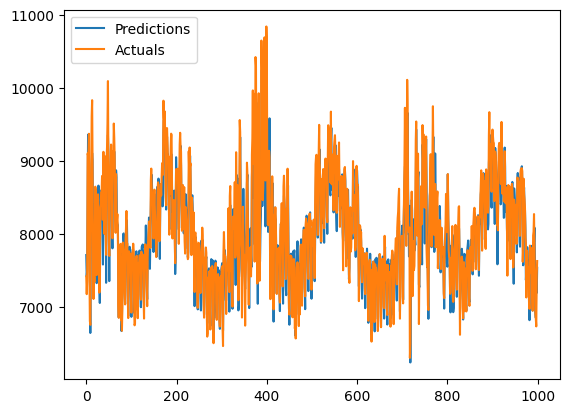

MAPE: 2.59%
RMSE: 295.04
MAE : 209.34


Predictions      Actuals
0     7707.054688  7412.811667
1     7410.901855  7171.183125
2     7498.616211  7350.264167
3     8403.750000  9098.258333
4     9357.306641  9070.002917
...           ...          ...
1084  8109.124023  8447.030417
1085  8778.590820  8771.408958
1086  8401.464844  8487.014792
1087  8147.698242  8380.489792
1088  8811.637695  8437.980833

[1089 rows x 2 columns]

In [186]:
model23 = load_model('model23.keras')

predictions_plot(model23, X_train23, y_train23, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


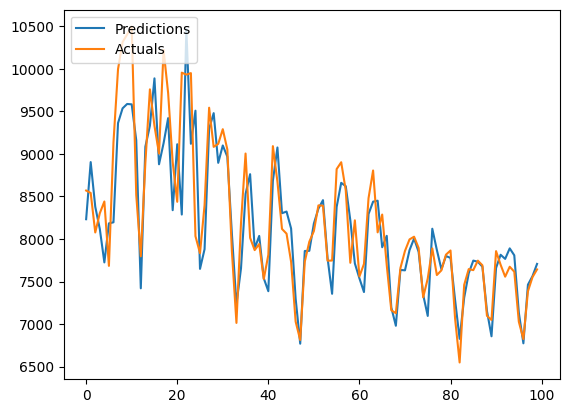

MAPE: 2.95%
RMSE: 337.63
MAE : 236.47


Predictions      Actuals
0    8232.498047  8569.568125
1    8903.891602  8540.904167
2    8379.009766  8076.513125
3    8118.159668  8302.971875
4    7725.023438  8440.820000
..           ...          ...
353  7819.788574  7508.199792
354  7832.883301  7694.271458
355  8227.749023  7746.240833
356  8708.552734  8321.401042
357  8504.026367  8503.726875

[358 rows x 2 columns]

In [187]:
predictions_plot(model23, X_test23, y_test23, 0, 100)

## Model 20 Re-Run (Post Optuna Trial 2) ##

In [188]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

i = X_train24.shape[1]
j = X_train24.shape[2]

In [189]:
model24 = Sequential()
model24.add(InputLayer((i, j)))
model24.add(LSTM(57, dropout=0.013))
model24.add(Dense(8, 'tanh'))
model24.add(Dense(1, 'linear'))

model24.summary()

Model: "sequential_227"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_240 (LSTM)                 │ (None, 57)             │        16,188 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_454 (Dense)               │ (None, 8)              │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_455 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,661 (65.08 KB)

 Trainable params: 16,661 (65.08 KB)

 Non-trainable params: 0 (0.00 B)

In [190]:
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=32, callbacks=[cp24])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0392 - root_mean_squared_error: 0.1944
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0147 - root_mean_squared_error: 0.1213
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0111 - root_mean_squared_error: 0.1054
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0956
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0972
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0085 - root_mean_squared_error: 0.0922

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


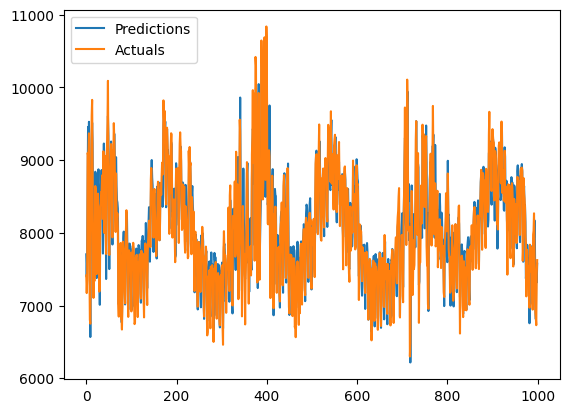

MAPE: 2.57%
RMSE: 286.45
MAE : 205.34


Predictions      Actuals
0     7704.252930  7412.811667
1     7393.505859  7171.183125
2     7655.514160  7350.264167
3     8480.804688  9098.258333
4     9457.395508  9070.002917
...           ...          ...
1084  8154.479004  8447.030417
1085  8994.922852  8771.408958
1086  8640.677734  8487.014792
1087  8196.711914  8380.489792
1088  8593.546875  8437.980833

[1089 rows x 2 columns]

In [191]:
model24 = load_model('model24.keras')

predictions_plot(model24, X_train24, y_train24, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


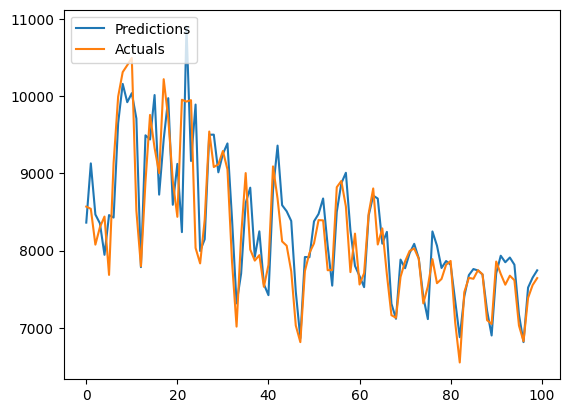

MAPE: 3.19%
RMSE: 353.57
MAE : 253.19


Predictions      Actuals
0    8362.284180  8569.568125
1    9130.046875  8540.904167
2    8467.428711  8076.513125
3    8352.461914  8302.971875
4    7944.727051  8440.820000
..           ...          ...
353  7733.369629  7508.199792
354  7759.151367  7694.271458
355  8187.625977  7746.240833
356  8637.524414  8321.401042
357  8525.855469  8503.726875

[358 rows x 2 columns]

In [192]:
predictions_plot(model24, X_test24, y_test24, 0, 100)

## Model 20 Re-Run (Post Optuna) - Batch Size Adjust ##

In [199]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

i = X_train25.shape[1]
j = X_train25.shape[2]

In [200]:
model25 = Sequential()
model25.add(InputLayer((i, j)))
model25.add(LSTM(32, dropout=0.013))
model25.add(Dense(8, 'tanh'))
model25.add(Dense(1, 'linear'))

model25.summary()

Model: "sequential_229"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_242 (LSTM)                 │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_458 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_459 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,161 (24.07 KB)

 Trainable params: 6,161 (24.07 KB)

 Non-trainable params: 0 (0.00 B)

In [201]:
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=4, callbacks=[cp25])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0681 - root_mean_squared_error: 0.2392
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0126 - root_mean_squared_error: 0.1119
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0106 - root_mean_squared_error: 0.1027
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0965
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0092 - root_mean_squared_error: 0.0955
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_squared_error: 0.0922
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0090 - root_mean_squared_error: 0.0941
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


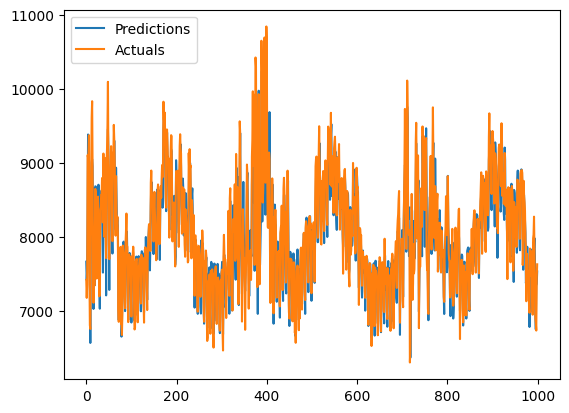

MAPE: 2.45%
RMSE: 278.98
MAE : 198.25


Predictions      Actuals
0     7660.104004  7412.811667
1     7410.532715  7171.183125
2     7541.225586  7350.264167
3     8292.343750  9098.258333
4     9378.967773  9070.002917
...           ...          ...
1084  8108.576660  8447.030417
1085  8779.506836  8771.408958
1086  8514.539062  8487.014792
1087  8201.766602  8380.489792
1088  8587.034180  8437.980833

[1089 rows x 2 columns]

In [202]:
model25 = load_model('model25.keras')

predictions_plot(model25, X_train25, y_train25, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


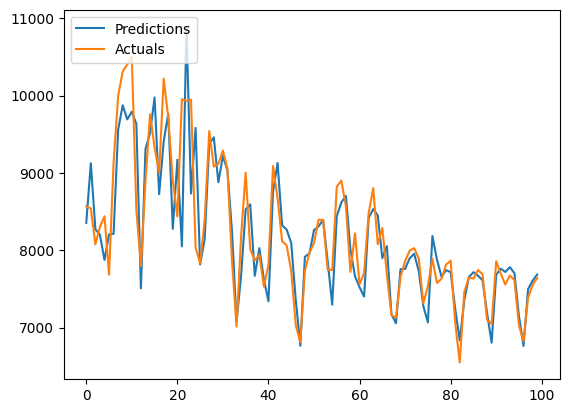

MAPE: 2.95%
RMSE: 340.02
MAE : 236.16


Predictions      Actuals
0    8354.975586  8569.568125
1    9126.568359  8540.904167
2    8270.583984  8076.513125
3    8200.319336  8302.971875
4    7874.640625  8440.820000
..           ...          ...
353  7787.579590  7508.199792
354  7891.554199  7694.271458
355  8353.000977  7746.240833
356  8529.039062  8321.401042
357  8476.593750  8503.726875

[358 rows x 2 columns]

In [203]:
predictions_plot(model25, X_test25, y_test25, 0, 100)

## Stacked LSTM - From Model 23 ##

In [204]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

i = X_train26.shape[1]
j = X_train26.shape[2]

In [205]:
model26 = Sequential()
model26.add(InputLayer((i, j)))
model26.add(LSTM(32, dropout=0.013, return_sequences=True))
model26.add(LSTM(16, dropout=0.013))
model26.add(Dense(8, 'tanh'))
model26.add(Dense(1, 'linear'))

model26.summary()

Model: "sequential_230"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_243 (LSTM)                 │ (None, 7, 32)          │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_244 (LSTM)                 │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_460 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,169 (35.82 KB)

 Trainable params: 9,169 (35.82 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0548 - root_mean_squared_error: 0.2227
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0149 - root_mean_squared_error: 0.1217
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0136 - root_mean_squared_error: 0.1162
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121 - root_mean_squared_error: 0.1097
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - root_mean_squared_error: 0.1084
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0124 - root_mean_squared_error: 0.1109
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0111 - root_mean_squared_error: 0.1053
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0107 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


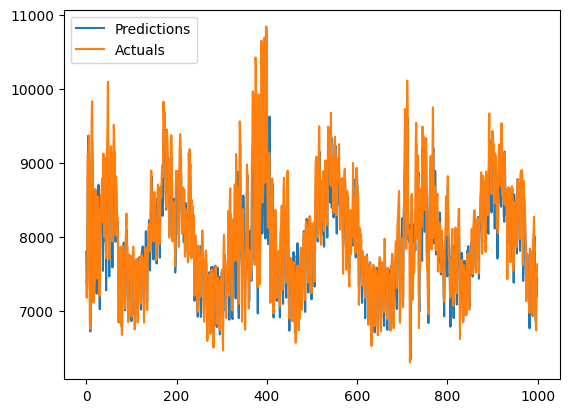

MAPE: 2.69%
RMSE: 305.71
MAE : 218.65


Predictions      Actuals
0     7794.937500  7412.811667
1     7359.312012  7171.183125
2     7387.999023  7350.264167
3     8498.927734  9098.258333
4     9359.666016  9070.002917
...           ...          ...
1084  8120.633301  8447.030417
1085  8644.684570  8771.408958
1086  8440.625000  8487.014792
1087  8054.059570  8380.489792
1088  8490.724609  8437.980833

[1089 rows x 2 columns]

In [207]:
model26 = load_model('model26.keras')

predictions_plot(model26, X_train26, y_train26, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


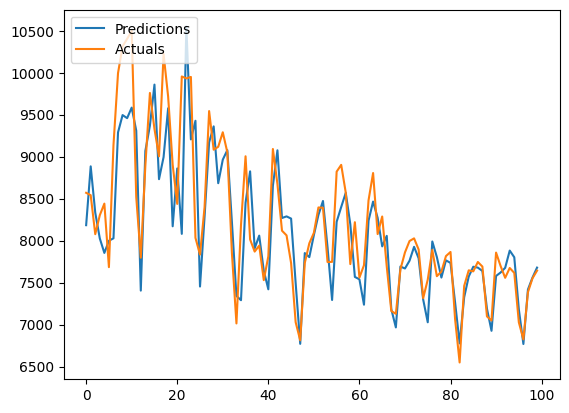

MAPE: 3.15%
RMSE: 359.25
MAE : 253.39


Predictions      Actuals
0    8183.989258  8569.568125
1    8884.612305  8540.904167
2    8332.662109  8076.513125
3    8025.790527  8302.971875
4    7853.534668  8440.820000
..           ...          ...
353  7699.495117  7508.199792
354  7621.150879  7694.271458
355  7995.043945  7746.240833
356  8749.487305  8321.401042
357  8462.144531  8503.726875

[358 rows x 2 columns]

In [208]:
predictions_plot(model26, X_test26, y_test26, 0, 100)

## CNN-LSTM Test - From Model 23 ##

In [210]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

i = X_train27.shape[1]
j = X_train27.shape[2]

In [211]:
model27 = Sequential()
model27.add(InputLayer((i, j)))
model27.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model27.add(MaxPooling1D(pool_size=2))
model27.add(Dropout(0.013))
model27.add(LSTM(32, dropout=0.013))
model27.add(Dense(8, 'tanh'))
model27.add(Dense(1, 'linear'))

model27.summary()

Model: "sequential_232"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 5, 64)          │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_246 (LSTM)                 │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_464 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_465 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,249 (59.57 KB)

 Trainable params: 15,249 (59.57 KB)

 Non-trainable params: 0 (0.00 B)

In [212]:
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=8, callbacks=[cp27])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0509 - root_mean_squared_error: 0.2134
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0138 - root_mean_squared_error: 0.1170
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0126 - root_mean_squared_error: 0.1118
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - root_mean_squared_error: 0.1097
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0118 - root_mean_squared_error: 0.1083
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0111 - root_mean_squared_error: 0.1049
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0110 - root_mean_squared_error: 0.1046
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - root_mean_squared_error: 0.1040
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


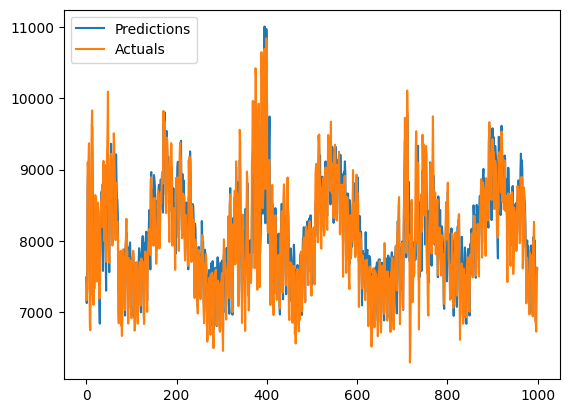

MAPE: 2.86%
RMSE: 305.59
MAE : 227.52


Predictions      Actuals
0     7490.815430  7412.811667
1     7130.075684  7171.183125
2     7306.997559  7350.264167
3     8750.306641  9098.258333
4     8979.180664  9070.002917
...           ...          ...
1084  8753.778320  8447.030417
1085  8822.613281  8771.408958
1086  8441.531250  8487.014792
1087  8237.858398  8380.489792
1088  8282.407227  8437.980833

[1089 rows x 2 columns]

In [213]:
model27 = load_model('model27.keras')

predictions_plot(model27, X_train27, y_train27, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


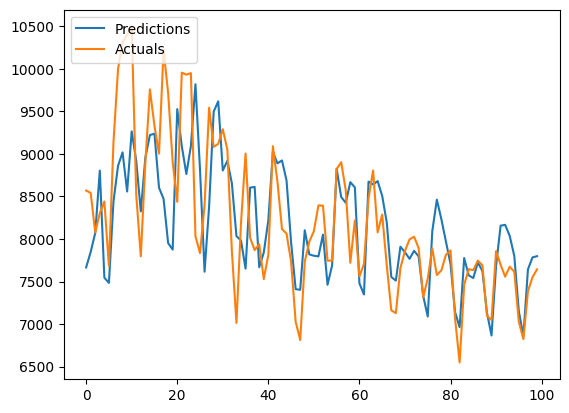

MAPE: 4.83%
RMSE: 511.65
MAE : 386.62


Predictions      Actuals
0    7666.368164  8569.568125
1    7848.774414  8540.904167
2    8071.266602  8076.513125
3    8804.207031  8302.971875
4    7545.677734  8440.820000
..           ...          ...
353  8266.780273  7508.199792
354  7818.390137  7694.271458
355  8101.387207  7746.240833
356  8383.868164  8321.401042
357  8104.729004  8503.726875

[358 rows x 2 columns]

In [214]:
predictions_plot(model27, X_test27, y_test27, 0, 100)

## CNN-LSTM Optuna Trials ##

In [219]:
'''study3 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study3.optimize(objective3, n_trials=100)

[I 2025-09-20 10:53:27,251] A new study created in memory with name: no-name-9fe447db-3c14-4a30-8560-c4d84ce4e450
[I 2025-09-20 10:54:06,978] Trial 0 finished with value: 326.4156452921656 and parameters: {'filters': 58, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 90, 'dropout': 0.07800932022121826, 'learning_rate': 0.00020511104188433984, 'batch_size': 16}. Best is trial 0 with value: 326.4156452921656.


Trial 0: filters=58, kernel=5, pool=3, lstm_units=90, dropout=0.08, lr=0.00021, batch=16, MAE=326.42


[I 2025-09-20 10:54:32,064] Trial 1 finished with value: 299.6823419099904 and parameters: {'filters': 96, 'kernel_size': 2, 'pool_size': 3, 'lstm_units': 112, 'dropout': 0.10616955533913808, 'learning_rate': 0.0002310201887845295, 'batch_size': 32}. Best is trial 1 with value: 299.6823419099904.


Trial 1: filters=96, kernel=2, pool=3, lstm_units=112, dropout=0.11, lr=0.00023, batch=32, MAE=299.68


[I 2025-09-20 10:55:11,847] Trial 2 finished with value: 378.4390286226137 and parameters: {'filters': 64, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 45, 'dropout': 0.14607232426760908, 'learning_rate': 0.0005404103854647331, 'batch_size': 16}. Best is trial 1 with value: 299.6823419099904.


Trial 2: filters=64, kernel=3, pool=3, lstm_units=45, dropout=0.15, lr=0.00054, batch=16, MAE=378.44


[I 2025-09-20 10:55:51,561] Trial 3 finished with value: 302.35801066195415 and parameters: {'filters': 74, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 90, 'dropout': 0.08526206184364576, 'learning_rate': 0.00013492834268013249, 'batch_size': 16}. Best is trial 1 with value: 299.6823419099904.


Trial 3: filters=74, kernel=4, pool=2, lstm_units=90, dropout=0.09, lr=0.00013, batch=16, MAE=302.36


[I 2025-09-20 10:56:31,292] Trial 4 finished with value: 303.56373098408085 and parameters: {'filters': 50, 'kernel_size': 2, 'pool_size': 3, 'lstm_units': 74, 'dropout': 0.06101911742238941, 'learning_rate': 0.0009780337016659412, 'batch_size': 16}. Best is trial 1 with value: 299.6823419099904.


Trial 4: filters=50, kernel=2, pool=3, lstm_units=74, dropout=0.06, lr=0.00098, batch=16, MAE=303.56


[I 2025-09-20 10:57:10,612] Trial 5 finished with value: 459.69471306949737 and parameters: {'filters': 90, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 85, 'dropout': 0.09242722776276352, 'learning_rate': 0.00869299151113955, 'batch_size': 16}. Best is trial 1 with value: 299.6823419099904.


Trial 5: filters=90, kernel=3, pool=3, lstm_units=85, dropout=0.09, lr=0.00869, batch=16, MAE=459.69


[I 2025-09-20 10:57:35,367] Trial 6 finished with value: 380.01257274223303 and parameters: {'filters': 83, 'kernel_size': 5, 'pool_size': 2, 'lstm_units': 51, 'dropout': 0.022613644455269033, 'learning_rate': 0.0004473636174621269, 'batch_size': 32}. Best is trial 1 with value: 299.6823419099904.


Trial 6: filters=83, kernel=5, pool=2, lstm_units=51, dropout=0.02, lr=0.00045, batch=32, MAE=380.01


[I 2025-09-20 10:58:43,745] Trial 7 finished with value: 377.0204311205918 and parameters: {'filters': 56, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 45, 'dropout': 0.40109849037701983, 'learning_rate': 0.00014096175149815865, 'batch_size': 8}. Best is trial 1 with value: 299.6823419099904.


Trial 7: filters=56, kernel=3, pool=3, lstm_units=45, dropout=0.40, lr=0.00014, batch=8, MAE=377.02


[I 2025-09-20 10:59:08,377] Trial 8 finished with value: 390.4644237647087 and parameters: {'filters': 16, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 102, 'dropout': 0.38563517334297287, 'learning_rate': 0.00014063366777718192, 'batch_size': 32}. Best is trial 1 with value: 299.6823419099904.


Trial 8: filters=16, kernel=5, pool=3, lstm_units=102, dropout=0.39, lr=0.00014, batch=32, MAE=390.46


[I 2025-09-20 10:59:47,756] Trial 9 finished with value: 383.14206214677847 and parameters: {'filters': 86, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 62, 'dropout': 0.16259166101337352, 'learning_rate': 0.002878805718308925, 'batch_size': 16}. Best is trial 1 with value: 299.6823419099904.


Trial 9: filters=86, kernel=3, pool=2, lstm_units=62, dropout=0.16, lr=0.00288, batch=16, MAE=383.14


[I 2025-09-20 11:00:12,990] Trial 10 finished with value: 280.7558404108337 and parameters: {'filters': 125, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 124, 'dropout': 0.2728591400411077, 'learning_rate': 0.0024015639024822476, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 10: filters=125, kernel=2, pool=2, lstm_units=124, dropout=0.27, lr=0.00240, batch=32, MAE=280.76


[I 2025-09-20 11:00:38,156] Trial 11 finished with value: 289.2696868527611 and parameters: {'filters': 126, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 128, 'dropout': 0.2792623653896451, 'learning_rate': 0.0020819869967980786, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 11: filters=126, kernel=2, pool=2, lstm_units=128, dropout=0.28, lr=0.00208, batch=32, MAE=289.27


[I 2025-09-20 11:01:03,220] Trial 12 finished with value: 290.30029147018223 and parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 128, 'dropout': 0.2945636645911881, 'learning_rate': 0.0028627088057677583, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 12: filters=128, kernel=2, pool=2, lstm_units=128, dropout=0.29, lr=0.00286, batch=32, MAE=290.30


[I 2025-09-20 11:01:28,100] Trial 13 finished with value: 312.6345170450297 and parameters: {'filters': 128, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 128, 'dropout': 0.23878616190992558, 'learning_rate': 0.0027972773241975732, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 13: filters=128, kernel=2, pool=2, lstm_units=128, dropout=0.24, lr=0.00280, batch=32, MAE=312.63


[I 2025-09-20 11:02:36,549] Trial 14 finished with value: 395.47499931295476 and parameters: {'filters': 111, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 113, 'dropout': 0.30187983654275125, 'learning_rate': 0.0055798605567801, 'batch_size': 8}. Best is trial 10 with value: 280.7558404108337.


Trial 14: filters=111, kernel=4, pool=2, lstm_units=113, dropout=0.30, lr=0.00558, batch=8, MAE=395.47


[I 2025-09-20 11:03:01,710] Trial 15 finished with value: 291.32749811815916 and parameters: {'filters': 108, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 113, 'dropout': 0.49800849468060676, 'learning_rate': 0.0014970704838765231, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 15: filters=108, kernel=2, pool=2, lstm_units=113, dropout=0.50, lr=0.00150, batch=32, MAE=291.33


[I 2025-09-20 11:03:26,697] Trial 16 finished with value: 292.62027234651885 and parameters: {'filters': 112, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 102, 'dropout': 0.2815681102967666, 'learning_rate': 0.001267634038853495, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 16: filters=112, kernel=2, pool=2, lstm_units=102, dropout=0.28, lr=0.00127, batch=32, MAE=292.62


[I 2025-09-20 11:03:51,590] Trial 17 finished with value: 310.7013778892917 and parameters: {'filters': 34, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 33, 'dropout': 0.21999302758516429, 'learning_rate': 0.004459915430559169, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 17: filters=34, kernel=4, pool=2, lstm_units=33, dropout=0.22, lr=0.00446, batch=32, MAE=310.70


[I 2025-09-20 11:05:00,167] Trial 18 finished with value: 411.5043760303095 and parameters: {'filters': 102, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 122, 'dropout': 0.3609727402803514, 'learning_rate': 0.0016700078170757656, 'batch_size': 8}. Best is trial 10 with value: 280.7558404108337.


Trial 18: filters=102, kernel=3, pool=2, lstm_units=122, dropout=0.36, lr=0.00167, batch=8, MAE=411.50


[I 2025-09-20 11:05:30,139] Trial 19 finished with value: 283.7962728637167 and parameters: {'filters': 117, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 99, 'dropout': 0.3448372126058836, 'learning_rate': 0.0007450744435901376, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 19: filters=117, kernel=2, pool=2, lstm_units=99, dropout=0.34, lr=0.00075, batch=32, MAE=283.80


[I 2025-09-20 11:05:56,616] Trial 20 finished with value: 364.30255971515834 and parameters: {'filters': 118, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.4741482698624123, 'learning_rate': 0.0007336538861985164, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 20: filters=118, kernel=3, pool=2, lstm_units=100, dropout=0.47, lr=0.00073, batch=32, MAE=364.30


[I 2025-09-20 11:06:22,823] Trial 21 finished with value: 293.0553523138191 and parameters: {'filters': 121, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 119, 'dropout': 0.3407434980706122, 'learning_rate': 0.0017851389821598722, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 21: filters=121, kernel=2, pool=2, lstm_units=119, dropout=0.34, lr=0.00179, batch=32, MAE=293.06


[I 2025-09-20 11:06:49,043] Trial 22 finished with value: 311.7987853268868 and parameters: {'filters': 101, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 106, 'dropout': 0.4314981376230485, 'learning_rate': 0.0003704421308732812, 'batch_size': 32}. Best is trial 10 with value: 280.7558404108337.


Trial 22: filters=101, kernel=2, pool=2, lstm_units=106, dropout=0.43, lr=0.00037, batch=32, MAE=311.80


[I 2025-09-20 11:07:15,055] Trial 23 finished with value: 270.6800342237023 and parameters: {'filters': 118, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 74, 'dropout': 0.1988253157652793, 'learning_rate': 0.0008370267046698036, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 23: filters=118, kernel=2, pool=2, lstm_units=74, dropout=0.20, lr=0.00084, batch=32, MAE=270.68


[I 2025-09-20 11:07:40,671] Trial 24 finished with value: 286.10977815559005 and parameters: {'filters': 117, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 77, 'dropout': 0.18809156401735622, 'learning_rate': 0.0007972980507002475, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 24: filters=117, kernel=2, pool=2, lstm_units=77, dropout=0.19, lr=0.00080, batch=32, MAE=286.11


[I 2025-09-20 11:08:06,272] Trial 25 finished with value: 349.3515018300325 and parameters: {'filters': 106, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 64, 'dropout': 0.3305765961770698, 'learning_rate': 0.0006122252258673012, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 25: filters=106, kernel=3, pool=2, lstm_units=64, dropout=0.33, lr=0.00061, batch=32, MAE=349.35


[I 2025-09-20 11:09:16,988] Trial 26 finished with value: 306.6216374260404 and parameters: {'filters': 96, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 93, 'dropout': 0.19915475334070407, 'learning_rate': 0.00030762192305617945, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 26: filters=96, kernel=2, pool=2, lstm_units=93, dropout=0.20, lr=0.00031, batch=8, MAE=306.62


[I 2025-09-20 11:09:42,241] Trial 27 finished with value: 382.7687854761329 and parameters: {'filters': 118, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 69, 'dropout': 0.24875383051497102, 'learning_rate': 0.0010592888837732456, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 27: filters=118, kernel=3, pool=2, lstm_units=69, dropout=0.25, lr=0.00106, batch=32, MAE=382.77


[I 2025-09-20 11:10:07,676] Trial 28 finished with value: 275.2024195292126 and parameters: {'filters': 78, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 93, 'dropout': 0.15491629216672342, 'learning_rate': 0.0009203988279610842, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 28: filters=78, kernel=2, pool=2, lstm_units=93, dropout=0.15, lr=0.00092, batch=32, MAE=275.20


[I 2025-09-20 11:11:17,409] Trial 29 finished with value: 386.0407180753834 and parameters: {'filters': 70, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 82, 'dropout': 0.1526903882636343, 'learning_rate': 0.003977011167149506, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 29: filters=70, kernel=4, pool=2, lstm_units=82, dropout=0.15, lr=0.00398, batch=8, MAE=386.04


[I 2025-09-20 11:11:42,483] Trial 30 finished with value: 295.02619240509244 and parameters: {'filters': 43, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 58, 'dropout': 0.20109295461795712, 'learning_rate': 0.00229797634033465, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 30: filters=43, kernel=2, pool=2, lstm_units=58, dropout=0.20, lr=0.00230, batch=32, MAE=295.03


[I 2025-09-20 11:12:07,543] Trial 31 finished with value: 295.08073188726 and parameters: {'filters': 76, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 94, 'dropout': 0.2604787493464917, 'learning_rate': 0.0009538992562057897, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 31: filters=76, kernel=2, pool=2, lstm_units=94, dropout=0.26, lr=0.00095, batch=32, MAE=295.08


[I 2025-09-20 11:12:32,659] Trial 32 finished with value: 285.8294719473141 and parameters: {'filters': 93, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 87, 'dropout': 0.12098582305668376, 'learning_rate': 0.0002702917268450919, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 32: filters=93, kernel=2, pool=2, lstm_units=87, dropout=0.12, lr=0.00027, batch=32, MAE=285.83


[I 2025-09-20 11:12:57,784] Trial 33 finished with value: 292.3136831581533 and parameters: {'filters': 114, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 72, 'dropout': 0.3230915955507561, 'learning_rate': 0.000530119202839802, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 33: filters=114, kernel=2, pool=2, lstm_units=72, dropout=0.32, lr=0.00053, batch=32, MAE=292.31


[I 2025-09-20 11:13:22,831] Trial 34 finished with value: 278.27450358503376 and parameters: {'filters': 123, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 95, 'dropout': 0.12292012677074349, 'learning_rate': 0.0006989120284708765, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 34: filters=123, kernel=2, pool=2, lstm_units=95, dropout=0.12, lr=0.00070, batch=32, MAE=278.27


[I 2025-09-20 11:14:02,101] Trial 35 finished with value: 404.9658380559977 and parameters: {'filters': 122, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 78, 'dropout': 0.12472840126451382, 'learning_rate': 0.001270681074994444, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 35: filters=122, kernel=3, pool=3, lstm_units=78, dropout=0.12, lr=0.00127, batch=16, MAE=404.97


[I 2025-09-20 11:14:27,295] Trial 36 finished with value: 274.80287078544916 and parameters: {'filters': 102, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 108, 'dropout': 0.0521036464026817, 'learning_rate': 0.00042128089224735955, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 36: filters=102, kernel=2, pool=2, lstm_units=108, dropout=0.05, lr=0.00042, batch=32, MAE=274.80


[I 2025-09-20 11:15:07,414] Trial 37 finished with value: 305.06488595907564 and parameters: {'filters': 80, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 106, 'dropout': 0.05708518780866042, 'learning_rate': 0.0002136446553359608, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 37: filters=80, kernel=2, pool=2, lstm_units=106, dropout=0.06, lr=0.00021, batch=16, MAE=305.06


[I 2025-09-20 11:15:32,024] Trial 38 finished with value: 374.6733545210901 and parameters: {'filters': 101, 'kernel_size': 3, 'pool_size': 3, 'lstm_units': 91, 'dropout': 0.008603870076507272, 'learning_rate': 0.0004308866710539551, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 38: filters=101, kernel=3, pool=3, lstm_units=91, dropout=0.01, lr=0.00043, batch=32, MAE=374.67


[I 2025-09-20 11:15:57,272] Trial 39 finished with value: 286.1263840377277 and parameters: {'filters': 63, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 84, 'dropout': 0.046212579626245184, 'learning_rate': 0.0003431912671141686, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 39: filters=63, kernel=2, pool=2, lstm_units=84, dropout=0.05, lr=0.00034, batch=32, MAE=286.13


[I 2025-09-20 11:16:36,465] Trial 40 finished with value: 328.97128662764214 and parameters: {'filters': 85, 'kernel_size': 5, 'pool_size': 3, 'lstm_units': 96, 'dropout': 0.08173082884980623, 'learning_rate': 0.0005603540315360088, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 40: filters=85, kernel=5, pool=3, lstm_units=96, dropout=0.08, lr=0.00056, batch=16, MAE=328.97


[I 2025-09-20 11:17:01,953] Trial 41 finished with value: 283.1774803828836 and parameters: {'filters': 123, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 120, 'dropout': 0.16945287454237523, 'learning_rate': 0.0008847385909603561, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 41: filters=123, kernel=2, pool=2, lstm_units=120, dropout=0.17, lr=0.00088, batch=32, MAE=283.18


[I 2025-09-20 11:17:27,963] Trial 42 finished with value: 304.81538571399835 and parameters: {'filters': 105, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 108, 'dropout': 0.03896603366914725, 'learning_rate': 0.00010123622038071508, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 42: filters=105, kernel=2, pool=2, lstm_units=108, dropout=0.04, lr=0.00010, batch=32, MAE=304.82


[I 2025-09-20 11:17:53,355] Trial 43 finished with value: 282.2072553071741 and parameters: {'filters': 91, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 87, 'dropout': 0.11688897565970398, 'learning_rate': 0.0012504624449285234, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 43: filters=91, kernel=2, pool=2, lstm_units=87, dropout=0.12, lr=0.00125, batch=32, MAE=282.21


[I 2025-09-20 11:18:18,894] Trial 44 finished with value: 289.72884693458144 and parameters: {'filters': 125, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 116, 'dropout': 0.09152512504148064, 'learning_rate': 0.0006449462390788591, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 44: filters=125, kernel=2, pool=2, lstm_units=116, dropout=0.09, lr=0.00064, batch=32, MAE=289.73


[I 2025-09-20 11:18:44,372] Trial 45 finished with value: 287.420965062186 and parameters: {'filters': 111, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 111, 'dropout': 0.1411832091429095, 'learning_rate': 0.00047425347796481427, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 45: filters=111, kernel=2, pool=2, lstm_units=111, dropout=0.14, lr=0.00047, batch=32, MAE=287.42


[I 2025-09-20 11:19:09,784] Trial 46 finished with value: 370.16092458263665 and parameters: {'filters': 68, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 123, 'dropout': 0.1718271911292194, 'learning_rate': 0.00042703936436279025, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 46: filters=68, kernel=3, pool=2, lstm_units=123, dropout=0.17, lr=0.00043, batch=32, MAE=370.16


[I 2025-09-20 11:20:20,667] Trial 47 finished with value: 485.37180687437404 and parameters: {'filters': 97, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 97, 'dropout': 0.2208944673703149, 'learning_rate': 0.0010005829292327438, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 47: filters=97, kernel=2, pool=2, lstm_units=97, dropout=0.22, lr=0.00100, batch=8, MAE=485.37


[I 2025-09-20 11:20:46,533] Trial 48 finished with value: 309.2990561054805 and parameters: {'filters': 109, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 104, 'dropout': 0.10357438881009758, 'learning_rate': 0.006712746809743053, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 48: filters=109, kernel=2, pool=2, lstm_units=104, dropout=0.10, lr=0.00671, batch=32, MAE=309.30


[I 2025-09-20 11:21:27,459] Trial 49 finished with value: 382.43837509747055 and parameters: {'filters': 128, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 89, 'dropout': 0.06716848185987251, 'learning_rate': 0.0006812131435637794, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 49: filters=128, kernel=3, pool=2, lstm_units=89, dropout=0.07, lr=0.00068, batch=16, MAE=382.44


[I 2025-09-20 11:21:53,526] Trial 50 finished with value: 305.49677715267967 and parameters: {'filters': 54, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 110, 'dropout': 0.14578928816308953, 'learning_rate': 0.00017098640419999992, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 50: filters=54, kernel=2, pool=2, lstm_units=110, dropout=0.15, lr=0.00017, batch=32, MAE=305.50


[I 2025-09-20 11:22:19,925] Trial 51 finished with value: 278.9680139508329 and parameters: {'filters': 89, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 81, 'dropout': 0.11324739717569896, 'learning_rate': 0.001223143037270961, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 51: filters=89, kernel=2, pool=2, lstm_units=81, dropout=0.11, lr=0.00122, batch=32, MAE=278.97


[I 2025-09-20 11:22:46,061] Trial 52 finished with value: 292.4083193186289 and parameters: {'filters': 80, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 80, 'dropout': 0.02353869141470705, 'learning_rate': 0.0023463287472044623, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 52: filters=80, kernel=2, pool=2, lstm_units=80, dropout=0.02, lr=0.00235, batch=32, MAE=292.41


[I 2025-09-20 11:23:12,297] Trial 53 finished with value: 275.1603729662879 and parameters: {'filters': 88, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 74, 'dropout': 0.13248666132430106, 'learning_rate': 0.0012501681068163319, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 53: filters=88, kernel=2, pool=2, lstm_units=74, dropout=0.13, lr=0.00125, batch=32, MAE=275.16


[I 2025-09-20 11:23:38,535] Trial 54 finished with value: 290.39144968847677 and parameters: {'filters': 87, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 74, 'dropout': 0.13272651694688775, 'learning_rate': 0.0014531614056306152, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 54: filters=87, kernel=2, pool=2, lstm_units=74, dropout=0.13, lr=0.00145, batch=32, MAE=290.39


[I 2025-09-20 11:24:04,792] Trial 55 finished with value: 280.51113003961206 and parameters: {'filters': 76, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 69, 'dropout': 0.10510920645659186, 'learning_rate': 0.0011552069548379916, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 55: filters=76, kernel=2, pool=2, lstm_units=69, dropout=0.11, lr=0.00116, batch=32, MAE=280.51


[I 2025-09-20 11:24:30,793] Trial 56 finished with value: 281.8615375514601 and parameters: {'filters': 96, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 64, 'dropout': 0.18120031306251722, 'learning_rate': 0.0008446740151950803, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 56: filters=96, kernel=2, pool=2, lstm_units=64, dropout=0.18, lr=0.00084, batch=32, MAE=281.86


[I 2025-09-20 11:24:56,667] Trial 57 finished with value: 298.983230417716 and parameters: {'filters': 88, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 58, 'dropout': 0.07098419402639397, 'learning_rate': 0.001943693292294398, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 57: filters=88, kernel=2, pool=2, lstm_units=58, dropout=0.07, lr=0.00194, batch=32, MAE=298.98


[I 2025-09-20 11:25:29,633] Trial 58 finished with value: 366.097737045228 and parameters: {'filters': 79, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 84, 'dropout': 0.15780804274913207, 'learning_rate': 0.0015314836291359215, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 58: filters=79, kernel=3, pool=2, lstm_units=84, dropout=0.16, lr=0.00153, batch=32, MAE=366.10


[I 2025-09-20 11:26:44,901] Trial 59 finished with value: 317.65953591562857 and parameters: {'filters': 83, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 76, 'dropout': 0.21899999219442193, 'learning_rate': 0.0005183162071582063, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 59: filters=83, kernel=2, pool=2, lstm_units=76, dropout=0.22, lr=0.00052, batch=8, MAE=317.66


[I 2025-09-20 11:27:11,236] Trial 60 finished with value: 329.09262927004653 and parameters: {'filters': 19, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 68, 'dropout': 0.08763691292993789, 'learning_rate': 0.0007037232322796919, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 60: filters=19, kernel=4, pool=2, lstm_units=68, dropout=0.09, lr=0.00070, batch=32, MAE=329.09


[I 2025-09-20 11:27:37,227] Trial 61 finished with value: 281.4653120721205 and parameters: {'filters': 64, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 69, 'dropout': 0.10809857071801218, 'learning_rate': 0.0011438990967786108, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 61: filters=64, kernel=2, pool=2, lstm_units=69, dropout=0.11, lr=0.00114, batch=32, MAE=281.47


[I 2025-09-20 11:28:03,449] Trial 62 finished with value: 304.49421010006745 and parameters: {'filters': 77, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 72, 'dropout': 0.10336862404557606, 'learning_rate': 0.0011487255442761814, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 62: filters=77, kernel=2, pool=2, lstm_units=72, dropout=0.10, lr=0.00115, batch=32, MAE=304.49


[I 2025-09-20 11:28:29,509] Trial 63 finished with value: 308.27368164656286 and parameters: {'filters': 73, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 80, 'dropout': 0.1434604011337387, 'learning_rate': 0.0008419125243404731, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 63: filters=73, kernel=2, pool=2, lstm_units=80, dropout=0.14, lr=0.00084, batch=32, MAE=308.27


[I 2025-09-20 11:28:55,473] Trial 64 finished with value: 285.2853084955406 and parameters: {'filters': 92, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 59, 'dropout': 0.19310773558434097, 'learning_rate': 0.0013470780488758006, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 64: filters=92, kernel=2, pool=2, lstm_units=59, dropout=0.19, lr=0.00135, batch=32, MAE=285.29


[I 2025-09-20 11:29:21,160] Trial 65 finished with value: 295.516221979573 and parameters: {'filters': 82, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 66, 'dropout': 0.040967446720579725, 'learning_rate': 0.0016911212274617715, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 65: filters=82, kernel=2, pool=2, lstm_units=66, dropout=0.04, lr=0.00169, batch=32, MAE=295.52


[I 2025-09-20 11:29:46,941] Trial 66 finished with value: 279.43069477815413 and parameters: {'filters': 99, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 74, 'dropout': 0.1307985333986826, 'learning_rate': 0.0010167515396882836, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 66: filters=99, kernel=2, pool=2, lstm_units=74, dropout=0.13, lr=0.00102, batch=32, MAE=279.43


[I 2025-09-20 11:30:12,920] Trial 67 finished with value: 275.4036170965951 and parameters: {'filters': 100, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 53, 'dropout': 0.13413948454521554, 'learning_rate': 0.0009731145937248001, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 67: filters=100, kernel=2, pool=2, lstm_units=53, dropout=0.13, lr=0.00097, batch=32, MAE=275.40


[I 2025-09-20 11:30:39,169] Trial 68 finished with value: 283.5122138060147 and parameters: {'filters': 114, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 92, 'dropout': 0.20942772735435522, 'learning_rate': 0.0005910313697255063, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 68: filters=114, kernel=2, pool=2, lstm_units=92, dropout=0.21, lr=0.00059, batch=32, MAE=283.51


[I 2025-09-20 11:31:20,723] Trial 69 finished with value: 291.85029767698387 and parameters: {'filters': 102, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 48, 'dropout': 0.16522519511550338, 'learning_rate': 0.0007532872751831662, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 69: filters=102, kernel=2, pool=2, lstm_units=48, dropout=0.17, lr=0.00075, batch=16, MAE=291.85


[I 2025-09-20 11:32:31,314] Trial 70 finished with value: 374.31707353961434 and parameters: {'filters': 105, 'kernel_size': 2, 'pool_size': 3, 'lstm_units': 38, 'dropout': 0.23306094892372622, 'learning_rate': 0.0003793273088731335, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 70: filters=105, kernel=2, pool=3, lstm_units=38, dropout=0.23, lr=0.00038, batch=8, MAE=374.32


[I 2025-09-20 11:32:56,848] Trial 71 finished with value: 282.4657598989406 and parameters: {'filters': 99, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 52, 'dropout': 0.12755842442263432, 'learning_rate': 0.000963686720818369, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 71: filters=99, kernel=2, pool=2, lstm_units=52, dropout=0.13, lr=0.00096, batch=32, MAE=282.47


[I 2025-09-20 11:33:22,168] Trial 72 finished with value: 298.15659259831824 and parameters: {'filters': 92, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 54, 'dropout': 0.1786421858559844, 'learning_rate': 0.0009846807077066309, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 72: filters=92, kernel=2, pool=2, lstm_units=54, dropout=0.18, lr=0.00098, batch=32, MAE=298.16


[I 2025-09-20 11:33:47,590] Trial 73 finished with value: 308.7001715126949 and parameters: {'filters': 120, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 100, 'dropout': 0.1548173153708618, 'learning_rate': 0.00027108969359183974, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 73: filters=120, kernel=2, pool=2, lstm_units=100, dropout=0.15, lr=0.00027, batch=32, MAE=308.70


[I 2025-09-20 11:34:12,694] Trial 74 finished with value: 281.048567818248 and parameters: {'filters': 89, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 82, 'dropout': 0.1402938776853142, 'learning_rate': 0.0008196599100417691, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 74: filters=89, kernel=2, pool=2, lstm_units=82, dropout=0.14, lr=0.00082, batch=32, MAE=281.05


[I 2025-09-20 11:34:37,907] Trial 75 finished with value: 290.99295592131415 and parameters: {'filters': 94, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 74, 'dropout': 0.12493459987014115, 'learning_rate': 0.0019658457839806945, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 75: filters=94, kernel=2, pool=2, lstm_units=74, dropout=0.12, lr=0.00197, batch=32, MAE=290.99


[I 2025-09-20 11:35:03,170] Trial 76 finished with value: 296.29847960357984 and parameters: {'filters': 106, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 88, 'dropout': 0.05619851105748339, 'learning_rate': 0.0015225892862312273, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 76: filters=106, kernel=2, pool=2, lstm_units=88, dropout=0.06, lr=0.00152, batch=32, MAE=296.30


[I 2025-09-20 11:35:28,201] Trial 77 finished with value: 280.32553685677124 and parameters: {'filters': 99, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 41, 'dropout': 0.08210645957603133, 'learning_rate': 0.0011066771726808912, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 77: filters=99, kernel=2, pool=2, lstm_units=41, dropout=0.08, lr=0.00111, batch=32, MAE=280.33


[I 2025-09-20 11:35:53,358] Trial 78 finished with value: 283.42234794466873 and parameters: {'filters': 110, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 97, 'dropout': 0.1865536951880801, 'learning_rate': 0.000612901744829602, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 78: filters=110, kernel=2, pool=2, lstm_units=97, dropout=0.19, lr=0.00061, batch=32, MAE=283.42


[I 2025-09-20 11:36:18,129] Trial 79 finished with value: 373.7471745696316 and parameters: {'filters': 115, 'kernel_size': 5, 'pool_size': 2, 'lstm_units': 94, 'dropout': 0.16287298088281335, 'learning_rate': 0.0009192492460087285, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 79: filters=115, kernel=5, pool=2, lstm_units=94, dropout=0.16, lr=0.00092, batch=32, MAE=373.75


[I 2025-09-20 11:36:43,181] Trial 80 finished with value: 353.24852540977 and parameters: {'filters': 103, 'kernel_size': 3, 'pool_size': 2, 'lstm_units': 77, 'dropout': 0.11014579119770333, 'learning_rate': 0.0004841417522957004, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 80: filters=103, kernel=3, pool=2, lstm_units=77, dropout=0.11, lr=0.00048, batch=32, MAE=353.25


[I 2025-09-20 11:37:08,046] Trial 81 finished with value: 277.0366192559907 and parameters: {'filters': 99, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 43, 'dropout': 0.0788090644416462, 'learning_rate': 0.0013182134744145948, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 81: filters=99, kernel=2, pool=2, lstm_units=43, dropout=0.08, lr=0.00132, batch=32, MAE=277.04


[I 2025-09-20 11:37:32,986] Trial 82 finished with value: 294.04559768231235 and parameters: {'filters': 85, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 45, 'dropout': 0.09290849096788015, 'learning_rate': 0.001402985406428087, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 82: filters=85, kernel=2, pool=2, lstm_units=45, dropout=0.09, lr=0.00140, batch=32, MAE=294.05


[I 2025-09-20 11:37:58,165] Trial 83 finished with value: 281.7024631424084 and parameters: {'filters': 97, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 36, 'dropout': 0.02431464678066174, 'learning_rate': 0.0012818735935571834, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 83: filters=97, kernel=2, pool=2, lstm_units=36, dropout=0.02, lr=0.00128, batch=32, MAE=281.70


[I 2025-09-20 11:38:23,016] Trial 84 finished with value: 285.499601470434 and parameters: {'filters': 94, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 32, 'dropout': 0.06985137659955111, 'learning_rate': 0.0007282298713043307, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 84: filters=94, kernel=2, pool=2, lstm_units=32, dropout=0.07, lr=0.00073, batch=32, MAE=285.50


[I 2025-09-20 11:39:03,303] Trial 85 finished with value: 348.35850022728846 and parameters: {'filters': 100, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 44, 'dropout': 0.0015635889751498405, 'learning_rate': 0.0010443210215964316, 'batch_size': 16}. Best is trial 23 with value: 270.6800342237023.


Trial 85: filters=100, kernel=2, pool=2, lstm_units=44, dropout=0.00, lr=0.00104, batch=16, MAE=348.36


[I 2025-09-20 11:39:28,408] Trial 86 finished with value: 295.7289088714473 and parameters: {'filters': 107, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 103, 'dropout': 0.13353758174569896, 'learning_rate': 0.0009073938928143071, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 86: filters=107, kernel=2, pool=2, lstm_units=103, dropout=0.13, lr=0.00091, batch=32, MAE=295.73


[I 2025-09-20 11:39:53,412] Trial 87 finished with value: 277.0862287395014 and parameters: {'filters': 90, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 61, 'dropout': 0.12002781308343505, 'learning_rate': 0.001777188274123791, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 87: filters=90, kernel=2, pool=2, lstm_units=61, dropout=0.12, lr=0.00178, batch=32, MAE=277.09


[I 2025-09-20 11:41:02,552] Trial 88 finished with value: 415.71945494837115 and parameters: {'filters': 89, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 63, 'dropout': 0.0950454086961213, 'learning_rate': 0.0028343377416540903, 'batch_size': 8}. Best is trial 23 with value: 270.6800342237023.


Trial 88: filters=89, kernel=2, pool=2, lstm_units=63, dropout=0.10, lr=0.00283, batch=8, MAE=415.72


[I 2025-09-20 11:41:27,704] Trial 89 finished with value: 295.0681324486525 and parameters: {'filters': 84, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 56, 'dropout': 0.11678823749374802, 'learning_rate': 0.0032891369013862345, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 89: filters=84, kernel=2, pool=2, lstm_units=56, dropout=0.12, lr=0.00329, batch=32, MAE=295.07


[I 2025-09-20 11:41:52,849] Trial 90 finished with value: 286.5484232889179 and parameters: {'filters': 67, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 50, 'dropout': 0.05570461672505269, 'learning_rate': 0.0017750850351692363, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 90: filters=67, kernel=2, pool=2, lstm_units=50, dropout=0.06, lr=0.00178, batch=32, MAE=286.55


[I 2025-09-20 11:42:17,908] Trial 91 finished with value: 285.05812429455136 and parameters: {'filters': 95, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 61, 'dropout': 0.07536016097761696, 'learning_rate': 0.002116026806093195, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 91: filters=95, kernel=2, pool=2, lstm_units=61, dropout=0.08, lr=0.00212, batch=32, MAE=285.06


[I 2025-09-20 11:42:43,014] Trial 92 finished with value: 274.54154413241463 and parameters: {'filters': 90, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 72, 'dropout': 0.133835076489408, 'learning_rate': 0.0012285219747267375, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 92: filters=90, kernel=2, pool=2, lstm_units=72, dropout=0.13, lr=0.00123, batch=32, MAE=274.54


[I 2025-09-20 11:43:08,171] Trial 93 finished with value: 277.50411112020697 and parameters: {'filters': 87, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 66, 'dropout': 0.15030325099085293, 'learning_rate': 0.001578735206945267, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 93: filters=87, kernel=2, pool=2, lstm_units=66, dropout=0.15, lr=0.00158, batch=32, MAE=277.50


[I 2025-09-20 11:43:33,534] Trial 94 finished with value: 290.84313849009953 and parameters: {'filters': 87, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 62, 'dropout': 0.15025324228761847, 'learning_rate': 0.0015744106370416888, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 94: filters=87, kernel=2, pool=2, lstm_units=62, dropout=0.15, lr=0.00157, batch=32, MAE=290.84


[I 2025-09-20 11:43:58,865] Trial 95 finished with value: 287.2868035400781 and parameters: {'filters': 81, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 66, 'dropout': 0.1769206780179749, 'learning_rate': 0.0013882397640847088, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 95: filters=81, kernel=2, pool=2, lstm_units=66, dropout=0.18, lr=0.00139, batch=32, MAE=287.29


[I 2025-09-20 11:44:23,766] Trial 96 finished with value: 304.9888940217201 and parameters: {'filters': 91, 'kernel_size': 4, 'pool_size': 2, 'lstm_units': 71, 'dropout': 0.20292787244397542, 'learning_rate': 0.002460978899209428, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 96: filters=91, kernel=4, pool=2, lstm_units=71, dropout=0.20, lr=0.00246, batch=32, MAE=304.99


[I 2025-09-20 11:44:48,748] Trial 97 finished with value: 294.3653575284128 and parameters: {'filters': 77, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 115, 'dropout': 0.09851759511504508, 'learning_rate': 0.0016818523055545994, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 97: filters=77, kernel=2, pool=2, lstm_units=115, dropout=0.10, lr=0.00168, batch=32, MAE=294.37


[I 2025-09-20 11:45:13,741] Trial 98 finished with value: 293.1905944015312 and parameters: {'filters': 86, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 66, 'dropout': 0.13516031581977153, 'learning_rate': 0.0011995340851792611, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 98: filters=86, kernel=2, pool=2, lstm_units=66, dropout=0.14, lr=0.00120, batch=32, MAE=293.19


[I 2025-09-20 11:45:38,627] Trial 99 finished with value: 284.3979433434146 and parameters: {'filters': 123, 'kernel_size': 2, 'pool_size': 2, 'lstm_units': 71, 'dropout': 0.15450452443750212, 'learning_rate': 0.0007976419186104414, 'batch_size': 32}. Best is trial 23 with value: 270.6800342237023.


Trial 99: filters=123, kernel=2, pool=2, lstm_units=71, dropout=0.15, lr=0.00080, batch=32, MAE=284.40


In [220]:
'''print("Best trial:")
trial3 = study3.best_trial

print(f"  MAE: {trial3.value:.2f}")
print("  Params:")
for key, value in trial3.params.items():
    print(f"    {key}: {value}")

Best trial:
  MAE: 270.68
  Params:
    filters: 118
    kernel_size: 2
    pool_size: 2
    lstm_units: 74
    dropout: 0.1988253157652793
    learning_rate: 0.0008370267046698036
    batch_size: 32


## Explore Temp^2 ##

In [221]:
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  avg_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0        6861.518333  20.704082      15.2      26.0   
2016-01-02           0        6731.957292  20.572917      14.9      24.2   
2016-01-03           0        6618.040000  21.130769      19.0      22.9   
2016-01-04           0        7358.550000  20.144444      18.4      23.1   
2016-01-05           0        7460.061875  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [222]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data28 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train28, y_train28 = data28['train']
X_test28, y_test28 = data28['test']

i = X_train28.shape[1]
j = X_train28.shape[2]

In [223]:
model28 = Sequential()
model28.add(InputLayer((i, j)))
model28.add(LSTM(32, dropout=0.013))
model28.add(Dense(8, 'tanh'))
model28.add(Dense(1, 'linear'))

model28.summary()

Model: "sequential_333"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_347 (LSTM)                 │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_666 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_667 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [224]:
cp28 = ModelCheckpoint('model28.keras', monitor='loss', save_best_only=True)
model28.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history28 = model28.fit(X_train28, y_train28, epochs=100, batch_size=8, callbacks=[cp28])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.1937 - root_mean_squared_error: 0.4096
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - root_mean_squared_error: 0.1209
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0095 - root_mean_squared_error: 0.0972
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - root_mean_squared_error: 0.0957
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


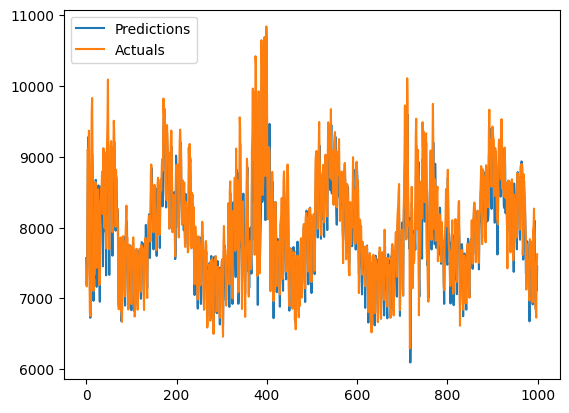

MAPE: 2.67%
RMSE: 305.70
MAE : 217.50


Predictions      Actuals
0     7570.717285  7412.811667
1     7192.906738  7171.183125
2     7429.107910  7350.264167
3     8263.036133  9098.258333
4     9275.581055  9070.002917
...           ...          ...
1084  8049.669434  8447.030417
1085  8846.521484  8771.408958
1086  8561.007812  8487.014792
1087  7822.018555  8380.489792
1088  8438.042969  8437.980833

[1089 rows x 2 columns]

In [225]:
model28 = load_model('model28.keras')

predictions_plot(model28, X_train28, y_train28, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


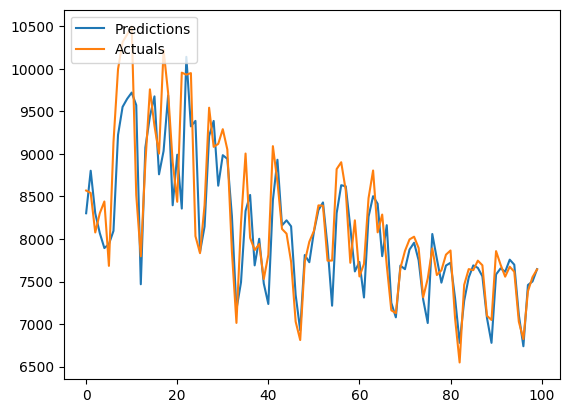

MAPE: 2.90%
RMSE: 332.83
MAE : 233.75


Predictions      Actuals
0    8302.595703  8569.568125
1    8802.291016  8540.904167
2    8301.750977  8076.513125
3    8068.865234  8302.971875
4    7893.556641  8440.820000
..           ...          ...
353  7513.998535  7508.199792
354  7622.064941  7694.271458
355  8064.578613  7746.240833
356  8480.265625  8321.401042
357  8358.343750  8503.726875

[358 rows x 2 columns]

In [226]:
predictions_plot(model28, X_test28, y_test28, 0, 100)

## Explore Temp^2 ##

In [229]:
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data29 = preprocessor.get_model_inputs(target_col='avg_30_min_demand')

X_train29, y_train29 = data29['train']
X_test29, y_test29 = data29['test']

i = X_train29.shape[1]
j = X_train29.shape[2]

In [230]:
model29 = Sequential()
model29.add(InputLayer((i, j)))
model29.add(LSTM(32, dropout=0.013, recurrent_dropout=0.013))
model29.add(Dense(8, 'tanh'))
model29.add(Dense(1, 'linear'))

model29.summary()

Model: "sequential_335"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_349 (LSTM)                 │ (None, 32)             │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_670 (Dense)               │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_671 (Dense)               │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,289 (24.57 KB)

 Trainable params: 6,289 (24.57 KB)

 Non-trainable params: 0 (0.00 B)

In [231]:
cp29 = ModelCheckpoint('model29.keras', monitor='loss', save_best_only=True)
model29.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

history29 = model29.fit(X_train29, y_train29, epochs=100, batch_size=8, callbacks=[cp29])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0344 - root_mean_squared_error: 0.1782
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0117 - root_mean_squared_error: 0.1081
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0109 - root_mean_squared_error: 0.1041
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0104 - root_mean_squared_error: 0.1019
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0100 - root_mean_squared_error: 0.1000
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0087 - root_mean_squared_error: 0.0932
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0090 - r

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


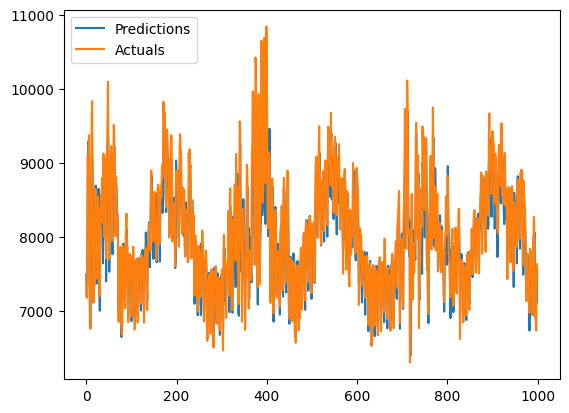

MAPE: 2.69%
RMSE: 307.19
MAE : 218.40


Predictions      Actuals
0     7490.510742  7412.811667
1     7217.905273  7171.183125
2     7331.014160  7350.264167
3     8275.317383  9098.258333
4     9286.197266  9070.002917
...           ...          ...
1084  7825.449219  8447.030417
1085  8465.619141  8771.408958
1086  8281.649414  8487.014792
1087  7999.983887  8380.489792
1088  8764.060547  8437.980833

[1089 rows x 2 columns]

In [232]:
model29 = load_model('model29.keras')

predictions_plot(model29, X_train29, y_train29, 0, 1000)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


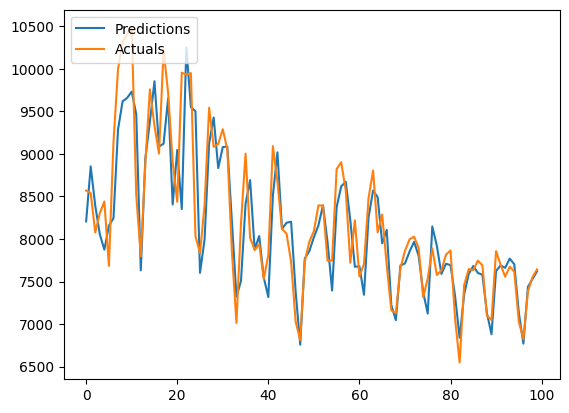

MAPE: 2.92%
RMSE: 332.01
MAE : 234.64


Predictions      Actuals
0    8206.708984  8569.568125
1    8853.165039  8540.904167
2    8391.104492  8076.513125
3    8055.185547  8302.971875
4    7874.858887  8440.820000
..           ...          ...
353  7445.471191  7508.199792
354  7415.952148  7694.271458
355  7813.930664  7746.240833
356  8575.030273  8321.401042
357  8276.790039  8503.726875

[358 rows x 2 columns]

In [233]:
predictions_plot(model29, X_test29, y_test29, 0, 100)

## Recurrent Optuna Trial w/ temp^2 ##

In [235]:
'''study4 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

study4.optimize(objective4, n_trials=100)

[I 2025-09-20 12:09:18,737] A new study created in memory with name: no-name-525b3af4-acc9-48db-b771-ee2cd554bc47
[I 2025-09-20 12:10:22,022] Trial 0 finished with value: 247.23586616375167 and parameters: {'n_units': 8, 'dropout': 0.017425083650459836, 'learning_rate': 0.005399484409787433, 'batch_size': 32, 'recurrent_dropout': 0.2497327922401265}. Best is trial 0 with value: 247.23586616375167.


Trial 0: units=8, dropout=0.02, lr=0.00540, batch=32, MAE=247.24, device=/GPU:0


[I 2025-09-20 12:11:24,414] Trial 1 finished with value: 240.5204530684899 and parameters: {'n_units': 64, 'dropout': 0.08736874205941257, 'learning_rate': 0.0016738085788752138, 'batch_size': 32, 'recurrent_dropout': 0.23555278841790406}. Best is trial 1 with value: 240.5204530684899.


Trial 1: units=64, dropout=0.09, lr=0.00167, batch=32, MAE=240.52, device=/GPU:0


[I 2025-09-20 12:30:38,258] Trial 2 finished with value: 287.64900188246844 and parameters: {'n_units': 64, 'dropout': 0.019515477895583853, 'learning_rate': 0.007902619549708232, 'batch_size': 1, 'recurrent_dropout': 0.20526990795364705}. Best is trial 1 with value: 240.5204530684899.


Trial 2: units=64, dropout=0.02, lr=0.00790, batch=1, MAE=287.65, device=/GPU:0


[I 2025-09-20 12:31:40,437] Trial 3 finished with value: 288.68103931877596 and parameters: {'n_units': 64, 'dropout': 0.19875668530619459, 'learning_rate': 0.0004201672054372534, 'batch_size': 32, 'recurrent_dropout': 0.23253984700833435}. Best is trial 1 with value: 240.5204530684899.


Trial 3: units=64, dropout=0.20, lr=0.00042, batch=32, MAE=288.68, device=/GPU:0


[I 2025-09-20 12:33:33,604] Trial 4 finished with value: 343.878036982303 and parameters: {'n_units': 1, 'dropout': 0.01356818667316142, 'learning_rate': 0.0004473636174621269, 'batch_size': 16, 'recurrent_dropout': 0.08428035290621423}. Best is trial 1 with value: 240.5204530684899.


Trial 4: units=1, dropout=0.01, lr=0.00045, batch=16, MAE=343.88, device=/GPU:0


[I 2025-09-20 12:53:04,467] Trial 5 finished with value: 262.5279931555847 and parameters: {'n_units': 64, 'dropout': 0.059614704460251716, 'learning_rate': 0.00010257563974185662, 'batch_size': 1, 'recurrent_dropout': 0.02221339552022711}. Best is trial 1 with value: 240.5204530684899.


Trial 5: units=64, dropout=0.06, lr=0.00010, batch=1, MAE=262.53, device=/GPU:0


[I 2025-09-20 12:54:57,589] Trial 6 finished with value: 293.5690965484029 and parameters: {'n_units': 16, 'dropout': 0.09329469651469866, 'learning_rate': 0.0004470608546778491, 'batch_size': 16, 'recurrent_dropout': 0.035878273781490506}. Best is trial 1 with value: 240.5204530684899.


Trial 6: units=16, dropout=0.09, lr=0.00045, batch=16, MAE=293.57, device=/GPU:0


[I 2025-09-20 12:56:55,291] Trial 7 finished with value: 322.3842468971438 and parameters: {'n_units': 32, 'dropout': 0.12826230550756487, 'learning_rate': 0.0001124186209579306, 'batch_size': 16, 'recurrent_dropout': 0.15257120734941082}. Best is trial 1 with value: 240.5204530684899.


Trial 7: units=32, dropout=0.13, lr=0.00011, batch=16, MAE=322.38, device=/GPU:0


[I 2025-09-20 13:16:04,150] Trial 8 finished with value: 337.7789833690779 and parameters: {'n_units': 1, 'dropout': 0.0869254358741304, 'learning_rate': 0.0002101079931010357, 'batch_size': 1, 'recurrent_dropout': 0.24110162306973432}. Best is trial 1 with value: 240.5204530684899.


Trial 8: units=1, dropout=0.09, lr=0.00021, batch=1, MAE=337.78, device=/GPU:0


[I 2025-09-20 13:17:54,869] Trial 9 finished with value: 257.4972316767196 and parameters: {'n_units': 64, 'dropout': 0.033015577358303023, 'learning_rate': 0.000285673742984719, 'batch_size': 16, 'recurrent_dropout': 0.1532241907732697}. Best is trial 1 with value: 240.5204530684899.


Trial 9: units=64, dropout=0.03, lr=0.00029, batch=16, MAE=257.50, device=/GPU:0


[I 2025-09-20 13:21:36,545] Trial 10 finished with value: 285.74455530913144 and parameters: {'n_units': 128, 'dropout': 0.2290179149331798, 'learning_rate': 0.002467377537662448, 'batch_size': 8, 'recurrent_dropout': 0.2940250529076695}. Best is trial 1 with value: 240.5204530684899.


Trial 10: units=128, dropout=0.23, lr=0.00247, batch=8, MAE=285.74, device=/GPU:0


[I 2025-09-20 13:22:38,908] Trial 11 finished with value: 305.28960943145904 and parameters: {'n_units': 8, 'dropout': 0.1621887327642123, 'learning_rate': 0.0025647088695610926, 'batch_size': 32, 'recurrent_dropout': 0.29846468365935525}. Best is trial 1 with value: 240.5204530684899.


Trial 11: units=8, dropout=0.16, lr=0.00256, batch=32, MAE=305.29, device=/GPU:0


[I 2025-09-20 13:23:40,406] Trial 12 finished with value: 282.0865213423792 and parameters: {'n_units': 8, 'dropout': 0.28374291599211393, 'learning_rate': 0.007537063819481914, 'batch_size': 32, 'recurrent_dropout': 0.20181925658102232}. Best is trial 1 with value: 240.5204530684899.


Trial 12: units=8, dropout=0.28, lr=0.00754, batch=32, MAE=282.09, device=/GPU:0


[I 2025-09-20 13:24:41,320] Trial 13 finished with value: 298.9676437784147 and parameters: {'n_units': 8, 'dropout': 0.1096706842238564, 'learning_rate': 0.0018415494126285965, 'batch_size': 32, 'recurrent_dropout': 0.25965756027876424}. Best is trial 1 with value: 240.5204530684899.


Trial 13: units=8, dropout=0.11, lr=0.00184, batch=32, MAE=298.97, device=/GPU:0


[I 2025-09-20 13:25:43,223] Trial 14 finished with value: 251.62757963063223 and parameters: {'n_units': 32, 'dropout': 0.0627973666512729, 'learning_rate': 0.0012281940168943355, 'batch_size': 32, 'recurrent_dropout': 0.18829288357678492}. Best is trial 1 with value: 240.5204530684899.


Trial 14: units=32, dropout=0.06, lr=0.00123, batch=32, MAE=251.63, device=/GPU:0


[I 2025-09-20 13:29:22,898] Trial 15 finished with value: 250.9354221965313 and parameters: {'n_units': 16, 'dropout': 0.003095621567710427, 'learning_rate': 0.004835409305318116, 'batch_size': 8, 'recurrent_dropout': 0.09988664770882866}. Best is trial 1 with value: 240.5204530684899.


Trial 15: units=16, dropout=0.00, lr=0.00484, batch=8, MAE=250.94, device=/GPU:0


[I 2025-09-20 13:30:23,646] Trial 16 finished with value: 261.1301431423556 and parameters: {'n_units': 128, 'dropout': 0.1575276886191711, 'learning_rate': 0.004261548525190929, 'batch_size': 32, 'recurrent_dropout': 0.26134394726758836}. Best is trial 1 with value: 240.5204530684899.


Trial 16: units=128, dropout=0.16, lr=0.00426, batch=32, MAE=261.13, device=/GPU:0


[I 2025-09-20 13:31:23,421] Trial 17 finished with value: 295.47027669387984 and parameters: {'n_units': 8, 'dropout': 0.055045433333340874, 'learning_rate': 0.0008556895349553096, 'batch_size': 32, 'recurrent_dropout': 0.11197750296770495}. Best is trial 1 with value: 240.5204530684899.


Trial 17: units=8, dropout=0.06, lr=0.00086, batch=32, MAE=295.47, device=/GPU:0


[I 2025-09-20 13:32:25,347] Trial 18 finished with value: 254.1322722850023 and parameters: {'n_units': 64, 'dropout': 0.046611182393558444, 'learning_rate': 0.0009345884130938793, 'batch_size': 32, 'recurrent_dropout': 0.18091699941758554}. Best is trial 1 with value: 240.5204530684899.


Trial 18: units=64, dropout=0.05, lr=0.00093, batch=32, MAE=254.13, device=/GPU:0


[I 2025-09-20 13:36:05,320] Trial 19 finished with value: 262.4286646792368 and parameters: {'n_units': 8, 'dropout': 0.1316884091198806, 'learning_rate': 0.003884102911126366, 'batch_size': 8, 'recurrent_dropout': 0.22838789266493748}. Best is trial 1 with value: 240.5204530684899.


Trial 19: units=8, dropout=0.13, lr=0.00388, batch=8, MAE=262.43, device=/GPU:0


[I 2025-09-20 13:37:06,950] Trial 20 finished with value: 241.81010128867825 and parameters: {'n_units': 16, 'dropout': 0.07993319510189502, 'learning_rate': 0.009948737862019904, 'batch_size': 32, 'recurrent_dropout': 0.2669378863861264}. Best is trial 1 with value: 240.5204530684899.


Trial 20: units=16, dropout=0.08, lr=0.00995, batch=32, MAE=241.81, device=/GPU:0


[I 2025-09-20 13:38:08,297] Trial 21 finished with value: 240.5208163593787 and parameters: {'n_units': 16, 'dropout': 0.08114559206540618, 'learning_rate': 0.009784281810595529, 'batch_size': 32, 'recurrent_dropout': 0.2749981812903245}. Best is trial 1 with value: 240.5204530684899.


Trial 21: units=16, dropout=0.08, lr=0.00978, batch=32, MAE=240.52, device=/GPU:0


[I 2025-09-20 13:39:10,495] Trial 22 finished with value: 248.3493950201986 and parameters: {'n_units': 16, 'dropout': 0.08156604748438794, 'learning_rate': 0.008119978671355589, 'batch_size': 32, 'recurrent_dropout': 0.2825088973368848}. Best is trial 1 with value: 240.5204530684899.


Trial 22: units=16, dropout=0.08, lr=0.00812, batch=32, MAE=248.35, device=/GPU:0


[I 2025-09-20 13:40:10,928] Trial 23 finished with value: 309.96791293466964 and parameters: {'n_units': 16, 'dropout': 0.11198370904234378, 'learning_rate': 0.0026342103645399916, 'batch_size': 32, 'recurrent_dropout': 0.2653767882132944}. Best is trial 1 with value: 240.5204530684899.


Trial 23: units=16, dropout=0.11, lr=0.00263, batch=32, MAE=309.97, device=/GPU:0


[I 2025-09-20 13:41:10,734] Trial 24 finished with value: 264.73257571216607 and parameters: {'n_units': 16, 'dropout': 0.17796851412534997, 'learning_rate': 0.009968024877663259, 'batch_size': 32, 'recurrent_dropout': 0.27307347555591455}. Best is trial 1 with value: 240.5204530684899.


Trial 24: units=16, dropout=0.18, lr=0.00997, batch=32, MAE=264.73, device=/GPU:0


[I 2025-09-20 13:42:11,571] Trial 25 finished with value: 257.1772537705151 and parameters: {'n_units': 16, 'dropout': 0.07745742628419605, 'learning_rate': 0.0015241767831214777, 'batch_size': 32, 'recurrent_dropout': 0.21960525922972066}. Best is trial 1 with value: 240.5204530684899.


Trial 25: units=16, dropout=0.08, lr=0.00152, batch=32, MAE=257.18, device=/GPU:0


[I 2025-09-20 13:43:11,420] Trial 26 finished with value: 239.76607745674758 and parameters: {'n_units': 16, 'dropout': 0.10977683839313701, 'learning_rate': 0.005947978963878697, 'batch_size': 32, 'recurrent_dropout': 0.17717453351148513}. Best is trial 26 with value: 239.76607745674758.


Trial 26: units=16, dropout=0.11, lr=0.00595, batch=32, MAE=239.77, device=/GPU:0


[I 2025-09-20 14:02:24,354] Trial 27 finished with value: 275.37935801790996 and parameters: {'n_units': 16, 'dropout': 0.11938867644640992, 'learning_rate': 0.0033882594528971376, 'batch_size': 1, 'recurrent_dropout': 0.1739154814253421}. Best is trial 26 with value: 239.76607745674758.


Trial 27: units=16, dropout=0.12, lr=0.00339, batch=1, MAE=275.38, device=/GPU:0


[I 2025-09-20 14:06:04,404] Trial 28 finished with value: 297.3412469397397 and parameters: {'n_units': 32, 'dropout': 0.14488675506474824, 'learning_rate': 0.005711750380496127, 'batch_size': 8, 'recurrent_dropout': 0.12125062627084876}. Best is trial 26 with value: 239.76607745674758.


Trial 28: units=32, dropout=0.14, lr=0.00571, batch=8, MAE=297.34, device=/GPU:0


[I 2025-09-20 14:07:06,174] Trial 29 finished with value: 276.6089862686 and parameters: {'n_units': 128, 'dropout': 0.18951244227461084, 'learning_rate': 0.0061636068148439764, 'batch_size': 32, 'recurrent_dropout': 0.2393353538168887}. Best is trial 26 with value: 239.76607745674758.


Trial 29: units=128, dropout=0.19, lr=0.00616, batch=32, MAE=276.61, device=/GPU:0


[I 2025-09-20 14:08:05,116] Trial 30 finished with value: 433.4986751998959 and parameters: {'n_units': 1, 'dropout': 0.10823580903769973, 'learning_rate': 0.0007137245092957823, 'batch_size': 32, 'recurrent_dropout': 0.20951665164705796}. Best is trial 26 with value: 239.76607745674758.


Trial 30: units=1, dropout=0.11, lr=0.00071, batch=32, MAE=433.50, device=/GPU:0


[I 2025-09-20 14:09:06,483] Trial 31 finished with value: 264.17812726770103 and parameters: {'n_units': 16, 'dropout': 0.09663891620525988, 'learning_rate': 0.00939382015206445, 'batch_size': 32, 'recurrent_dropout': 0.2479045845748925}. Best is trial 26 with value: 239.76607745674758.


Trial 31: units=16, dropout=0.10, lr=0.00939, batch=32, MAE=264.18, device=/GPU:0


[I 2025-09-20 14:10:14,299] Trial 32 finished with value: 236.72472084892277 and parameters: {'n_units': 16, 'dropout': 0.07216934521125465, 'learning_rate': 0.0060989991576101505, 'batch_size': 32, 'recurrent_dropout': 0.28237966887299126}. Best is trial 32 with value: 236.72472084892277.


Trial 32: units=16, dropout=0.07, lr=0.00610, batch=32, MAE=236.72, device=/GPU:0


[I 2025-09-20 14:11:18,443] Trial 33 finished with value: 239.25184465269163 and parameters: {'n_units': 64, 'dropout': 0.03965048314710756, 'learning_rate': 0.0066425000838305215, 'batch_size': 32, 'recurrent_dropout': 0.2788525786939316}. Best is trial 32 with value: 236.72472084892277.


Trial 33: units=64, dropout=0.04, lr=0.00664, batch=32, MAE=239.25, device=/GPU:0


[I 2025-09-20 14:12:21,497] Trial 34 finished with value: 233.01618438799758 and parameters: {'n_units': 64, 'dropout': 0.03150426205590116, 'learning_rate': 0.003127382919933425, 'batch_size': 32, 'recurrent_dropout': 0.29644495468195603}. Best is trial 34 with value: 233.01618438799758.


Trial 34: units=64, dropout=0.03, lr=0.00313, batch=32, MAE=233.02, device=/GPU:0


[I 2025-09-20 14:13:24,847] Trial 35 finished with value: 238.0150550493442 and parameters: {'n_units': 64, 'dropout': 0.03403538738892845, 'learning_rate': 0.006540237663080757, 'batch_size': 32, 'recurrent_dropout': 0.29906680013412607}. Best is trial 34 with value: 233.01618438799758.


Trial 35: units=64, dropout=0.03, lr=0.00654, batch=32, MAE=238.02, device=/GPU:0


[I 2025-09-20 14:32:47,041] Trial 36 finished with value: 271.6982566628764 and parameters: {'n_units': 64, 'dropout': 0.027630426087406446, 'learning_rate': 0.003204873629007933, 'batch_size': 1, 'recurrent_dropout': 0.2979407976265391}. Best is trial 34 with value: 233.01618438799758.


Trial 36: units=64, dropout=0.03, lr=0.00320, batch=1, MAE=271.70, device=/GPU:0


[I 2025-09-20 14:33:49,367] Trial 37 finished with value: 245.75105560092302 and parameters: {'n_units': 64, 'dropout': 0.03761460474495863, 'learning_rate': 0.006771458988548715, 'batch_size': 32, 'recurrent_dropout': 0.2843649452676306}. Best is trial 34 with value: 233.01618438799758.


Trial 37: units=64, dropout=0.04, lr=0.00677, batch=32, MAE=245.75, device=/GPU:0


[I 2025-09-20 14:35:46,889] Trial 38 finished with value: 265.5562974239062 and parameters: {'n_units': 64, 'dropout': 0.011648855952141046, 'learning_rate': 0.005024846718425898, 'batch_size': 16, 'recurrent_dropout': 0.28347929721343607}. Best is trial 34 with value: 233.01618438799758.


Trial 38: units=64, dropout=0.01, lr=0.00502, batch=16, MAE=265.56, device=/GPU:0


[I 2025-09-20 14:36:49,521] Trial 39 finished with value: 235.2718082638668 and parameters: {'n_units': 64, 'dropout': 0.02166846430577172, 'learning_rate': 0.0019946404199348354, 'batch_size': 32, 'recurrent_dropout': 0.2556839095862299}. Best is trial 34 with value: 233.01618438799758.


Trial 39: units=64, dropout=0.02, lr=0.00199, batch=32, MAE=235.27, device=/GPU:0


[I 2025-09-20 14:56:03,253] Trial 40 finished with value: 281.8079892311904 and parameters: {'n_units': 64, 'dropout': 0.021052628402382572, 'learning_rate': 0.001868375689628242, 'batch_size': 1, 'recurrent_dropout': 0.24874880687280593}. Best is trial 34 with value: 233.01618438799758.


Trial 40: units=64, dropout=0.02, lr=0.00187, batch=1, MAE=281.81, device=/GPU:0


[I 2025-09-20 14:57:06,721] Trial 41 finished with value: 235.29017803319755 and parameters: {'n_units': 64, 'dropout': 0.002553780570270385, 'learning_rate': 0.003949669291134196, 'batch_size': 32, 'recurrent_dropout': 0.2872715343632271}. Best is trial 34 with value: 233.01618438799758.


Trial 41: units=64, dropout=0.00, lr=0.00395, batch=32, MAE=235.29, device=/GPU:0


[I 2025-09-20 14:58:08,881] Trial 42 finished with value: 223.64360336080057 and parameters: {'n_units': 64, 'dropout': 0.001449803981334354, 'learning_rate': 0.003106910330480191, 'batch_size': 32, 'recurrent_dropout': 0.29956780266548094}. Best is trial 42 with value: 223.64360336080057.


Trial 42: units=64, dropout=0.00, lr=0.00311, batch=32, MAE=223.64, device=/GPU:0


[I 2025-09-20 14:59:11,567] Trial 43 finished with value: 230.32578698916558 and parameters: {'n_units': 64, 'dropout': 0.0021909023749092957, 'learning_rate': 0.002313138932517968, 'batch_size': 32, 'recurrent_dropout': 0.2556958880595713}. Best is trial 42 with value: 223.64360336080057.


Trial 43: units=64, dropout=0.00, lr=0.00231, batch=32, MAE=230.33, device=/GPU:0


[I 2025-09-20 15:00:14,130] Trial 44 finished with value: 243.38998335294735 and parameters: {'n_units': 64, 'dropout': 0.0005888146777954095, 'learning_rate': 0.0020788490555196577, 'batch_size': 32, 'recurrent_dropout': 0.05355803820644209}. Best is trial 42 with value: 223.64360336080057.


Trial 44: units=64, dropout=0.00, lr=0.00208, batch=32, MAE=243.39, device=/GPU:0


[I 2025-09-20 15:02:10,100] Trial 45 finished with value: 225.72997720813655 and parameters: {'n_units': 64, 'dropout': 0.014701473254671863, 'learning_rate': 0.0014621683084538846, 'batch_size': 16, 'recurrent_dropout': 0.2571398383444214}. Best is trial 42 with value: 223.64360336080057.


Trial 45: units=64, dropout=0.01, lr=0.00146, batch=16, MAE=225.73, device=/GPU:0


[I 2025-09-20 15:04:05,606] Trial 46 finished with value: 229.96795386897645 and parameters: {'n_units': 64, 'dropout': 0.016875845203148023, 'learning_rate': 0.0014304785481466398, 'batch_size': 16, 'recurrent_dropout': 0.22619051423512937}. Best is trial 42 with value: 223.64360336080057.


Trial 46: units=64, dropout=0.02, lr=0.00143, batch=16, MAE=229.97, device=/GPU:0


[I 2025-09-20 15:06:00,482] Trial 47 finished with value: 231.2763419657885 and parameters: {'n_units': 64, 'dropout': 0.015412051853484722, 'learning_rate': 0.0011849931434242645, 'batch_size': 16, 'recurrent_dropout': 0.2264400054935381}. Best is trial 42 with value: 223.64360336080057.


Trial 47: units=64, dropout=0.02, lr=0.00118, batch=16, MAE=231.28, device=/GPU:0


[I 2025-09-20 15:07:52,905] Trial 48 finished with value: 246.75402204716903 and parameters: {'n_units': 64, 'dropout': 0.051407225293527696, 'learning_rate': 0.0014034801928379593, 'batch_size': 16, 'recurrent_dropout': 0.23264765847474483}. Best is trial 42 with value: 223.64360336080057.


Trial 48: units=64, dropout=0.05, lr=0.00140, batch=16, MAE=246.75, device=/GPU:0


[I 2025-09-20 15:09:43,037] Trial 49 finished with value: 346.41447516266555 and parameters: {'n_units': 1, 'dropout': 0.013323324694849622, 'learning_rate': 0.0006571729897443863, 'batch_size': 16, 'recurrent_dropout': 0.21800099782163615}. Best is trial 42 with value: 223.64360336080057.


Trial 49: units=1, dropout=0.01, lr=0.00066, batch=16, MAE=346.41, device=/GPU:0


[I 2025-09-20 15:11:36,322] Trial 50 finished with value: 252.31371689779075 and parameters: {'n_units': 64, 'dropout': 0.06677610745458841, 'learning_rate': 0.0011130938666002806, 'batch_size': 16, 'recurrent_dropout': 0.19539423110790774}. Best is trial 42 with value: 223.64360336080057.


Trial 50: units=64, dropout=0.07, lr=0.00111, batch=16, MAE=252.31, device=/GPU:0


[I 2025-09-20 15:13:29,852] Trial 51 finished with value: 230.51243574738268 and parameters: {'n_units': 64, 'dropout': 0.01518606157353885, 'learning_rate': 0.001346477106910175, 'batch_size': 16, 'recurrent_dropout': 0.25089786069037984}. Best is trial 42 with value: 223.64360336080057.


Trial 51: units=64, dropout=0.02, lr=0.00135, batch=16, MAE=230.51, device=/GPU:0


[I 2025-09-20 15:15:21,880] Trial 52 finished with value: 235.65370145027873 and parameters: {'n_units': 64, 'dropout': 0.0146255780297075, 'learning_rate': 0.001388202393404469, 'batch_size': 16, 'recurrent_dropout': 0.22411765229194314}. Best is trial 42 with value: 223.64360336080057.


Trial 52: units=64, dropout=0.01, lr=0.00139, batch=16, MAE=235.65, device=/GPU:0


[I 2025-09-20 15:17:15,650] Trial 53 finished with value: 311.48351642181296 and parameters: {'n_units': 64, 'dropout': 0.23317918919749558, 'learning_rate': 0.0011820648434777543, 'batch_size': 16, 'recurrent_dropout': 0.2472589138691202}. Best is trial 42 with value: 223.64360336080057.


Trial 53: units=64, dropout=0.23, lr=0.00118, batch=16, MAE=311.48, device=/GPU:0


[I 2025-09-20 15:19:10,258] Trial 54 finished with value: 239.22583969790392 and parameters: {'n_units': 64, 'dropout': 0.045467544938249005, 'learning_rate': 0.0022652337924383825, 'batch_size': 16, 'recurrent_dropout': 0.2101900935114725}. Best is trial 42 with value: 223.64360336080057.


Trial 54: units=64, dropout=0.05, lr=0.00227, batch=16, MAE=239.23, device=/GPU:0


[I 2025-09-20 15:21:05,112] Trial 55 finished with value: 236.74619892656634 and parameters: {'n_units': 32, 'dropout': 0.009880307432967125, 'learning_rate': 0.0007519579256507892, 'batch_size': 16, 'recurrent_dropout': 0.0008003883831843861}. Best is trial 42 with value: 223.64360336080057.


Trial 55: units=32, dropout=0.01, lr=0.00075, batch=16, MAE=236.75, device=/GPU:0


[I 2025-09-20 15:22:59,663] Trial 56 finished with value: 244.4338337928085 and parameters: {'n_units': 64, 'dropout': 0.024975596177965086, 'learning_rate': 0.0005397850740438106, 'batch_size': 16, 'recurrent_dropout': 0.13899943955958416}. Best is trial 42 with value: 223.64360336080057.


Trial 56: units=64, dropout=0.02, lr=0.00054, batch=16, MAE=244.43, device=/GPU:0


[I 2025-09-20 15:24:54,130] Trial 57 finished with value: 244.8870978041656 and parameters: {'n_units': 128, 'dropout': 0.057085016281149606, 'learning_rate': 0.0017209081727342214, 'batch_size': 16, 'recurrent_dropout': 0.23693627869392586}. Best is trial 42 with value: 223.64360336080057.


Trial 57: units=128, dropout=0.06, lr=0.00172, batch=16, MAE=244.89, device=/GPU:0


[I 2025-09-20 15:26:45,586] Trial 58 finished with value: 233.5768074518094 and parameters: {'n_units': 64, 'dropout': 0.0022263496496838057, 'learning_rate': 0.001004322426444223, 'batch_size': 16, 'recurrent_dropout': 0.16330958059680117}. Best is trial 42 with value: 223.64360336080057.


Trial 58: units=64, dropout=0.00, lr=0.00100, batch=16, MAE=233.58, device=/GPU:0


[I 2025-09-20 15:28:38,646] Trial 59 finished with value: 339.7388738706807 and parameters: {'n_units': 64, 'dropout': 0.29416782129564595, 'learning_rate': 0.0026436331414611434, 'batch_size': 16, 'recurrent_dropout': 0.26760046242936414}. Best is trial 42 with value: 223.64360336080057.


Trial 59: units=64, dropout=0.29, lr=0.00264, batch=16, MAE=339.74, device=/GPU:0


[I 2025-09-20 15:30:32,555] Trial 60 finished with value: 255.4095093186033 and parameters: {'n_units': 64, 'dropout': 0.04328077524544818, 'learning_rate': 0.0003577290457580503, 'batch_size': 16, 'recurrent_dropout': 0.25893363060834307}. Best is trial 42 with value: 223.64360336080057.


Trial 60: units=64, dropout=0.04, lr=0.00036, batch=16, MAE=255.41, device=/GPU:0


[I 2025-09-20 15:32:26,319] Trial 61 finished with value: 235.64908749447088 and parameters: {'n_units': 64, 'dropout': 0.025084255543261085, 'learning_rate': 0.0030849285805031714, 'batch_size': 16, 'recurrent_dropout': 0.27243043147222956}. Best is trial 42 with value: 223.64360336080057.


Trial 61: units=64, dropout=0.03, lr=0.00308, batch=16, MAE=235.65, device=/GPU:0


[I 2025-09-20 15:36:03,181] Trial 62 finished with value: 235.01306450129275 and parameters: {'n_units': 64, 'dropout': 0.031355257498288026, 'learning_rate': 0.0015402163355651846, 'batch_size': 8, 'recurrent_dropout': 0.254636064390416}. Best is trial 42 with value: 223.64360336080057.


Trial 62: units=64, dropout=0.03, lr=0.00154, batch=8, MAE=235.01, device=/GPU:0


[I 2025-09-20 15:37:55,188] Trial 63 finished with value: 245.07343040722074 and parameters: {'n_units': 64, 'dropout': 0.014506427703606615, 'learning_rate': 0.002308491582425574, 'batch_size': 16, 'recurrent_dropout': 0.24334404897634018}. Best is trial 42 with value: 223.64360336080057.


Trial 63: units=64, dropout=0.01, lr=0.00231, batch=16, MAE=245.07, device=/GPU:0


[I 2025-09-20 15:39:46,692] Trial 64 finished with value: 313.3606326965562 and parameters: {'n_units': 1, 'dropout': 0.03308361362089369, 'learning_rate': 0.0013190674673497587, 'batch_size': 16, 'recurrent_dropout': 0.29279629371401167}. Best is trial 42 with value: 223.64360336080057.


Trial 64: units=1, dropout=0.03, lr=0.00132, batch=16, MAE=313.36, device=/GPU:0


[I 2025-09-20 15:41:40,850] Trial 65 finished with value: 246.2658862941809 and parameters: {'n_units': 8, 'dropout': 8.347463782694062e-05, 'learning_rate': 0.002903205158428555, 'batch_size': 16, 'recurrent_dropout': 0.23197366661397564}. Best is trial 42 with value: 223.64360336080057.


Trial 65: units=8, dropout=0.00, lr=0.00290, batch=16, MAE=246.27, device=/GPU:0


[I 2025-09-20 15:45:21,149] Trial 66 finished with value: 238.41472424452346 and parameters: {'n_units': 64, 'dropout': 0.018241795834701438, 'learning_rate': 0.001051829305121708, 'batch_size': 8, 'recurrent_dropout': 0.19827175880500705}. Best is trial 42 with value: 223.64360336080057.


Trial 66: units=64, dropout=0.02, lr=0.00105, batch=8, MAE=238.41, device=/GPU:0


[I 2025-09-20 16:04:09,759] Trial 67 finished with value: 236.25051610244384 and parameters: {'n_units': 32, 'dropout': 0.00851402001934531, 'learning_rate': 0.000851257530065642, 'batch_size': 1, 'recurrent_dropout': 0.2649429368088505}. Best is trial 42 with value: 223.64360336080057.


Trial 67: units=32, dropout=0.01, lr=0.00085, batch=1, MAE=236.25, device=/GPU:0


[I 2025-09-20 16:06:01,297] Trial 68 finished with value: 248.7620133310783 and parameters: {'n_units': 64, 'dropout': 0.050301679500135116, 'learning_rate': 0.001754388917743993, 'batch_size': 16, 'recurrent_dropout': 0.21833124562750897}. Best is trial 42 with value: 223.64360336080057.


Trial 68: units=64, dropout=0.05, lr=0.00175, batch=16, MAE=248.76, device=/GPU:0


[I 2025-09-20 16:07:56,178] Trial 69 finished with value: 306.0010030156001 and parameters: {'n_units': 128, 'dropout': 0.2218771010664193, 'learning_rate': 0.0043484210614355276, 'batch_size': 16, 'recurrent_dropout': 0.2760727166936707}. Best is trial 42 with value: 223.64360336080057.


Trial 69: units=128, dropout=0.22, lr=0.00435, batch=16, MAE=306.00, device=/GPU:0


[I 2025-09-20 16:09:50,911] Trial 70 finished with value: 283.9820218385077 and parameters: {'n_units': 64, 'dropout': 0.0653061528984011, 'learning_rate': 0.0001344244106171966, 'batch_size': 16, 'recurrent_dropout': 0.19006489577087027}. Best is trial 42 with value: 223.64360336080057.


Trial 70: units=64, dropout=0.07, lr=0.00013, batch=16, MAE=283.98, device=/GPU:0


[I 2025-09-20 16:11:44,494] Trial 71 finished with value: 239.7416326680897 and parameters: {'n_units': 64, 'dropout': 0.007418551599701421, 'learning_rate': 0.000957515520056833, 'batch_size': 16, 'recurrent_dropout': 0.16313291073811786}. Best is trial 42 with value: 223.64360336080057.


Trial 71: units=64, dropout=0.01, lr=0.00096, batch=16, MAE=239.74, device=/GPU:0


[I 2025-09-20 16:13:44,920] Trial 72 finished with value: 226.9514951026812 and parameters: {'n_units': 64, 'dropout': 0.021505920647061368, 'learning_rate': 0.0015773561315441166, 'batch_size': 16, 'recurrent_dropout': 0.2901189142740676}. Best is trial 42 with value: 223.64360336080057.


Trial 72: units=64, dropout=0.02, lr=0.00158, batch=16, MAE=226.95, device=/GPU:0


[I 2025-09-20 16:15:43,742] Trial 73 finished with value: 227.53706494763577 and parameters: {'n_units': 64, 'dropout': 0.028294219713338422, 'learning_rate': 0.0015930033884222058, 'batch_size': 16, 'recurrent_dropout': 0.28777155406810845}. Best is trial 42 with value: 223.64360336080057.


Trial 73: units=64, dropout=0.03, lr=0.00159, batch=16, MAE=227.54, device=/GPU:0


[I 2025-09-20 16:17:42,414] Trial 74 finished with value: 228.512293140258 and parameters: {'n_units': 64, 'dropout': 0.021267078346817063, 'learning_rate': 0.0015554687276011928, 'batch_size': 16, 'recurrent_dropout': 0.2871729323352373}. Best is trial 42 with value: 223.64360336080057.


Trial 74: units=64, dropout=0.02, lr=0.00156, batch=16, MAE=228.51, device=/GPU:0


[I 2025-09-20 16:19:39,647] Trial 75 finished with value: 233.38648769171198 and parameters: {'n_units': 64, 'dropout': 0.04126317986405229, 'learning_rate': 0.002125188438293264, 'batch_size': 16, 'recurrent_dropout': 0.28629883539980155}. Best is trial 42 with value: 223.64360336080057.


Trial 75: units=64, dropout=0.04, lr=0.00213, batch=16, MAE=233.39, device=/GPU:0


[I 2025-09-20 16:21:35,460] Trial 76 finished with value: 253.2713416558578 and parameters: {'n_units': 8, 'dropout': 0.021973639258228216, 'learning_rate': 0.0015930099450477226, 'batch_size': 16, 'recurrent_dropout': 0.2708182241442994}. Best is trial 42 with value: 223.64360336080057.


Trial 76: units=8, dropout=0.02, lr=0.00159, batch=16, MAE=253.27, device=/GPU:0


[I 2025-09-20 16:23:30,617] Trial 77 finished with value: 235.96416483067907 and parameters: {'n_units': 64, 'dropout': 0.028687109381751282, 'learning_rate': 0.001314273362269172, 'batch_size': 16, 'recurrent_dropout': 0.2584153541820489}. Best is trial 42 with value: 223.64360336080057.


Trial 77: units=64, dropout=0.03, lr=0.00131, batch=16, MAE=235.96, device=/GPU:0


[I 2025-09-20 16:25:29,082] Trial 78 finished with value: 239.9671635870452 and parameters: {'n_units': 64, 'dropout': 0.037471689226080386, 'learning_rate': 0.0025078771302420237, 'batch_size': 16, 'recurrent_dropout': 0.28826376824162264}. Best is trial 42 with value: 223.64360336080057.


Trial 78: units=64, dropout=0.04, lr=0.00251, batch=16, MAE=239.97, device=/GPU:0


[I 2025-09-20 16:29:10,171] Trial 79 finished with value: 314.8498943360495 and parameters: {'n_units': 1, 'dropout': 0.007885711962164171, 'learning_rate': 0.0035884289960879134, 'batch_size': 8, 'recurrent_dropout': 0.2781186975913398}. Best is trial 42 with value: 223.64360336080057.


Trial 79: units=1, dropout=0.01, lr=0.00359, batch=8, MAE=314.85, device=/GPU:0


[I 2025-09-20 16:48:18,570] Trial 80 finished with value: 268.2364335474364 and parameters: {'n_units': 64, 'dropout': 0.054515840964335496, 'learning_rate': 0.001518473385320022, 'batch_size': 1, 'recurrent_dropout': 0.2921684633678657}. Best is trial 42 with value: 223.64360336080057.


Trial 80: units=64, dropout=0.05, lr=0.00152, batch=1, MAE=268.24, device=/GPU:0


[I 2025-09-20 16:50:12,907] Trial 81 finished with value: 228.33415180567272 and parameters: {'n_units': 64, 'dropout': 0.01725939649897262, 'learning_rate': 0.001181390720225739, 'batch_size': 16, 'recurrent_dropout': 0.24994381366782234}. Best is trial 42 with value: 223.64360336080057.


Trial 81: units=64, dropout=0.02, lr=0.00118, batch=16, MAE=228.33, device=/GPU:0


[I 2025-09-20 16:52:10,055] Trial 82 finished with value: 231.99666224812412 and parameters: {'n_units': 64, 'dropout': 0.02191816143486785, 'learning_rate': 0.0018738506619948756, 'batch_size': 16, 'recurrent_dropout': 0.2667989490428052}. Best is trial 42 with value: 223.64360336080057.


Trial 82: units=64, dropout=0.02, lr=0.00187, batch=16, MAE=232.00, device=/GPU:0


[I 2025-09-20 16:54:04,475] Trial 83 finished with value: 229.82976332677097 and parameters: {'n_units': 64, 'dropout': 0.00817038536290389, 'learning_rate': 0.0016962778484858945, 'batch_size': 16, 'recurrent_dropout': 0.24956445192234103}. Best is trial 42 with value: 223.64360336080057.


Trial 83: units=64, dropout=0.01, lr=0.00170, batch=16, MAE=229.83, device=/GPU:0


[I 2025-09-20 16:56:01,583] Trial 84 finished with value: 231.3855399498088 and parameters: {'n_units': 64, 'dropout': 0.0005518142555454592, 'learning_rate': 0.0016996142487119869, 'batch_size': 16, 'recurrent_dropout': 0.2766368839132214}. Best is trial 42 with value: 223.64360336080057.


Trial 84: units=64, dropout=0.00, lr=0.00170, batch=16, MAE=231.39, device=/GPU:0


[I 2025-09-20 16:57:58,494] Trial 85 finished with value: 226.40360717709916 and parameters: {'n_units': 64, 'dropout': 0.02721615007645175, 'learning_rate': 0.001994455941222412, 'batch_size': 16, 'recurrent_dropout': 0.23986387156819663}. Best is trial 42 with value: 223.64360336080057.


Trial 85: units=64, dropout=0.03, lr=0.00199, batch=16, MAE=226.40, device=/GPU:0


[I 2025-09-20 16:59:53,334] Trial 86 finished with value: 236.85041273247046 and parameters: {'n_units': 64, 'dropout': 0.03032029298234851, 'learning_rate': 0.00198815995353305, 'batch_size': 16, 'recurrent_dropout': 0.23984448825536803}. Best is trial 42 with value: 223.64360336080057.


Trial 86: units=64, dropout=0.03, lr=0.00199, batch=16, MAE=236.85, device=/GPU:0


[I 2025-09-20 17:01:45,340] Trial 87 finished with value: 245.58598864653962 and parameters: {'n_units': 32, 'dropout': 0.04557053523779196, 'learning_rate': 0.0008599359186750342, 'batch_size': 16, 'recurrent_dropout': 0.2983619266609693}. Best is trial 42 with value: 223.64360336080057.


Trial 87: units=32, dropout=0.05, lr=0.00086, batch=16, MAE=245.59, device=/GPU:0


[I 2025-09-20 17:03:41,098] Trial 88 finished with value: 240.7057724017524 and parameters: {'n_units': 64, 'dropout': 0.03497483389597832, 'learning_rate': 0.002757615035983511, 'batch_size': 16, 'recurrent_dropout': 0.2622106890535414}. Best is trial 42 with value: 223.64360336080057.


Trial 88: units=64, dropout=0.03, lr=0.00276, batch=16, MAE=240.71, device=/GPU:0


[I 2025-09-20 17:05:37,976] Trial 89 finished with value: 254.36065526195912 and parameters: {'n_units': 64, 'dropout': 0.09389822989353849, 'learning_rate': 0.0011893479919072882, 'batch_size': 16, 'recurrent_dropout': 0.290227577143589}. Best is trial 42 with value: 223.64360336080057.


Trial 89: units=64, dropout=0.09, lr=0.00119, batch=16, MAE=254.36, device=/GPU:0


[I 2025-09-20 17:07:31,986] Trial 90 finished with value: 333.74549734337876 and parameters: {'n_units': 128, 'dropout': 0.2601329895144786, 'learning_rate': 0.0015013758710422595, 'batch_size': 16, 'recurrent_dropout': 0.24468350199564723}. Best is trial 42 with value: 223.64360336080057.


Trial 90: units=128, dropout=0.26, lr=0.00150, batch=16, MAE=333.75, device=/GPU:0


[I 2025-09-20 17:09:28,699] Trial 91 finished with value: 237.2766398947878 and parameters: {'n_units': 64, 'dropout': 0.01838531233000952, 'learning_rate': 0.002227069356931967, 'batch_size': 16, 'recurrent_dropout': 0.2534149465312847}. Best is trial 42 with value: 223.64360336080057.


Trial 91: units=64, dropout=0.02, lr=0.00223, batch=16, MAE=237.28, device=/GPU:0


[I 2025-09-20 17:11:21,428] Trial 92 finished with value: 240.38556005267142 and parameters: {'n_units': 64, 'dropout': 0.007920259278502317, 'learning_rate': 0.002406439283589578, 'batch_size': 16, 'recurrent_dropout': 0.28037070258068253}. Best is trial 42 with value: 223.64360336080057.


Trial 92: units=64, dropout=0.01, lr=0.00241, batch=16, MAE=240.39, device=/GPU:0


[I 2025-09-20 17:13:16,643] Trial 93 finished with value: 240.2387221755565 and parameters: {'n_units': 64, 'dropout': 0.02469645130695884, 'learning_rate': 0.0019221581833080558, 'batch_size': 16, 'recurrent_dropout': 0.23704401601483716}. Best is trial 42 with value: 223.64360336080057.


Trial 93: units=64, dropout=0.02, lr=0.00192, batch=16, MAE=240.24, device=/GPU:0


[I 2025-09-20 17:14:19,202] Trial 94 finished with value: 234.63747358781197 and parameters: {'n_units': 64, 'dropout': 0.009334613030490917, 'learning_rate': 0.0016214571640496243, 'batch_size': 32, 'recurrent_dropout': 0.21046648534231394}. Best is trial 42 with value: 223.64360336080057.


Trial 94: units=64, dropout=0.01, lr=0.00162, batch=32, MAE=234.64, device=/GPU:0


[I 2025-09-20 17:16:11,380] Trial 95 finished with value: 231.20370345935063 and parameters: {'n_units': 64, 'dropout': 0.017127635756434004, 'learning_rate': 0.0010671794067438466, 'batch_size': 16, 'recurrent_dropout': 0.07776302109001818}. Best is trial 42 with value: 223.64360336080057.


Trial 95: units=64, dropout=0.02, lr=0.00107, batch=16, MAE=231.20, device=/GPU:0


[I 2025-09-20 17:35:13,333] Trial 96 finished with value: 262.033887383657 and parameters: {'n_units': 64, 'dropout': 0.027934355663599714, 'learning_rate': 0.0012547517846968662, 'batch_size': 1, 'recurrent_dropout': 0.26092060298297026}. Best is trial 42 with value: 223.64360336080057.


Trial 96: units=64, dropout=0.03, lr=0.00125, batch=1, MAE=262.03, device=/GPU:0


[I 2025-09-20 17:36:14,391] Trial 97 finished with value: 236.26519750794023 and parameters: {'n_units': 64, 'dropout': 0.038582818648883944, 'learning_rate': 0.0014099446506095237, 'batch_size': 32, 'recurrent_dropout': 0.2721279305199256}. Best is trial 42 with value: 223.64360336080057.


Trial 97: units=64, dropout=0.04, lr=0.00141, batch=32, MAE=236.27, device=/GPU:0


[I 2025-09-20 17:38:06,699] Trial 98 finished with value: 248.9712733675371 and parameters: {'n_units': 8, 'dropout': 0.006085204597275155, 'learning_rate': 0.0017244745621705778, 'batch_size': 16, 'recurrent_dropout': 0.250884280361262}. Best is trial 42 with value: 223.64360336080057.


Trial 98: units=8, dropout=0.01, lr=0.00172, batch=16, MAE=248.97, device=/GPU:0


[I 2025-09-20 17:40:01,009] Trial 99 finished with value: 234.8429692998997 and parameters: {'n_units': 64, 'dropout': 0.013768802219050521, 'learning_rate': 0.0021159909610872826, 'batch_size': 16, 'recurrent_dropout': 0.23042014329612026}. Best is trial 42 with value: 223.64360336080057.


Trial 99: units=64, dropout=0.01, lr=0.00212, batch=16, MAE=234.84, device=/GPU:0


In [ ]:
'''print("Best trial:")
trial3 = study4.best_trial

print(f"  MAE: {trial4.value:.2f}")
print("  Params:")
for key, value in trial4.params.items():
    print(f"    {key}: {value}")